# **FINTECH PROJECT - GROUP 13**

# **Risk-Based Recommender System for Active and Passive Portfolios Replicating**

### **Institution**: Politecnico di Milano
### **Coursework**:  FINTECH - A.Y. 2024-2025
### **Authors**:     Manfredi Giacomo, Pescotto Leonardo,Tarditi Andrea, Toia Nicolò, Torba Matteo

<br>

# Abstract

This project presents a comprehensive framework for a **Risk-Based Recommender System of Active and Passive Portfolios of Replica**, designed to personalize investment strategies while maintaining robust risk management. The solution combines two core elements: a **Recommender System** and a **Replica Portfolio Construction Engine**. The Recommender System uses supervised learning (Random Forests) to classify clients based on their profiles and investment objectives (Income or Accumulation), providing tailored portfolio suggestions. Parallelly, the Replica Engine constructs alternative investment strategies replicating benchmark indices (Equity, Bond, and LifeStrategy 80/20) using models such as **Equally Weighted portfolios, Elastic Net Regression (tuned via Optuna), Kalman Filters, and Ensemble Kalman Filters**.

A critical feature is the **Anomaly Detection module**, employing both supervised (MLP and LSTM Classifiers) and unsupervised (LSTM Autoencoder) models to identify market stress periods. These anomaly signals overlay the replica strategies, enabling dynamic reallocation to cash or safer assets during adverse conditions, effectively enhancing portfolio resilience.

To bridge the gap between data science and practice, we developed a **web application** ([https://gm46.pythonanywhere.com/](https://gm46.pythonanywhere.com/)) that allows new clients to complete a brief questionnaire and receive real-time investment recommendations tailored to their risk profile and preferences.

Overall, this integrated approach demonstrates how machine learning, anomaly detection, and portfolio replication can be combined to create adaptive, personalized investment solutions. By uniting these methodologies, the project delivers a robust tool to support financial decision-making and align portfolio allocations with both market conditions and individual investor needs.

<br>
<br>


# Table of Contents

0. [Selection of the portfolio](#sec-0-ptf-sel)
1. [Introduction: Final Project – Group 13](#sec-1-introduction)
2. [Prediction](#sec-2-prediction)

    2.0 [Predictor Class Full Pipeline Overview](#sec-20-predictor-overview)

    2.1 [Setup and Data Loading and Dataset Preprocessing](#sec-21-predictor-setup)

    2.2 [Predictor Exploratory Data Analysis (EDA)](#sec-22-predictor-eda)

    2.3 [Predictor Joint Training & Evaluation](#sec-23-predictor-train)

    2.4 [Predictor Explanatory Part](#sec-24-predictor-expl)



3. [Replica](#sec-3-replica)

    3.0 [Replica Introduction - Data Loading and Preprocessing](#sec-30-replica-intro)

    3.1 [Portfolio Replica EDA](#sec-31-replica-eda)

    3.2 [Equally Weighted Portfolio Replication](#sec-32-replica-ewptf)

    3.3 [Elastic Net Portfolio Replication](#sec-33-replica-en)

    3.4 [Kalman Filter Portfolio Replication](#sec-34-replica-kf)

    3.5 [Ensemble Kalman Filter Portfolio Replication](#sec-35-replica-ekf)


4. [Anomaly Detection](#sec-4-anomaly-detection)

    4.0 [Anomaly Detection Introduction](#sec-40-anomaly-detection-introduction)

    4.1 [Anomaly Detection Dataloading and Preprocessing](#sec-41-anomaly-detection-dataloading-and-preprocessing)

    4.2 [Anomaly Detection EDA](#sec-42-anomaly-detection-eda)

    4.3 [MLP for Anomaly Detection](#sec-43-mlp-for-anomaly-detection)

    4.3.1 [Simple MLP for Anomaly Detection](#sec-431-simple-mlp-for-anomaly-detection)

    4.3.2 [MLP with Optuna Hyperparameter Tuning for Anomaly Detection](#sec-432-mlp-with-optuna)
    
    4.4 [LSTM for Anomaly Detection](#sec-44-lstm)

    4.4.1 [LSTM Autoencoder for Unsupervised Anomaly Detection](#sec-441-lstm-autoencoder)

    4.4.2 [LSTM Classifier for Supervised Anomaly Detection](#sec-442-lstm-class)

    4.5 [Results Comparison](#sec-45-res-comp)

5. [Replica and Anomaly Detection Combination - Alternative Portfolios: Active Risk Management with Anomaly Detection](#sec-5-combination)

    5.1 [Discrete Approach](#sec-51-disc)

    5.2 [Fractional Weights](#sec-52-fw)


6. [Results](#sec-6-results)

7. [Conclusions](#sec-7-conclusions)

8. [Bibliography](#sec-8-bibliography)



---
<a id="sec-0-ptf-sel"></a>
# 0. Selection of the portfolio


Before building the predictor and the index replica, you must select the type of **target portfolio** to use in this study. This initial step is crucial as it determines the market segment and risk profile to be analyzed.

We offer three alternative portfolio configurations:

1) **Equity Portfolio**  
This configuration aims to replicate the performance of the `MXWO Index` (MSCI World Index). It represents a globally diversified basket of stocks, providing broad exposure to equity markets across various regions and sectors.

2) **Bond Portfolio**  
This portfolio replicates the `LEGATRUU Index`, a global bond index that reflects the performance of investment-grade fixed-income securities. It is suitable for investors seeking stability and lower risk compared to equity markets.

3)  **LifeStrategy 80/20 Portfolio**  
This balanced allocation combines 80% exposure to the `MXWO Index` and 20% exposure to the `LEGATRUU Index`, reflecting a traditional 80/20 equity-bond split (commonly referred to as LifeStrategy 80/20). It is designed to provide a moderate risk-return profile by blending growth from equities with the stability of bonds.

Use the interactive widgets below to select your desired portfolio configuration and confirm your choice. This will guide the subsequent data preparation, replication models, and performance analysis for your selected strategy.


In [51]:
# Install the required packages saved in requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import ipywidgets as widgets
from IPython.display import display

# Read the name of the selected portfolio
def get_selected_portfolio():
    selected_value = portfolio_selector.value
    if selected_value == 1:
        return "Portfolio Equity"
    elif selected_value == 2:
        return "Portfolio Bond"
    elif selected_value == 3:
        return "Portfolio LifeStrategy 80_20"
    elif selected_value == 0:
        portfolio_selector.value = 1  # Default to Portfolio Equity
        return "NOT A CHOICE"
    else:
        return None

# Create a small dropdown or radio‐button selector
opt = {
    "NOT A CHOICE": 0,
    "Portfolio Equity": 1,
    "Portfolio Bond": 2,
    "Portfolio LifeStrategy 80_20": 3,
}

# Radio buttons for portfolio selection
portfolio_selector = widgets.RadioButtons(
    options=[
        ("NOT A CHOICE", 0),
        ("Portfolio Equity", 1),
        ("Portfolio Bond", 2),
        ("Portfolio LifeStrategy", 3),
    ],
    description="Scegli:",
)

# Button to confirm the selection
submit_btn = widgets.Button(description="Conferma")

# Output widget to display the result
out = widgets.Output()

# Execute the code when the button is clicked
def on_submit(b):
    with out:
        selected_flag = portfolio_selector.value
        print(f"Current Selection:", get_selected_portfolio())

# Connect the button click event to the function
submit_btn.on_click(on_submit)

# Display all widgets
display(portfolio_selector, submit_btn, out)

RadioButtons(description='Scegli:', options=(('NOT A CHOICE', 0), ('Portfolio Equity', 1), ('Portfolio Bond', …

Button(description='Conferma', style=ButtonStyle())

Output()

In [53]:
from IPython.display import Javascript

selected_flag = portfolio_selector.value
print("Saved Flag:", get_selected_portfolio())

if selected_flag == 0:
    # Automatically select "Equity Portfolio"
    selected_flag = 1
    print(f"{get_selected_portfolio()} was automatically selected.")

    # Display a real browser alert window
    display(Javascript('''
        alert("Equity Portfolio was automatically selected. If you want to replicate other portfolios, express your selection in the dropdown menu below the sixth cell.");
    '''))


Saved Flag: NOT A CHOICE
Portfolio Equity was automatically selected.


<IPython.core.display.Javascript object>

---
<a id="sec-1-introduction"></a>
# 1. Introduction: Final Project – Group 13

This project centers on developing a comprehensive **Risk-Based Recommender System of Active Portfolios of Replica**, integrating modern data-driven methods to create robust and personalized investment strategies. The main idea combines two complementary components:

- The first component is a **Recommender System**, which classifies clients according to their demographic and behavioral profiles and identifies their primary investment needs - **Income** or **Accumulation**. This system uses supervised learning techniques, including Random Forest Classifiers, to predict the client’s preferred investment strategy and to map these preferences to suitable portfolios, balancing potential returns with the investor’s risk profile.

- The second component involves **Replica Portfolio Strategies** that seek to replicate the performance of selected target indices using a combination of derivative-based underlyings. We focus on three main portfolio archetypes - an Equity Portfolio replicating the MSCI World Index, a Bond Portfolio tracking the Bloomberg Global Aggregate Index (LEGATRUU), and a Balanced LifeStrategy 80/20 Portfolio. The replication strategies employ diverse methods: an **Equally Weighted baseline**, **Elastic Net Regression** (with Optuna hyperparameter tuning to optimize portfolio weights), and dynamic models like the **Kalman Filter** and **Ensemble Kalman Filter**. These methods ensure robust tracking of benchmark indices while minimizing tracking error and transaction costs.

    A key innovation in our project is the integration of a **Financial Anomaly Detection** layer. This involves both supervised (MLP Classifier, LSTM Classifier) and unsupervised (LSTM Autoencoder) techniques to identify anomalous market periods. Such anomalies can signal market stress or irregularities that may compromise portfolio performance. By incorporating these risk signals, we create **alternative replica strategies** that dynamically adjust exposures during periods flagged as anomalous - for example, temporarily moving to cash to protect capital when stress is detected.

The synergy of these components enables an **integrated approach**: predictive models classify clients and select an appropriate portfolio replica strategy, while anomaly detection overlays an active risk management layer that adapts the portfolio’s allocation in real-time to evolving market conditions. This dynamic framework aims to deliver tailored investment solutions that combine personalization with robust risk control.

To enhance practical deployment, we developed a **web application** accessible at [https://gm46.pythonanywhere.com/](https://gm46.pythonanywhere.com/). This platform invites new clients to complete a brief questionnaire and immediately receive personalized investment recommendations generated by our system, bridging the gap between data science and real-world wealth management advisory.

In summary, our project demonstrates how combining **machine learning-based classification, index replication techniques, and anomaly detection** can create an advanced, risk-aware investment advisory tool. This integrated pipeline enables personalized portfolio strategies that respond dynamically to both investor needs and market stress events, supporting informed decision-making in modern financial markets.

<br>

<br>

---
<a id="sec-2-prediction"></a>
# 2. Prediction

<a id="sec-20-predictor-overview"></a>
## 2.0 Predictor Class Full Pipeline Overview

This section introduces the **Predictor Class**, the core of our **Recommender System** component. This class implements a robust supervised learning pipeline designed to identify two key financial investment needs for clients:  
- **AccumulationInvestment**  
- **IncomeInvestment**

The objective is to provide accurate, data-driven predictions that can be seamlessly integrated into the broader recommendation process. The pipeline is tailored for financial data, ensuring both **interpretability** for business use and **flexibility** for extension and future adaptation.

The Predictor Class begins with structured data sourced from an Excel workbook containing three primary sheets:  
- **Needs**: Client behavioral and demographic data along with binary investment need labels  
- **Products**: Metadata about available financial products  
- **Metadata**: Variable dictionary for readability and summary tables

In the **preprocessing phase**, transformations are applied to stabilize data distributions. These include a log transform for **Wealth** and a power transform for **Income**, followed by Min-Max normalization for numerical variables like **Age**, **FamilyMembers**, **RiskPropensity**, and the transformed income and wealth indicators.

The **Exploratory Data Analysis (EDA)** component of the class provides visualizations to understand class balance, variable distributions, correlations, and feature relationships. This helps build intuition about the data and ensures that subsequent models are built on solid ground.

Model training is split into two complementary tasks:  
- **Single target modeling** with hyperparameter tuning (using **Optuna**) for the best Random Forest configuration.  
- **Joint target modeling** using a MultiOutputClassifier to capture the potential overlap or divergence in predicting both investment needs simultaneously.

Custom evaluation metrics, including a penalty score reflecting the asymmetric costs of misclassification in financial contexts, are integrated to align model output with business objectives. Once trained, the model supports real-time predictions for new clients, with transformations and threshold tuning baked into the inference process.

The final **artifacts** include stored models, threshold dictionaries, and clean tables of validation and test metrics, ready for integration into the larger pipeline. The class design prioritizes modularity and scalability, supporting future experimentation or deployment as part of the personalized investment advisory system.



<!-- ## Goal
This module implements a comprehensive *supervised learning pipeline* to jointly predict two binary financial needs:
- *AccumulationInvestment*
- *IncomeInvestment*

The approach emphasizes business interpretability, robust preprocessing, customized evaluation, and flexible inference, all wrapped into a reusable Python class.

---

## 1. Data Input & Variable Overview
The class loads structured data from an Excel file containing three sheets:
- **Needs**: behavioral and demographic client features + binary labels
- **Products**: product metadata (descriptive only)
- **Metadata**: variable dictionary used for readable summaries

A profiler generates summary tables (mean, std, min, max, missing count, description) for both Needs and Products.

---

## 2. Feature Engineering
Two transformations are applied to numerical features to stabilize distributions:
- Wealth → *log1p* transform (to reduce right-skew)
- Income → *power transform* with exponent 0.3 (approximate Box-Cox)

Then, a *Min-Max normalization* is applied to all key numeric predictors:
- Age, FamilyMembers, RiskPropensity
- Log_Wealth, Power_Income_0.3

The original Wealth and Income features are dropped.

---

## 3. Exploratory Data Analysis (EDA)
The eda() method generates plots to understand:
- Class balance for both targets
- Distributional normality (histograms + Q-Q plots)
- Correlation heatmaps
- Boxplots and violin plots grouped by target
- Joint distributions of income and wealth
- Feature distributions across class labels

---

## 4. Custom Evaluation Metric
A *custom penalty score* is defined using a cost_map_single, which captures asymmetric misclassification costs tailored to the business context. This is computed for all model evaluations alongside standard metrics (accuracy, precision, recall, F1).

---

## 5. Model Training – Single Label
For individual target modeling:
- *Stratified train-test split* (default 80/20)
- *Optuna optimization* searches the best hyperparameters (RandomForest) using F1 as the CV objective
- *Cross-validation metrics* (5-fold) are collected
- *Threshold τ tuning* selects the decision threshold that maximizes F1 (or minimizes custom penalty)
- Final model is evaluated on the hold-out test set

---

## 6. Model Training – Joint Targets
The train_evaluate_joint() method:
- Trains a *MultiOutputClassifier* using the same base model
- Performs *K-fold CV* and collects *out-of-fold probabilities* for each label
- Tunes a separate *τ threshold per target* based on validation results
- Trains a final joint model on all training data
- Evaluates it on the test set and saves:
  - A summary report of mean ± std across folds
  - A test report with final metrics
  - Optimal thresholds (tau_dict)
  - The full model to disk via joblib

---

## 7. Prediction on New Clients
The class supports real-time prediction for new client records via:
- pred_new_client() → for a single target
- pred_new_client_joint() → for both targets simultaneously

These methods:
- Apply all saved transformations (log, power, scaling)
- Clip inputs to match training data bounds
- Output both the predicted label and its associated probability
- Use learned τ thresholds for final decision

---

## 8. Optuna Integration
study_optuna() handles:
- Hyperparameter tuning of the RandomForest using Stratified K-Fold CV
- F1 score as the target metric
- Persistent storage of the study in SQLite to resume or inspect
- Optional optimization history plot visualization

---

## 9. Output & Artifacts
- Clean CV and test set metric tables (print-ready with tabulate)
- Stored joint model (.joblib) and thresholds (tau_dict.json)
- Modular and scalable design for experimentation or deployment

<!-- ---

## Summary
This class combines preprocessing, feature engineering, model tuning, validation, evaluation, and explainability into a unified and reusable object-oriented structure. It is ready to be extended to:
- Additional targets
- Alternative models (e.g., XGBoost, LightGBM)
- Model interpretability tools (already partially integrated via SHAP/plot functions) -->

<br>

<br>



<a id="sec-21-predictor-setup"></a>
## 2.1 Setup and Data Loading and Dataset Preprocessing

- Imports the `Predictor` helper module and `PortfolioRecommender`.

- Initializes a **Random Forest Classifier** for prediction tasks. Random Forest Classifier is chosen for its **robustness**, ability to **handle high-dimensional data**, and **strong performance** on tabular datasets with mixed variable types. It reduces overfitting by aggregating predictions from multiple decision trees, leading to better generalization and more stable results.

- Loads the **Needs**, **Products**, and **Metadata** datasets from `Dataset2_Needs.xls`.

- **Preprocess** the dataset


In [54]:
# Helper module import
import sys
import os
import pandas as pd

# Get the current working directory
current_dir = os.getcwd()

# Define the relative path to the helper directory
helper_dir = os.path.join(current_dir, "Predictor")

# Add the helper directory to sys.path if not already there
if helper_dir not in sys.path:
    sys.path.append(helper_dir)

from Predictor import Predictor
from sklearn.ensemble import RandomForestClassifier
from nba import PortfolioRecommender



In [55]:
# Inizialize the Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)


In [56]:
# Import the dataset
# Dataset for Prediction
path_BC2 = 'Dataset2_Needs.xls'
# Get current working directory
current_dir = os.getcwd()
# Add the path to the dataset
file_path = os.path.join(current_dir, "Datasets", path_BC2)

# Load the dataset
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

### Preprocessing Steps in `Predictor` Initialization

- The `ID` column is removed from `needs_df` to exclude it from further processing.
- Summaries for `needs_df` and `products_df` are generated using `create_variable_summary()`, giving an overview of variable types and missing values.
- A **logarithmic transformation** is applied to `Wealth`, resulting in a new variable `Log_Wealth`.
- A **power transformation** (exponent 0.3) is applied to `Income`, generating `Power_Income_0.3`.
- Normality tests (Shapiro-Wilk and Kolmogorov-Smirnov) are performed on `Power_Income_0.3` to assess distribution.
- The original `Wealth` and `Income` columns are removed.
- Selected numerical variables (`Age`, `FamilyMembers`, `RiskPropensity`, `Log_Wealth`, `Power_Income_0.3`) are **Min-Max scaled** to [0, 1] range for uniformity.
- The transformed dataset is ready for modeling.


In [57]:
# Initialize the Predictor classs
pred = Predictor(model, needs_df, products_df, metadata_df)


NEEDS VARIABLES SUMMARY:



PRODUCTS VARIABLES SUMMARY:


Shapiro-Wilk test for Power_Income_0.3: Statistic=0.9988864806036369, p-value=0.0018805509981543013
Power_Income_0.3 does not follow a normal distribution (Shapiro-Wilk test).
KS test for Power_Income_0.3: Statistic=0.011124622387602326, p-value=0.5621823732270469
Power_Income_0.3 follows a normal distribution (KS test).

Shapiro-Wilk test for Power_Income_0.3: Statistic=0.9988864806036369, p-value=0.0018805509981543013


<a id="sec-22-predictor-eda"></a>
## 2.2 Predictor Exploratory Data Analysis (EDA)

This subsection performs exploratory data analysis on the **transformed dataset**, including:

- Histograms of categorical targets for class balance.
- Correlation matrix of normalized numeric variables.
- Histograms and QQ plots for log-transformed and power-transformed numeric features.
- Boxplots and violin plots to visualize numeric features by target categories.
- Joint distribution of key numeric variables (`Power_Income_0.3` and `Log_Wealth`).
- Multiple violin plots and QQ plots for each numeric feature.

These visualizations help understand variable distributions, correlations, and feature-target relationships.


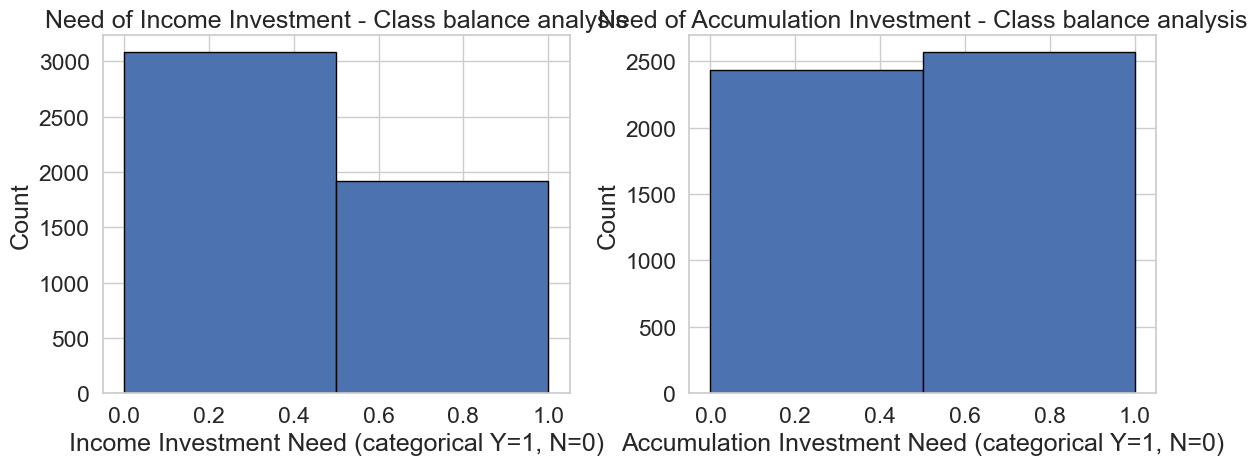

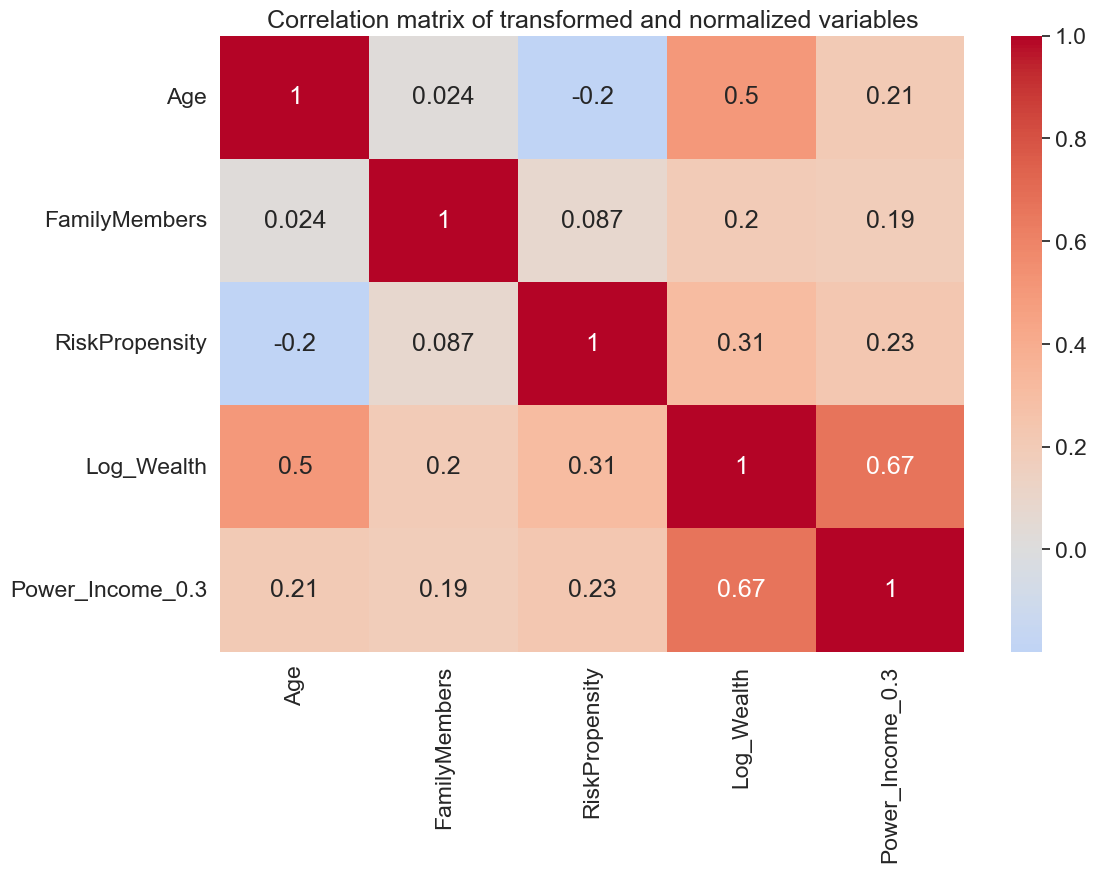

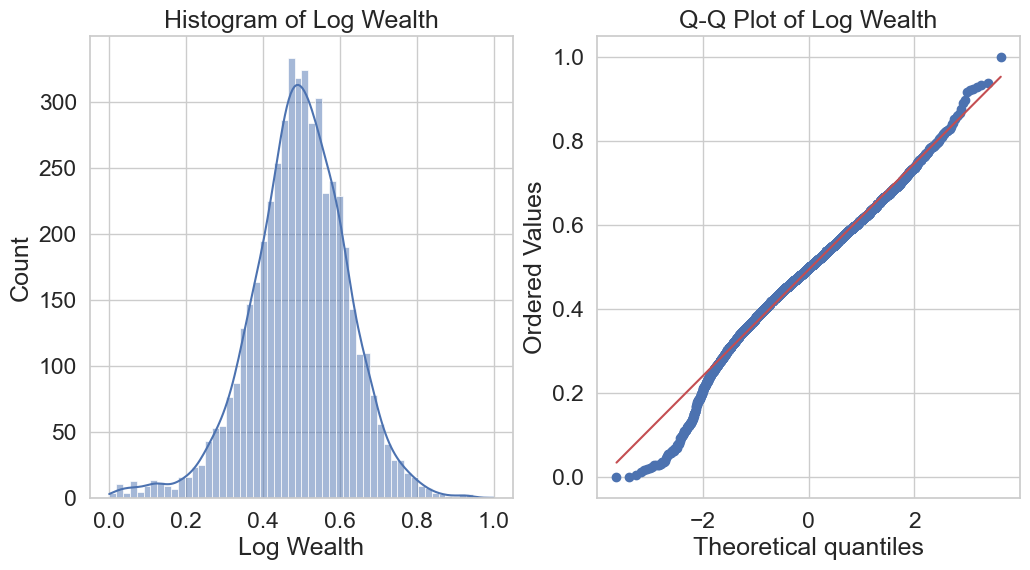

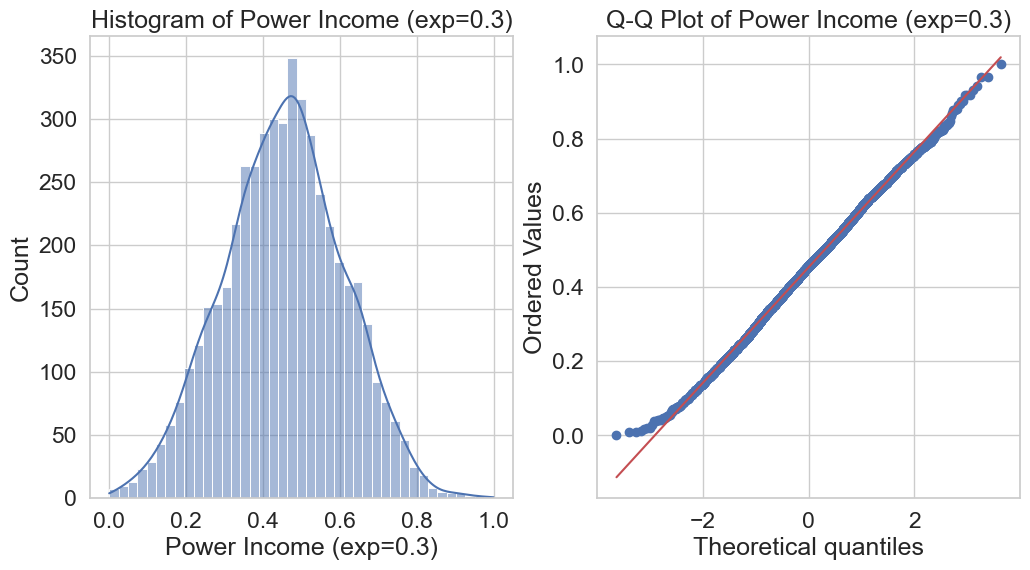

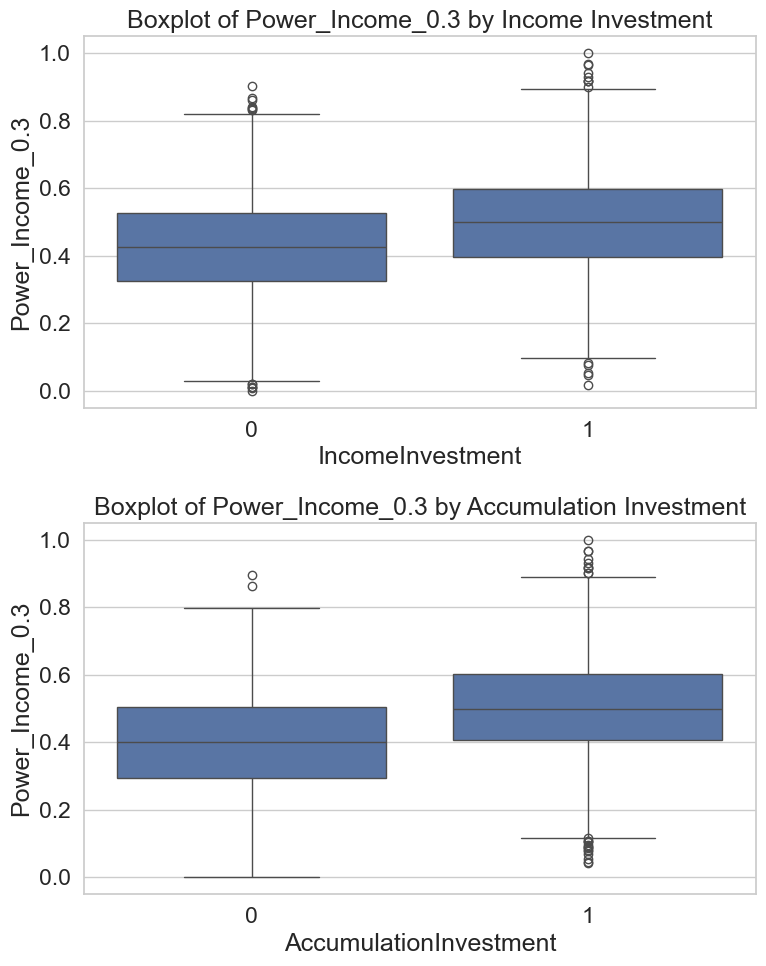

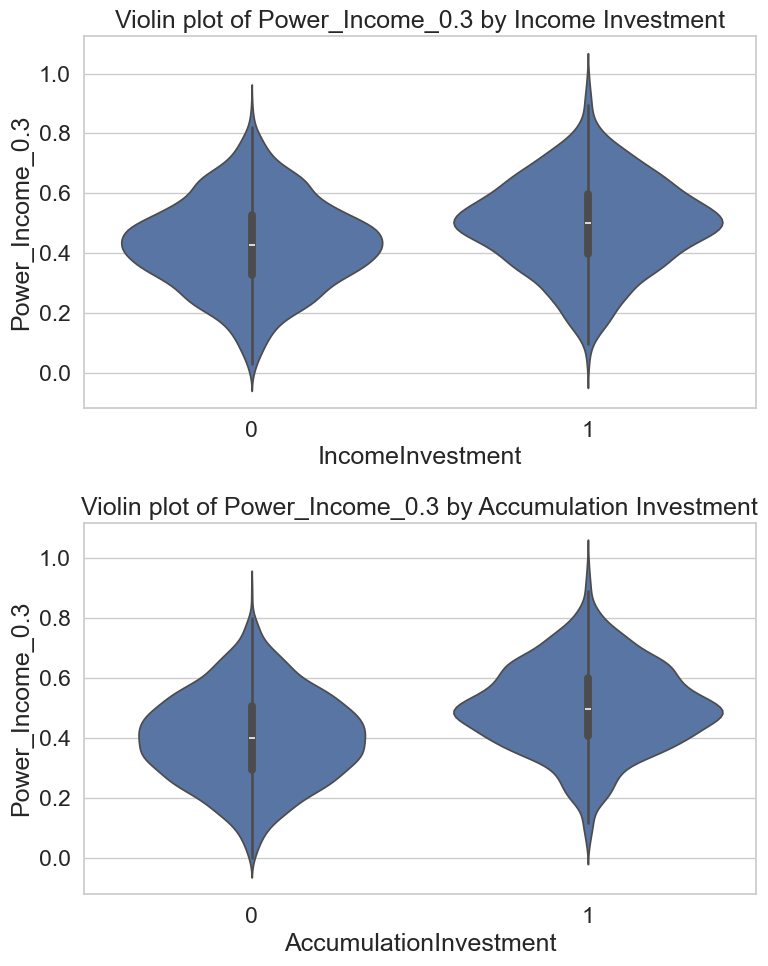

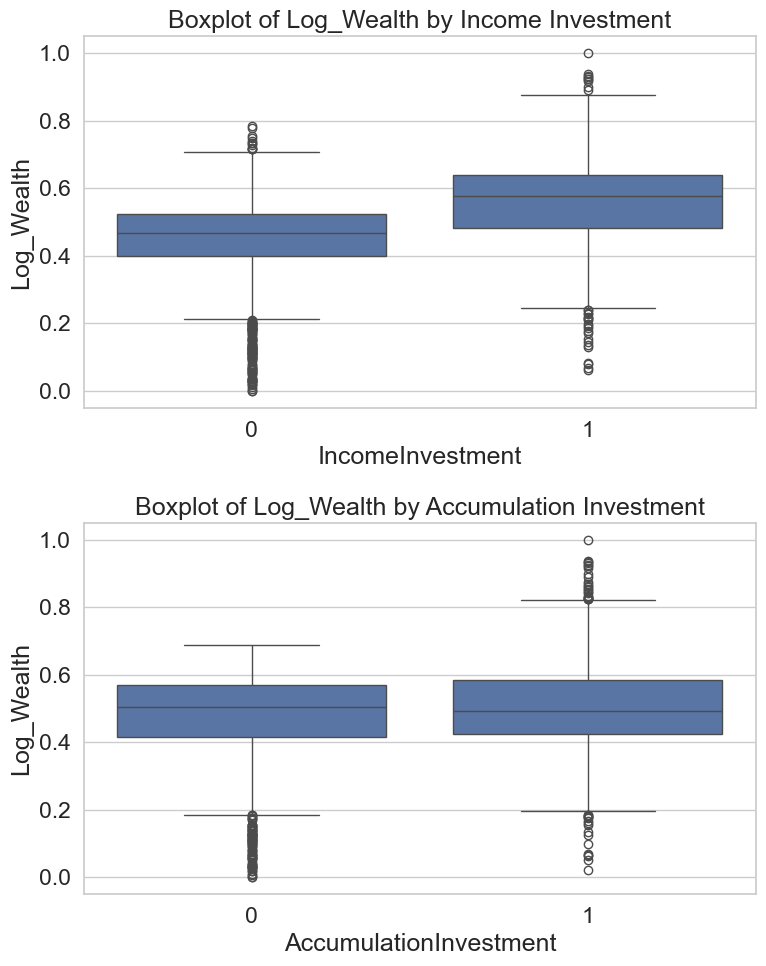

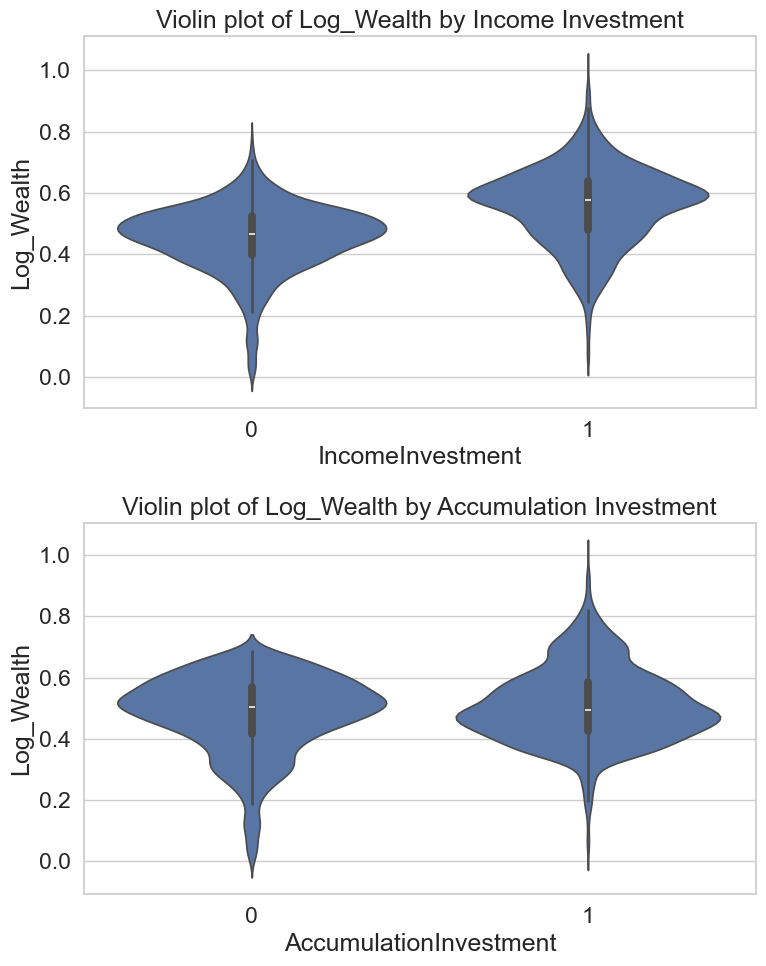

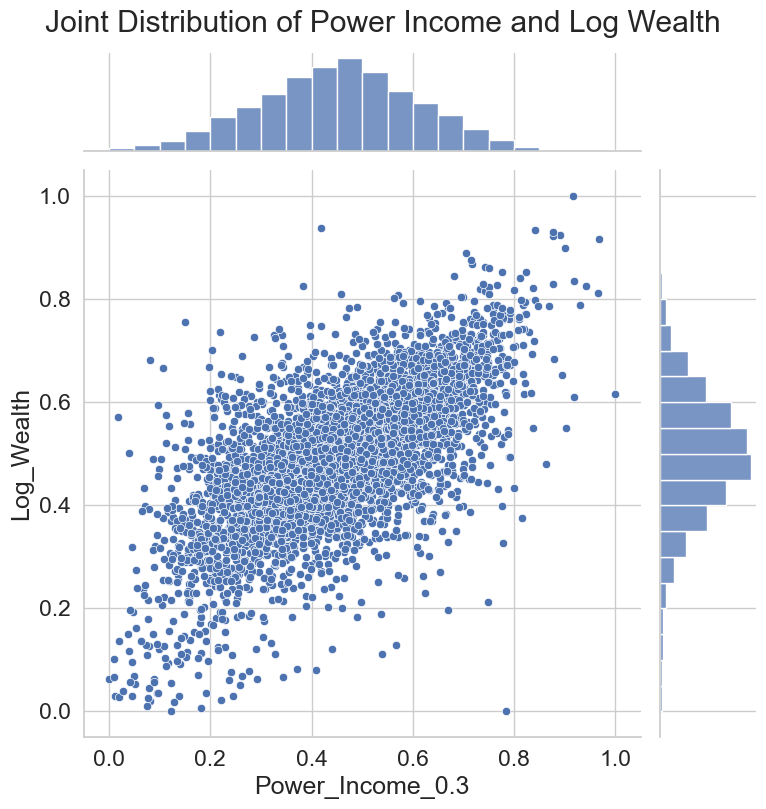

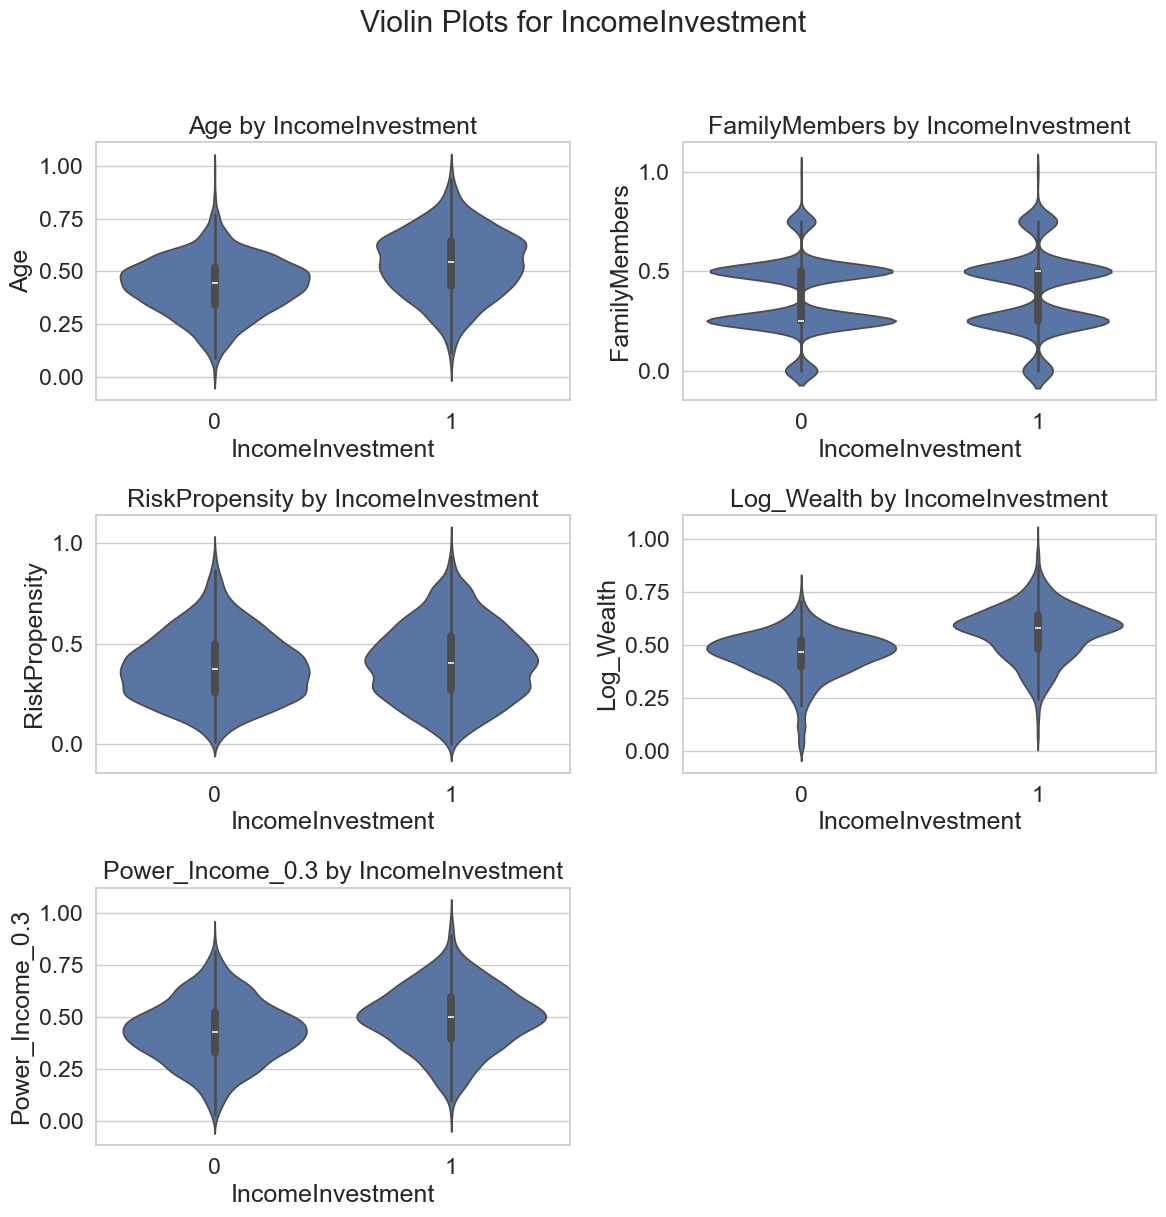

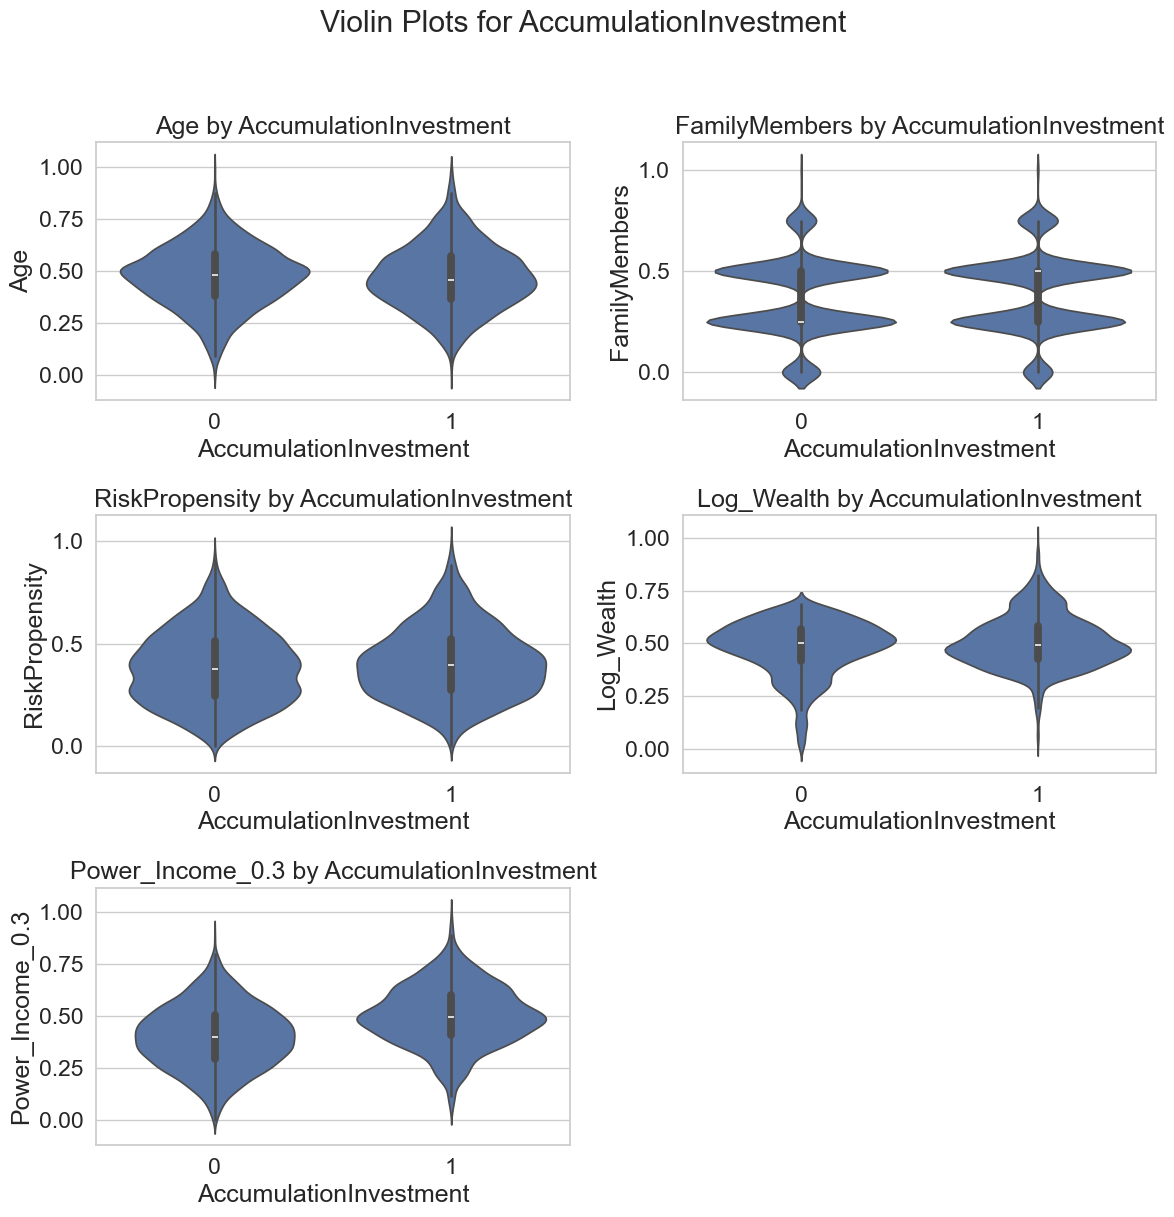

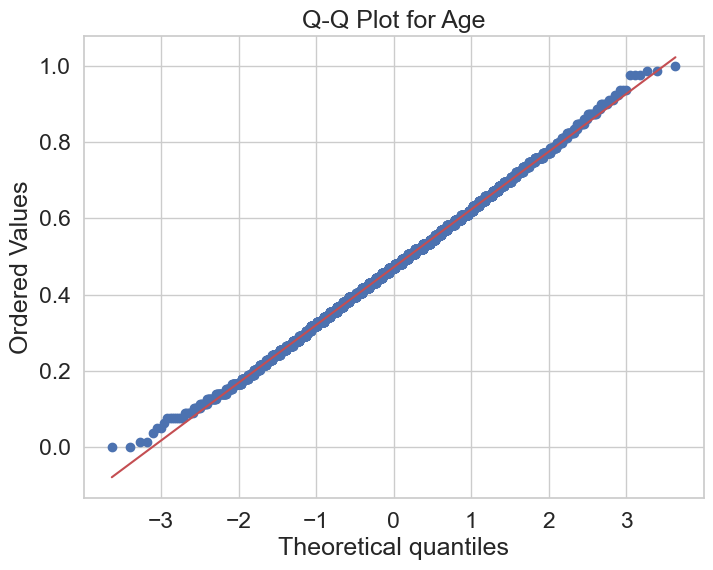

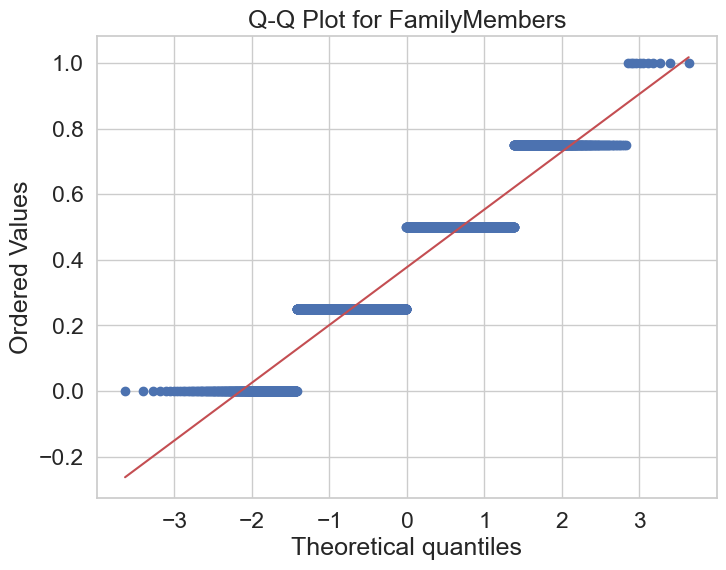

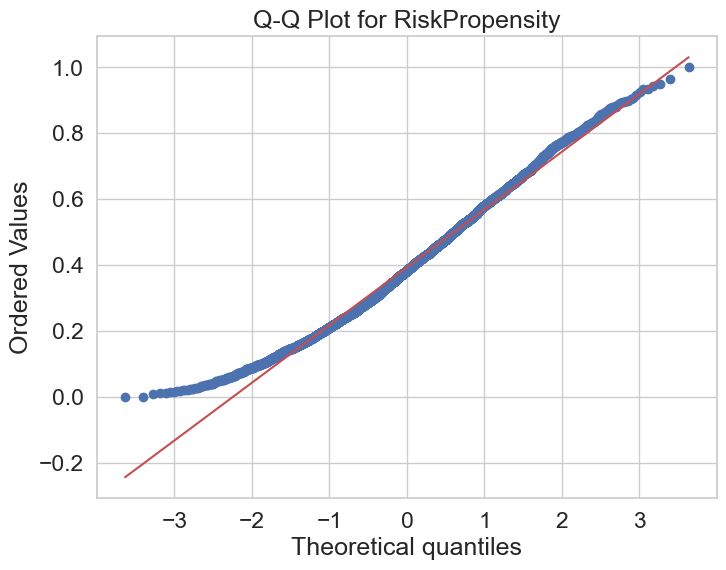

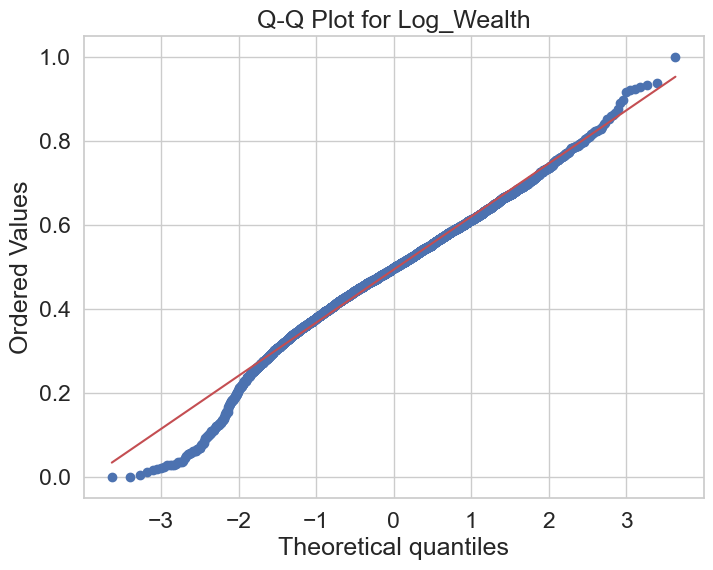

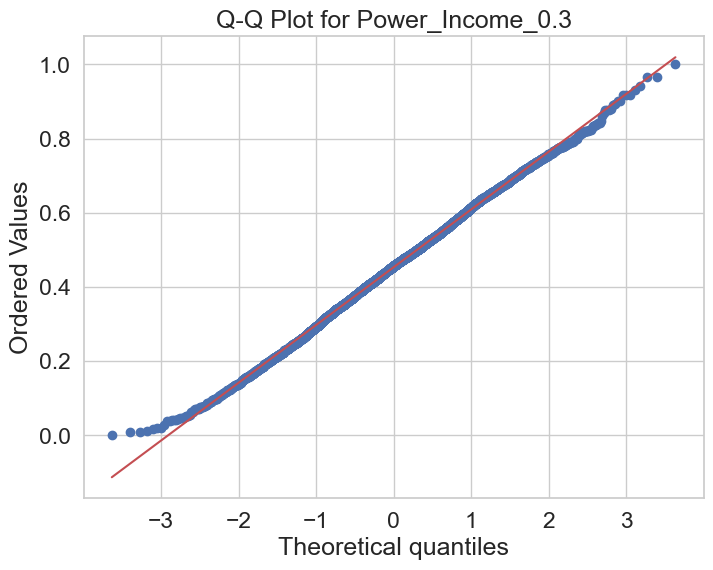

In [58]:
# Peform the EDA
pred.eda()

<a id="sec-23-predictor-train"></a>
## 2.3 Predictor Joint Training & Evaluation

This step jointly trains and evaluates the **multi-output classifier** for the target variables (`IncomeInvestment` and `AccumulationInvestment`) using:

- Cross-validation for robust performance estimation.
- Custom threshold (`τ`) selection to fine-tune binary classification decisions.
- Test set evaluation to assess generalization performance.
- Model and thresholds are saved for future predictions.

Optimal τ for AccumulationInvestment: 0.494
Optimal τ for IncomeInvestment: 0.515

Random Forest - AccumulationInvestment
+---+----------------+---------+--------+----------+
|   |     Metric     | CV Mean | CV Std | Test Set |
+---+----------------+---------+--------+----------+
| 0 |    Accuracy    |  0.791  | 0.025  |   0.8    |
| 1 |   Precision    |  0.833  | 0.017  |   0.84   |
| 2 |     Recall     |  0.742  | 0.035  |  0.751   |
| 3 |       F1       |  0.785  | 0.027  |  0.793   |
| 4 | Custom Penalty |  0.144  | 0.018  |  0.138   |
+---+----------------+---------+--------+----------+

Random Forest - IncomeInvestment
+---+----------------+---------+--------+----------+
|   |     Metric     | CV Mean | CV Std | Test Set |
+---+----------------+---------+--------+----------+
| 0 |    Accuracy    |  0.803  | 0.015  |  0.801   |
| 1 |   Precision    |  0.83   | 0.017  |   0.84   |
| 2 |     Recall     |  0.615  | 0.024  |  0.591   |
| 3 |       F1       |  0.706  | 0.016  |  0.693 

<Figure size 600x600 with 0 Axes>

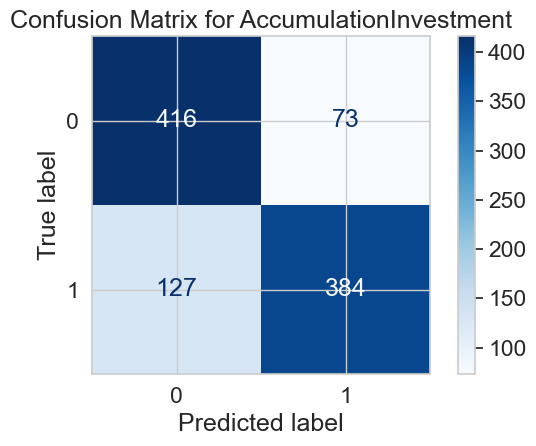

<Figure size 600x600 with 0 Axes>

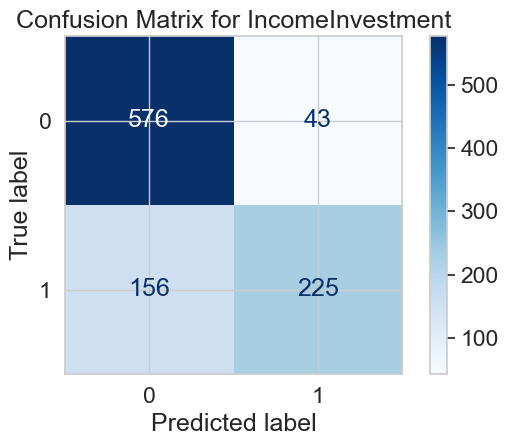

In [59]:
cv_report, test_report, tau_dict = pred.train_evaluate_joint()

<a id="sec-24-predictor-expl"></a>
## 2.4 Predictor Explanatory Part

Generates visual **SHAP** and **LIME** explanations for each target variable.  
- SHAP plots highlight feature importance and impacts across the test dataset.  
- LIME explanations provide instance-level interpretability for individual predictions.



Explaining target: AccumulationInvestment


<Figure size 1000x800 with 0 Axes>

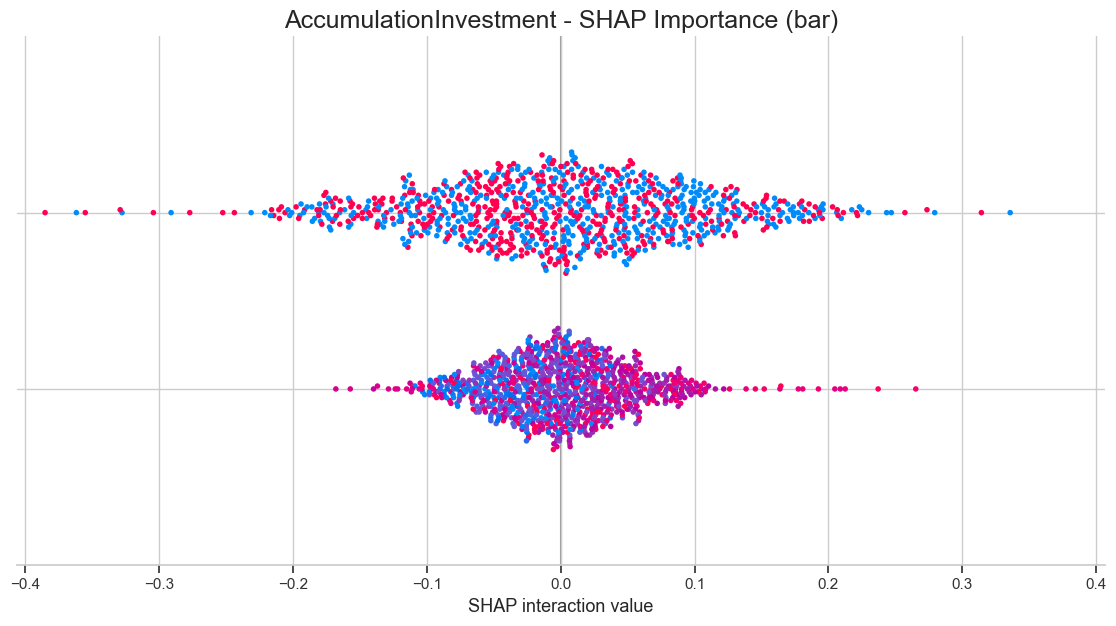

<Figure size 1000x800 with 0 Axes>

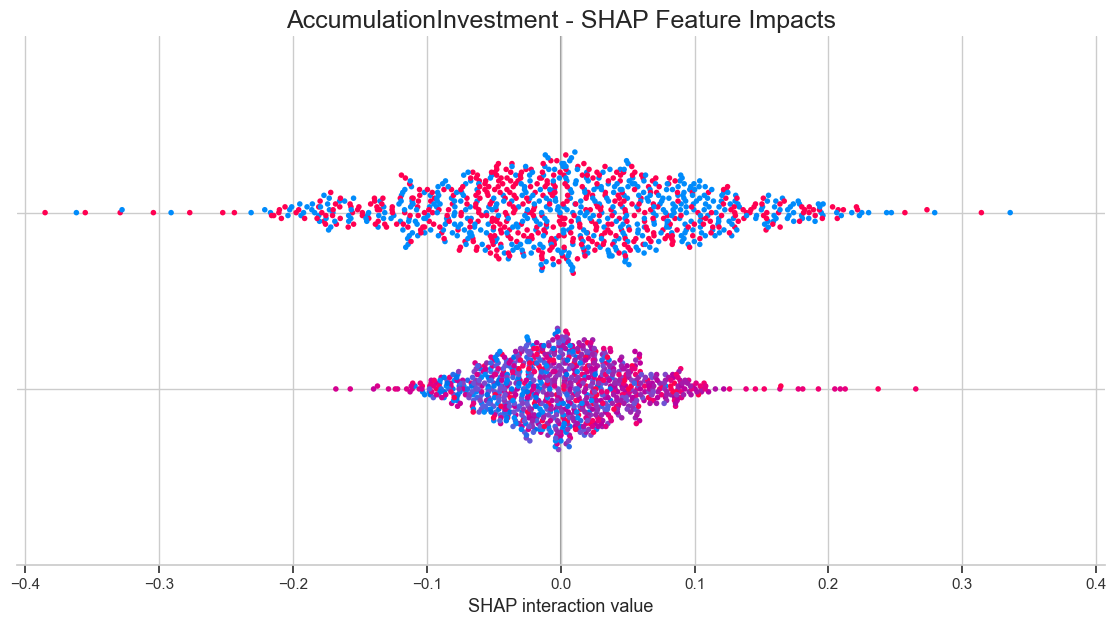

c:\GitHub\Fintech_group13\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


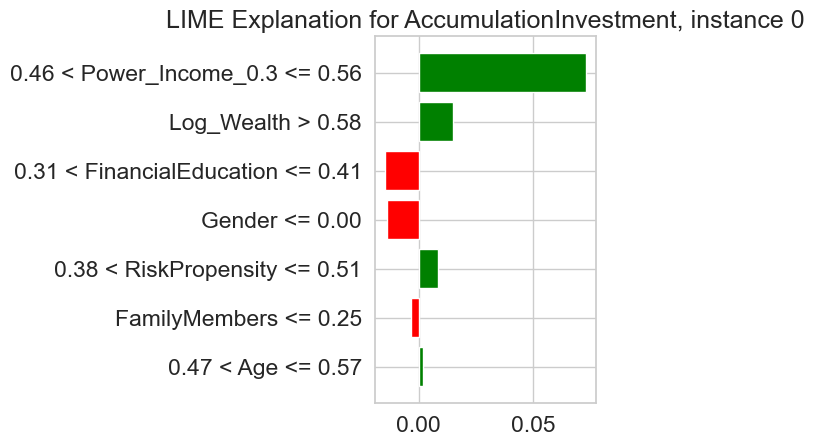


Explaining target: IncomeInvestment


<Figure size 1000x800 with 0 Axes>

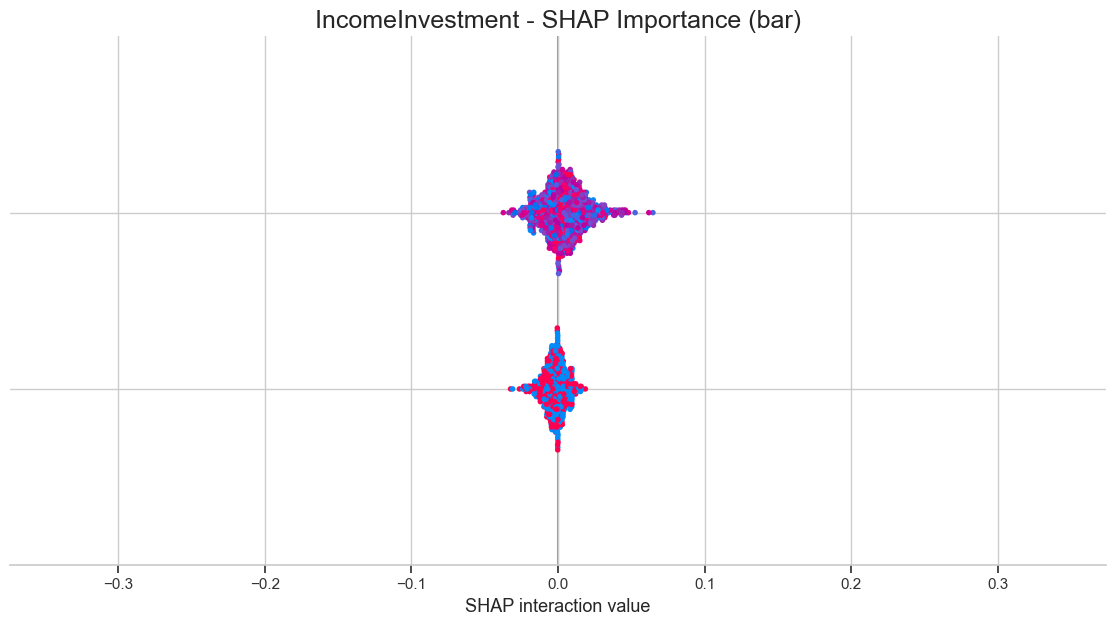

<Figure size 1000x800 with 0 Axes>

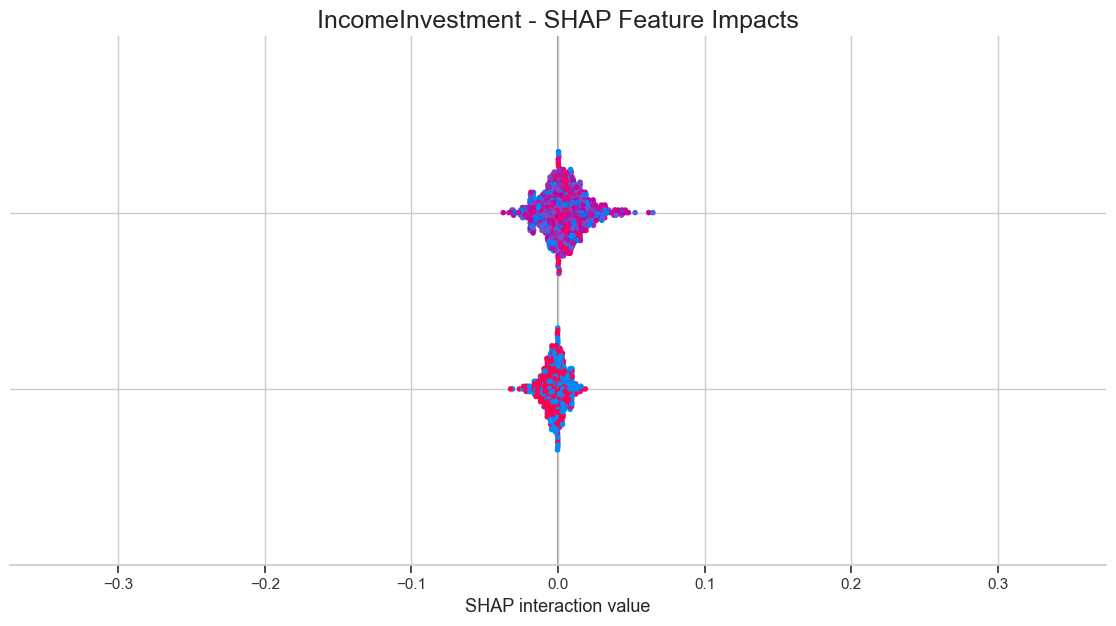

c:\GitHub\Fintech_group13\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


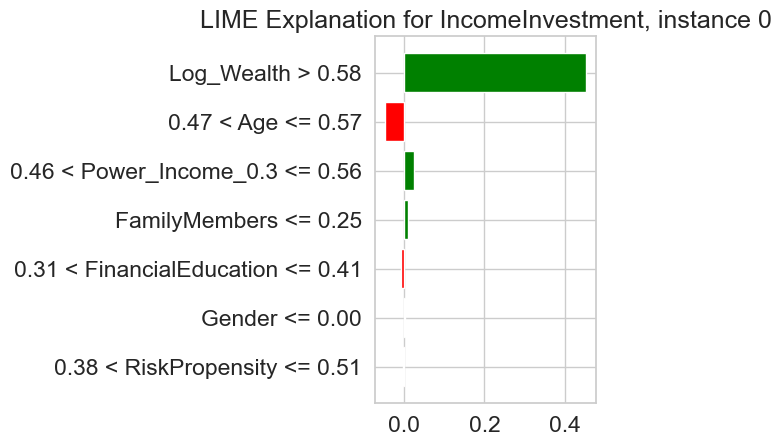

In [60]:
pred.explainability()

---

<a id="sec-3-replica"></a>
# 3. Replica

This section implements a comprehensive workflow for **replicating and evaluating portfolio strategies**. The process begins by selecting the desired portfolio configuration from three distinct investment approaches:

1. **Equity Portfolio**:  
   Focuses on replicating a broad equity index, specifically the `MXWO Index` (MSCI World), to capture global stock market performance.
   
2. **Bond Portfolio**:  
   Targets the fixed-income segment through the `LEGATRUU Index`, representing global bond market exposure.
   
3. **LifeStrategy 80/20 Portfolio**:  
   Represents a balanced approach by combining both equity (`MXWO Index`) and bond (`LEGATRUU Index`) exposures at equal weights (50/50 split), reflecting a diversified strategic allocation.

After selecting the target portfolio, the script loads and preprocesses the data, including historical asset prices and risk metrics. The portfolio replication strategies are then applied using multiple models:

- **Equally Weighted Portfolio** (as a baseline),
- **Elastic Net** (with hyperparameter tuning via Optuna),
- **Kalman Filter**,
- **Ensemble Kalman Filter**.

Each approach’s results are thoroughly analyzed through:

-  Detailed performance metrics (annualized returns, volatility, Sharpe ratio, maximum drawdown, tracking error, information ratio, correlation, average VaR, etc.),

- Visualization of cumulative returns and normalized equity curves,

- Discrete rebalancing analysis considering transaction costs and turnover (Total Expense Ratio),

- Comparison of alternative portfolio performance during periods flagged as anomalies by detection models.

This integrated and modular framework provides a robust toolkit for portfolio construction, evaluation, and anomaly-aware analysis, supporting informed decision-making across different market conditions and investment strategies.

<br>

<br>


<a id="sec-30-replica-intro"></a>
## 3.0 Replica Introduction - Data Loading and Preprocessing

This block sets up the environment and loads the dataset containing historical market data. It configures the target portfolio (`Equity`, `Bond`, or `LifeStrategy 80/20`), determines the corresponding index components, and initializes essential variables such as VaR parameters and transaction costs for further portfolio replication analysis.


In [61]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Load the dataset from an Excel file
path_Dataset3 = 'Dataset3_PortfolioReplicaStrategyErrataCorrige.xlsx' # Dataset

# Get current working directory
current_dir = os.getcwd()

# Add the path to the dataset
file_path = os.path.join(current_dir, "Datasets", path_Dataset3)

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path)
# metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# SET EDA_FLAG TRUE to perform exploratory data analysis
EDA_flag = False

# Set the number of trials for the optimization process, if 0 the model run on the trained data
n_trials = 0

In [62]:
# Read the Excel file, and save the names of the assets (row 4)
full_names_df = pd.read_excel(file_path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(file_path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(file_path, header=None, skiprows=6)

# cut the data before the 01/01/2017 
data_raw = data_raw[data_raw[0] >= '2013-01-01']  # Filter rows based on the date column

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# Create a dictionary to hold the index components based on the selected portfolio, and a DataFrame to hold the target data
if selected_flag == 1: # Portfolio Equity
    # EQUITY ETF
    index_components = {
        'MXWO Index': 1
    }
    df_target = data[['MXWO Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters - in the equity case, we assume a higher risk profile
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.12  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 2: # Portfolio Bond
    # BOND ETF
    index_components = {
        'LEGATRUU Index': 1
    }
    df_target = data[['LEGATRUU Index']].copy()  # Select the 'LEGATRUU Index' column for further processing
    
    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 3: # Portfolio LifeStrategy 80/20
    # LIFE STRATEGY ETF
    index_components = {
        'MXWO Index': 0.8,
        'LEGATRUU Index': 0.2,
    }
    df_target = data[['MXWO Index', 'LEGATRUU Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)
else:
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio.")

# Create a DataFrame to hold the the underlyings
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]
df_underlyings = data[futures_contracts].copy()  # Create an empty DataFrame to hold the underlyings

# Set the transaction costs based on the selected portfolio
if selected_flag == 1:  # Portfolio Equity
    transaction_cost = 0.0005  # 0.05% transaction costs for equity
elif selected_flag == 2:
    transaction_cost = 0.0
elif selected_flag == 3:
    transaction_cost = 0.0005
else:
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio.")


annual_factor = 52  # Number of weeks in a year, to be set following the data frequency

# Create a dictionary to hold the VaR parameters
var_parameters = {
    'var_confidence': var_confidence,
    'var_horizon': var_horizon,
    'max_var_threshold': max_var_threshold
}

index_name_str = ', '.join(index_components.keys())

#### Import and Initialize PortfolioReplicator

This block imports the custom `PortfolioReplicator` class from the helper module and initializes an instance with the selected target portfolio, index components, underlying data, risk parameters, and transaction costs. This sets the stage for portfolio replication and performance evaluation.


In [63]:
# Helper module import
import sys
import os

# Get the current working directory (for Jupyter notebooks)
current_dir = os.getcwd()
# Define the relative path to the helper directory
helper_dir = os.path.join(current_dir, "PortfolioReplica")
# Add the helper directory to sys.path if not already there
if helper_dir not in sys.path:
    sys.path.append(helper_dir)

from ReplicaClass import PortfolioReplicator

# Create an instance of the PortfolioReplicator class with the selected parameters
rep = PortfolioReplicator(df_target, index_components, df_underlyings, 
                          var_parameters, transaction_cost, annual_factor, name = f"{get_selected_portfolio()}")


<a id="sec-31-replica-eda"></a>
## 3.1 Portfolio Replica EDA

This section performs **exploratory data analysis** on the selected target portfolio and its underlyings. The EDA includes plotting cumulative returns, investigating correlations, visualizing return distributions and log returns, as well as checking for normality and stationarity. Set `EDA_flag = True` to enable this analysis and gain deeper insights into the dataset.


In [64]:
# EDA_flag = True -> perform exploratory data analysis
if EDA_flag:
    # Plot cumulative returns for the target and underlyings
    rep.plot_cumulative_returns()

    # Display the financial statistics for the target and underlyings
    target_fin_stats, underlyings_fin_stats = rep.fin_stats()
    display(target_fin_stats)
    display(underlyings_fin_stats)

    # Plot the correlation map for the target and underlyings
    rep.corr_map()

    # Plot the distribution of returns for the target and underlyings
    rep.return_distribution()

    # Plot the log returns for the target and underlyings
    rep.plot_log_returns()

    # Plot the rolling correlation between the target and underlyings
    rolling_window = 52  # 1 year rolling window
    rep.plot_rolling_correlation(window=rolling_window)

    # Plot the bar correlation between the target and underlyings
    rep.bar_corr_target_underlyings()

    # Perform normality and stationarity checks
    rep.normality_check()
    rep.stationarity_check()
    
else:
    print("Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.")

Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.


<a id="sec-32-replica-ewptf"></a>
## 3.2 Equally Weighted Portfolio Replication

In this section, we implement and evaluate an equally weighted portfolio replication strategy using the `PortfolioReplicator` class. The model assigns equal weights to all underlying assets over a rolling window and aims to replicate the performance of the selected target portfolio.

The code below:
- Runs the equally weighted portfolio strategy with a specified rolling window.
- Computes key performance metrics such as information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average Value at Risk (VaR).
- Displays a summary table comparing the replica portfolio to the target portfolio across several risk and return metrics.
- Visualizes the results to provide a baseline for comparison with more advanced replication methods.

This equally weighted approach serves as a benchmark to assess the effectiveness of more sophisticated portfolio replication techniques introduced later in the notebook.


Metrics for Equally Weighted Portfolio:


information_ratio  correlation  tracking_error  replica_sharpe  \
0          -0.531319     0.826816         0.08671        0.888259   

   avg_gross_exposure  avg_var  
0                 1.0      NaN


Detailed metrics for Equally Weighted vs Target:


Metric  Target Replica
0       Annualized return  12.99%   8.38%
1   Annualized volatility  14.66%   9.44%
2            Sharpe ratio    0.89    0.89
3            Max Drawdown  28.04%  17.36%
4          Tracking Error     N/A   8.67%
5       Information ratio     N/A   -0.53
6             Correlation     N/A  0.8268
7  Average gross exposure     N/A  1.0000
8    Average VaR (1%, 1M)     N/A    nan%

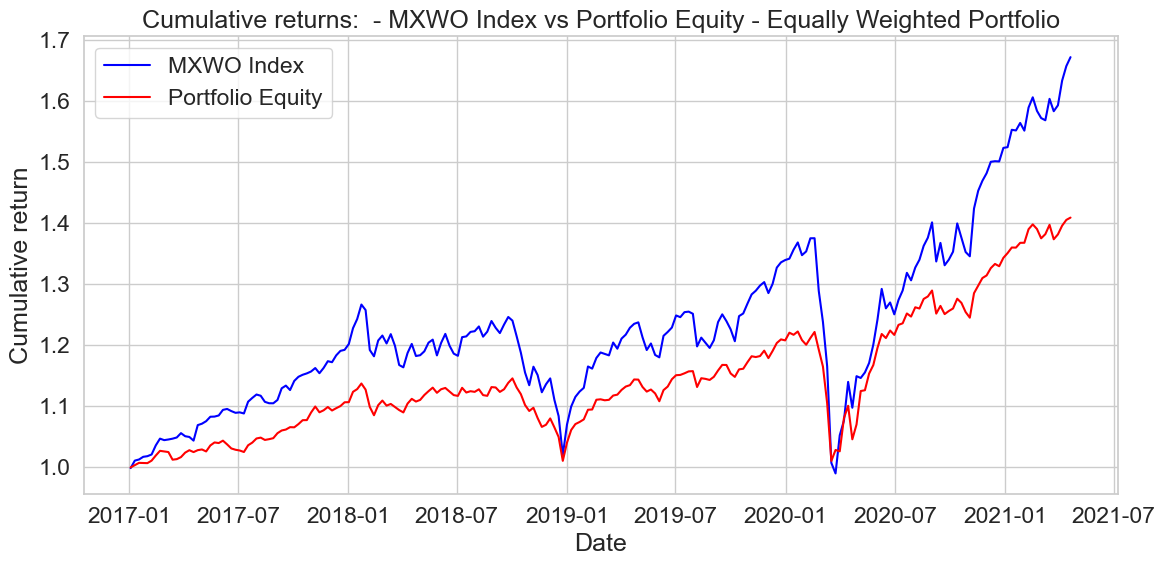

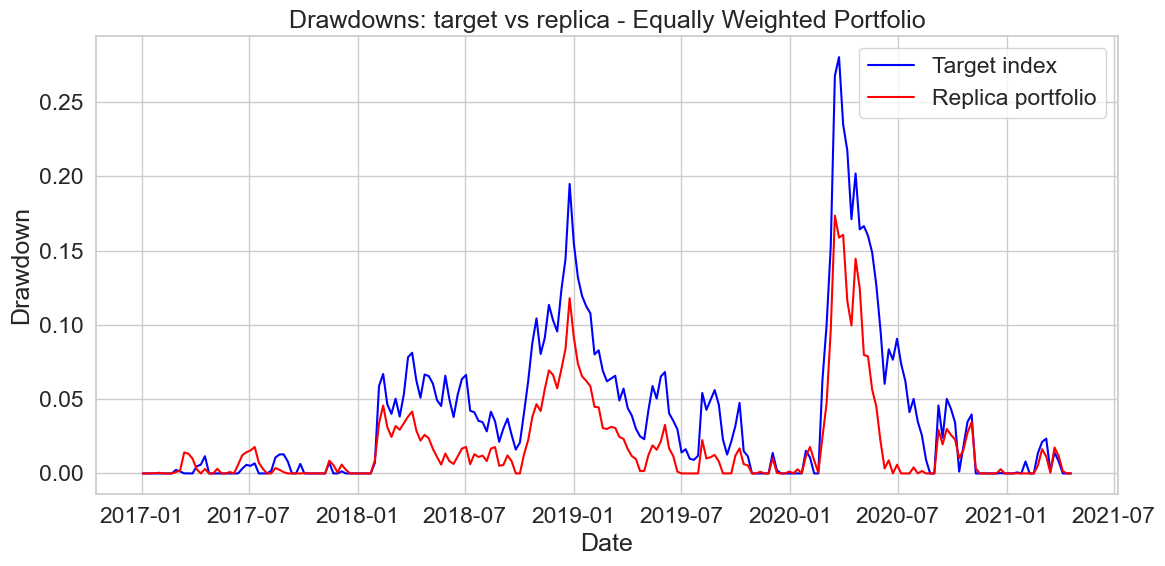

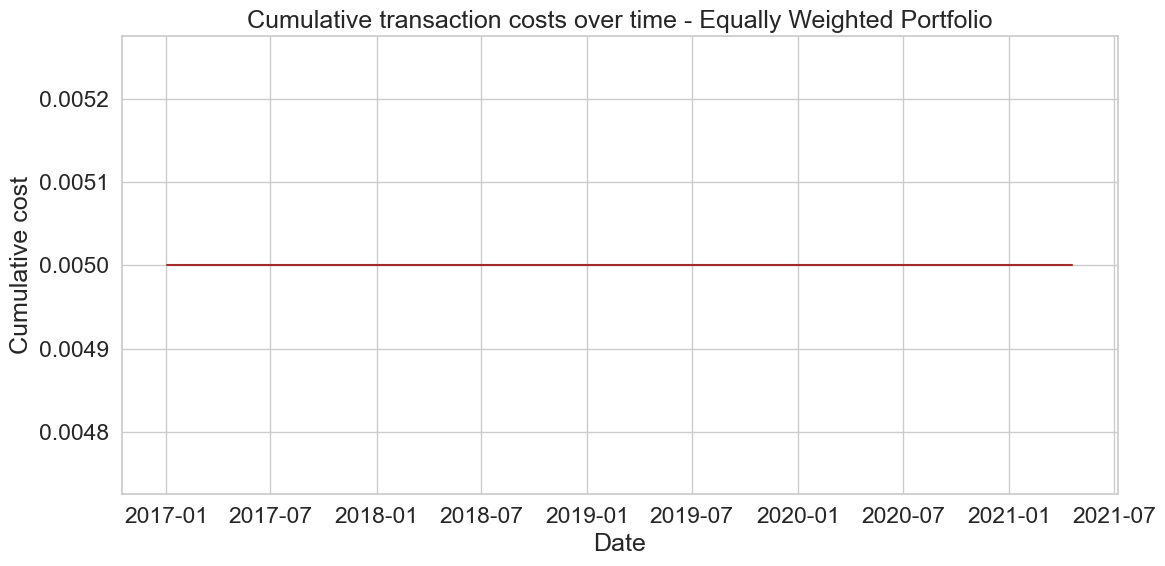

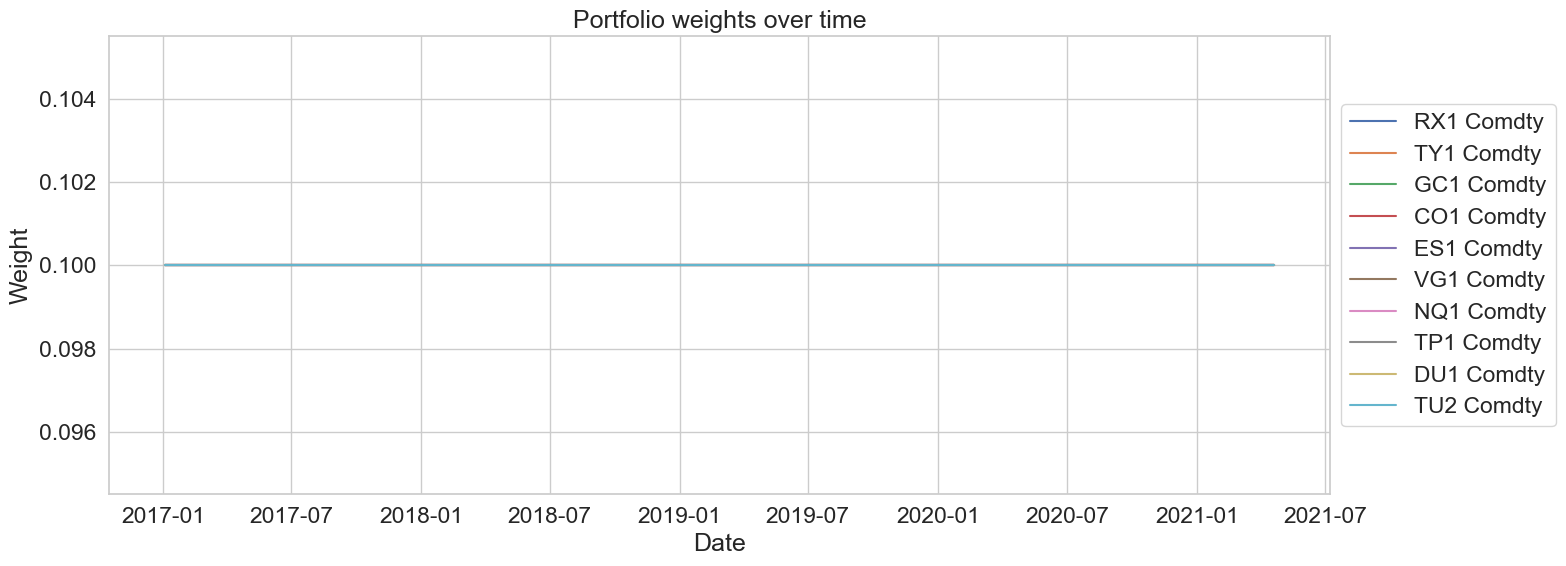

In [65]:
# Param
window = 208

results_equal_weighted = rep.run_equal_weight_portfolio(window)

# Create a DataFrame for the results
result_equal_weighted_df = pd.DataFrame([results_equal_weighted])

# Display the results
print("\nMetrics for Equally Weighted Portfolio:")
display(result_equal_weighted_df[['information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))
 
# Extract the first row for detailed metrics
result_equal_weighted_df = result_equal_weighted_df.iloc[0]

# Create detailed metrics table for the LR configuration
metrics_normalized_equal_weighted = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{result_equal_weighted_df['target_return']*100:.2f}%",
               f"{result_equal_weighted_df['target_vol']*100:.2f}%",
               f"{result_equal_weighted_df['target_sharpe']:.2f}",
               f"{result_equal_weighted_df['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{result_equal_weighted_df['replica_return']*100:.2f}%",
                f"{result_equal_weighted_df['replica_vol']*100:.2f}%",
                f"{result_equal_weighted_df['replica_sharpe']:.2f}",
                f"{result_equal_weighted_df['max_drawdown']*100:.2f}%",
                f"{result_equal_weighted_df['tracking_error']*100:.2f}%",
                f"{result_equal_weighted_df['information_ratio']:.2f}",
                f"{result_equal_weighted_df['correlation']:.4f}",
                f"{result_equal_weighted_df['avg_gross_exposure']:.4f}",
                f"{result_equal_weighted_df['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for Equally Weighted vs Target:")
display(metrics_normalized_equal_weighted)

# Plot the results for the Linear Regression model
rep.plot_metrics(result_equal_weighted_df, 'Equally Weighted Portfolio')

<a id="sec-33-replica-en"></a>
## 3.3 Elastic Net Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the Elastic Net regression model. Elastic Net is a regularized regression technique that linearly combines the penalties of Lasso (L1) and Ridge (L2) methods. This approach is particularly useful when dealing with highly correlated features, as it encourages both sparsity and grouping effects in the portfolio weights.

**Theory Snapshot:**  
Elastic Net regression solves the following optimization problem:

$$
\min_{\beta} \left\{ \frac{1}{2n} \| y - X\beta \|^2_2 + \alpha \left( \lambda \|\beta\|_1 + \frac{1-\lambda}{2} \|\beta\|_2^2 \right) \right\}
$$

where $\alpha$ controls the overall strength of regularization and $\lambda$ determines the mix between L1 and L2 penalties.

**What this cell does:**
- Runs an Optuna hyperparameter search to find the best Elastic Net configuration for portfolio replication.
- Trains the Elastic Net model using the optimal parameters.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Elastic Net-based replica portfolio.

This method provides a more flexible and potentially more robust alternative to the equally weighted benchmark, especially in the presence of multicollinearity among the underlying assets.

In [66]:
# 3) Run Optuna search, depending on the selected portfolio we differentiate the storage aand name of the study
name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EN_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EN_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / f"PortfolioReplica/{folder_name}"
storage_dir.mkdir(parents=True, exist_ok=True)

# 2) build the full sqlite URL
storage_path = f"./PortfolioReplica/{folder_name}/{storage_name}"

study_EN = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj = rep._optuna_objective_EN
)


Top Optuna configuration by information ratio:


l1_ratio  rolling_window     alpha  information_ratio  correlation  \
0   0.99991             208  0.007887           0.354087     0.955391   

   tracking_error  replica_sharpe  avg_gross_exposure  avg_var  
0        0.044039        1.102278            0.856044  0.07555


Detailed metrics for the best configuration (normalized returns):


Metric  Target Replica
0       Annualized return  12.99%  14.55%
1   Annualized volatility  14.66%  13.20%
2            Sharpe ratio    0.89    1.10
3            Max Drawdown  28.04%  20.15%
4          Tracking Error     N/A   4.40%
5       Information ratio     N/A    0.35
6             Correlation     N/A  0.9554
7  Average gross exposure     N/A  0.8560
8    Average VaR (1%, 1M)     N/A   7.55%

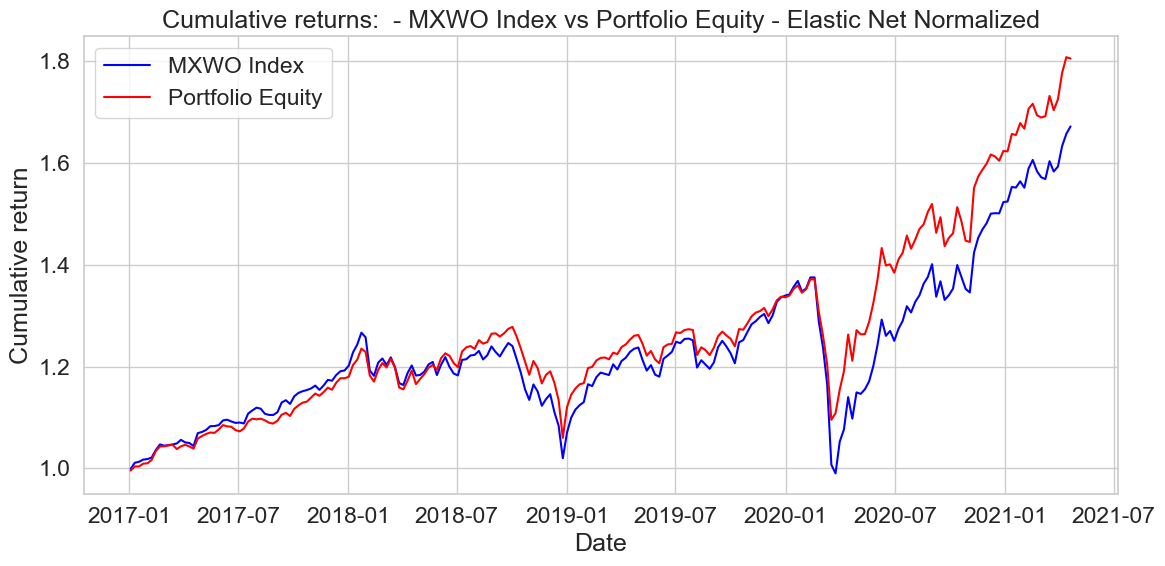

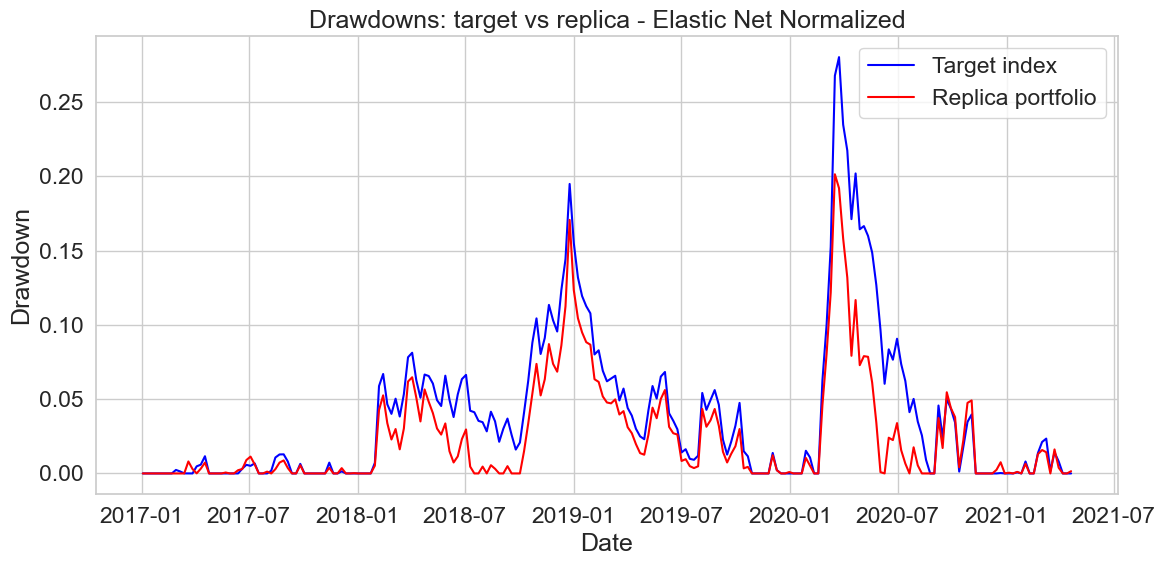

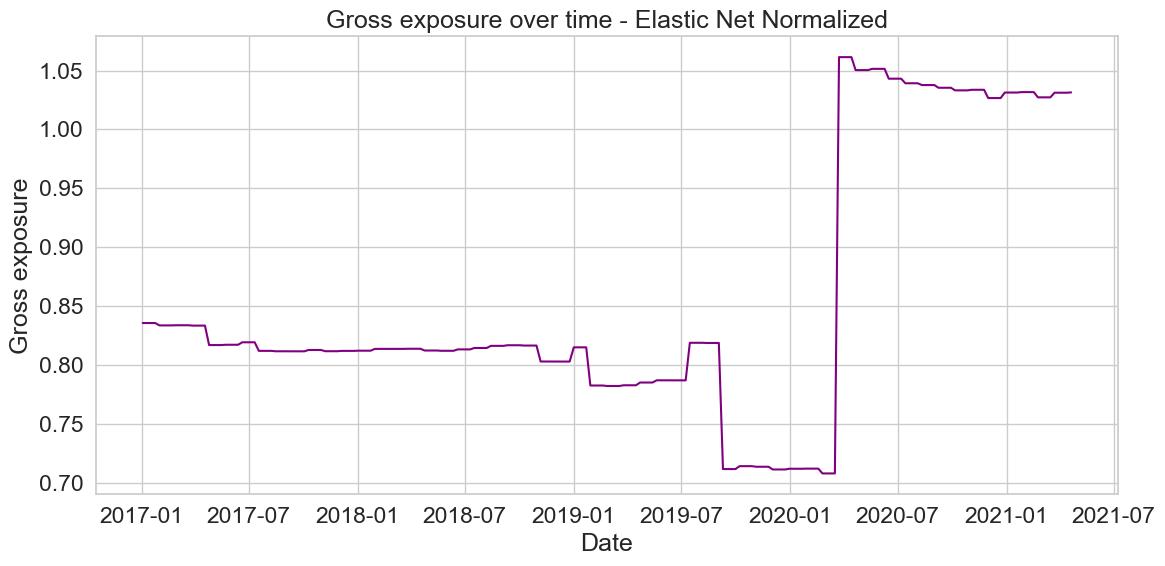

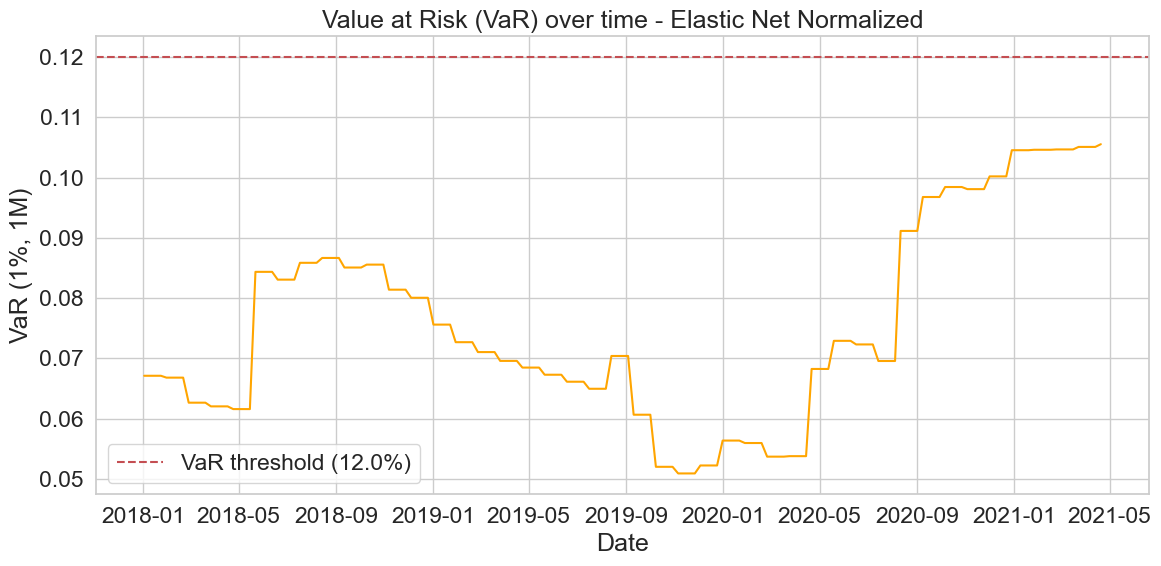

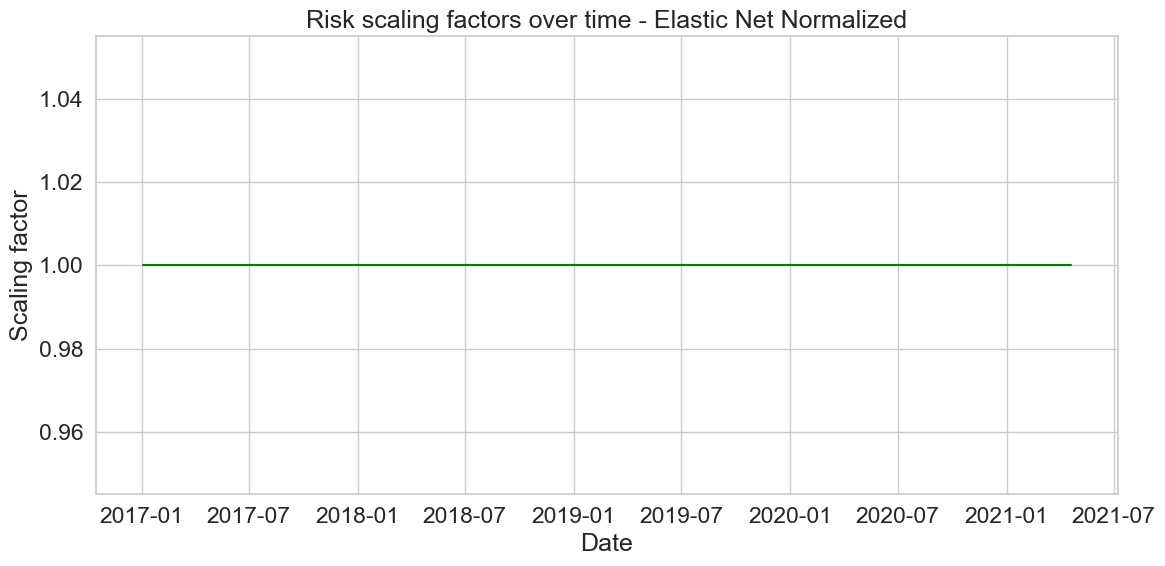

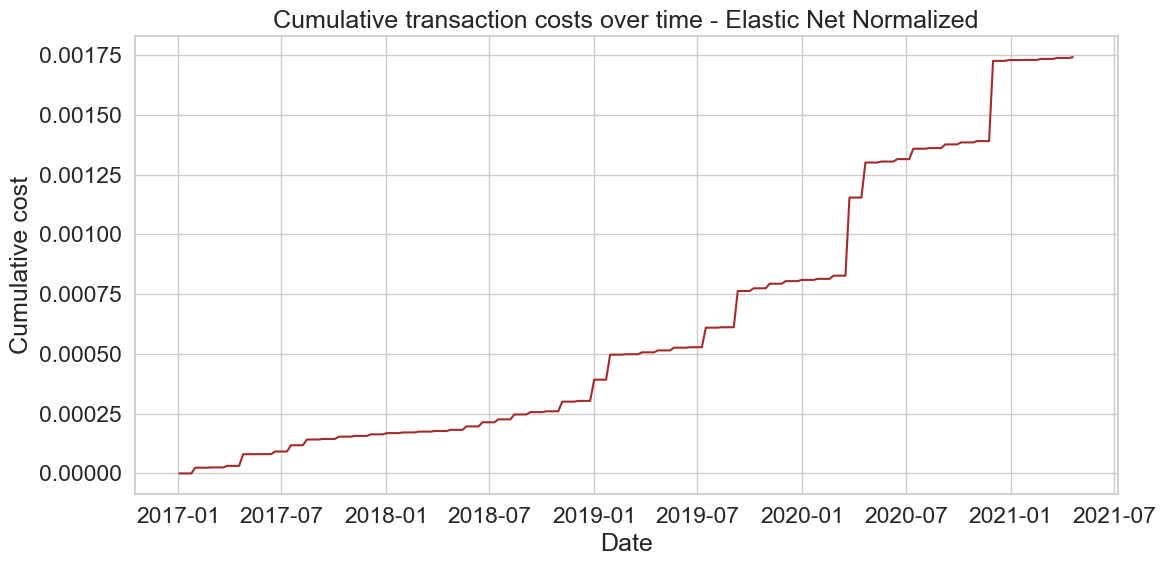

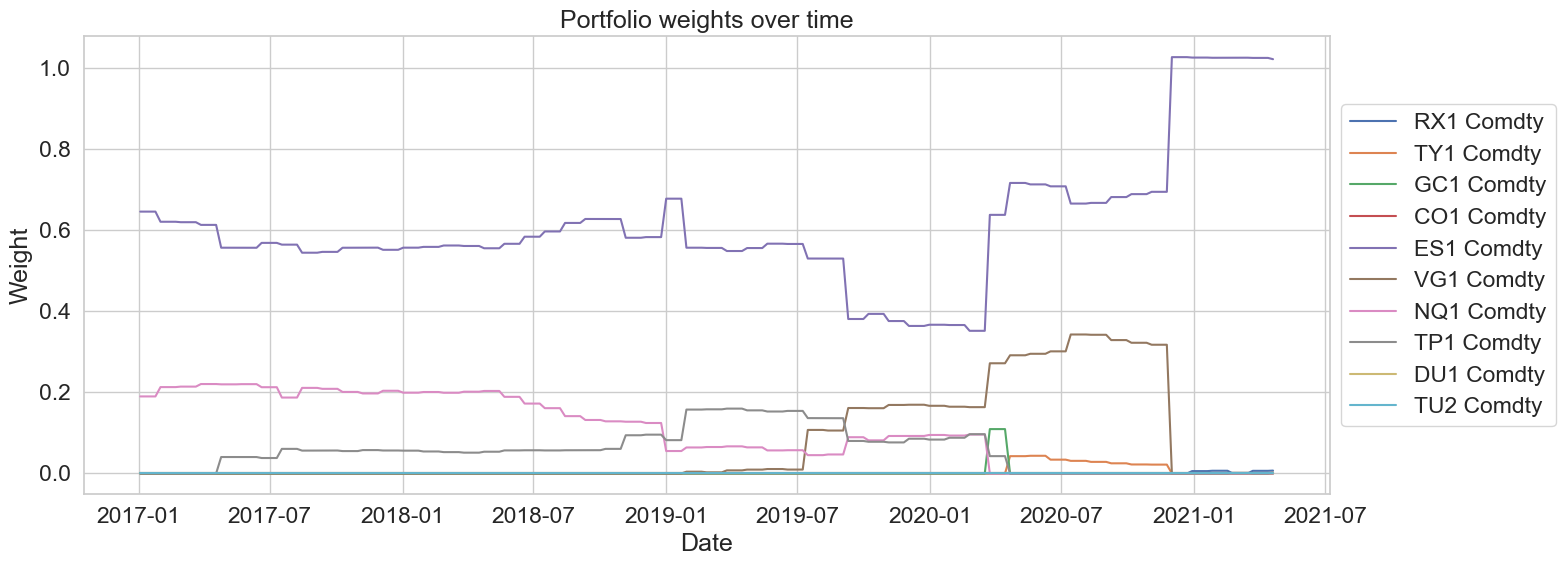

In [67]:
results_normalized_EN = []

best = study_EN.best_params
l1_ratio = best["l1_ratio"]
rolling_window = best["rolling_window"]
alpha = best["alpha"]
rebalancing_window = best["rebalancing_window"]

results_EN = rep.run_elasticnet_normalized(l1_ratio, rolling_window, alpha,rebalancing_window)
results_normalized_EN.append(results_EN)

# Convert results to DataFrame for easier analysis
results_df_normalized_EN = pd.DataFrame(results_normalized_EN)

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(results_df_normalized_EN[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

best_config_normalized_EN = results_df_normalized_EN.iloc[0]

# Create detailed metrics table for the best configuration
metrics_normalized_EN = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_EN['target_return']*100:.2f}%",
               f"{best_config_normalized_EN['target_vol']*100:.2f}%",
               f"{best_config_normalized_EN['target_sharpe']:.2f}",
               f"{best_config_normalized_EN['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_EN['replica_return']*100:.2f}%",
                f"{best_config_normalized_EN['replica_vol']*100:.2f}%",
                f"{best_config_normalized_EN['replica_sharpe']:.2f}",
                f"{best_config_normalized_EN['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_EN['tracking_error']*100:.2f}%",
                f"{best_config_normalized_EN['information_ratio']:.2f}",
                f"{best_config_normalized_EN['correlation']:.4f}",
                f"{best_config_normalized_EN['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_EN['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_EN)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_EN, 'Elastic Net Normalized')

<a id="sec-34-replica-kf"></a>
## 3.4 Kalman Filter Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the Kalman Filter model. The Kalman Filter is a recursive algorithm that estimates the state of a dynamic system from a series of noisy measurements. In the context of portfolio replication, it is used to dynamically estimate and update the optimal portfolio weights over time, adapting to changing market conditions.

**Theory Snapshot:**  
The Kalman Filter operates in two main steps: prediction and update. It predicts the next state (portfolio weights) based on the previous state and then updates this prediction using new observed data (asset returns). This approach allows for real-time tracking and adjustment of portfolio weights, making it well-suited for financial time series that exhibit non-stationarity and noise.

**What this cell does:**
- Runs the Kalman Filter-based portfolio replication model with specified rolling and rebalancing windows.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Kalman Filter-based replica portfolio.

This method provides a dynamic and adaptive alternative to static or regression-based approaches, potentially improving replication accuracy in volatile or evolving markets.


Top Optuna configuration by information ratio:


information_ratio  correlation  tracking_error  replica_sharpe  \
0          -0.439961     0.996949         0.01146        0.857925   

   avg_gross_exposure   avg_var  
0             1.27354  0.073572


Detailed metrics for the best configuration (normalized returns):


Metric  Target Replica
0       Annualized return  12.99%  12.49%
1   Annualized volatility  14.66%  14.55%
2            Sharpe ratio    0.89    0.86
3            Max Drawdown  28.04%  27.98%
4          Tracking Error     N/A   1.15%
5       Information ratio     N/A   -0.44
6             Correlation     N/A  0.9969
7  Average gross exposure     N/A  1.2735
8    Average VaR (1%, 1M)     N/A   7.36%

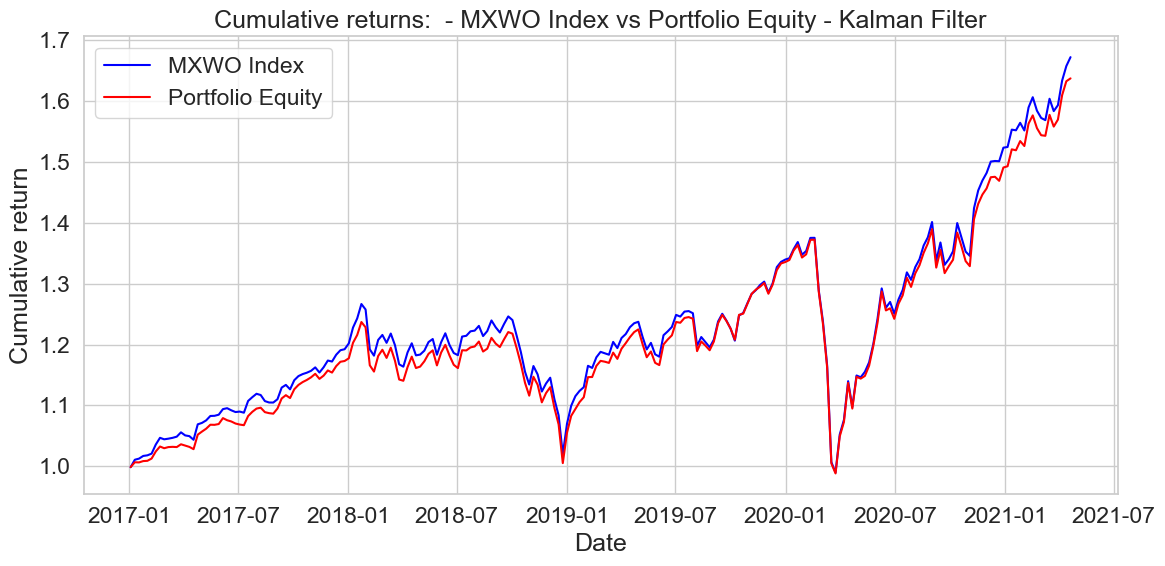

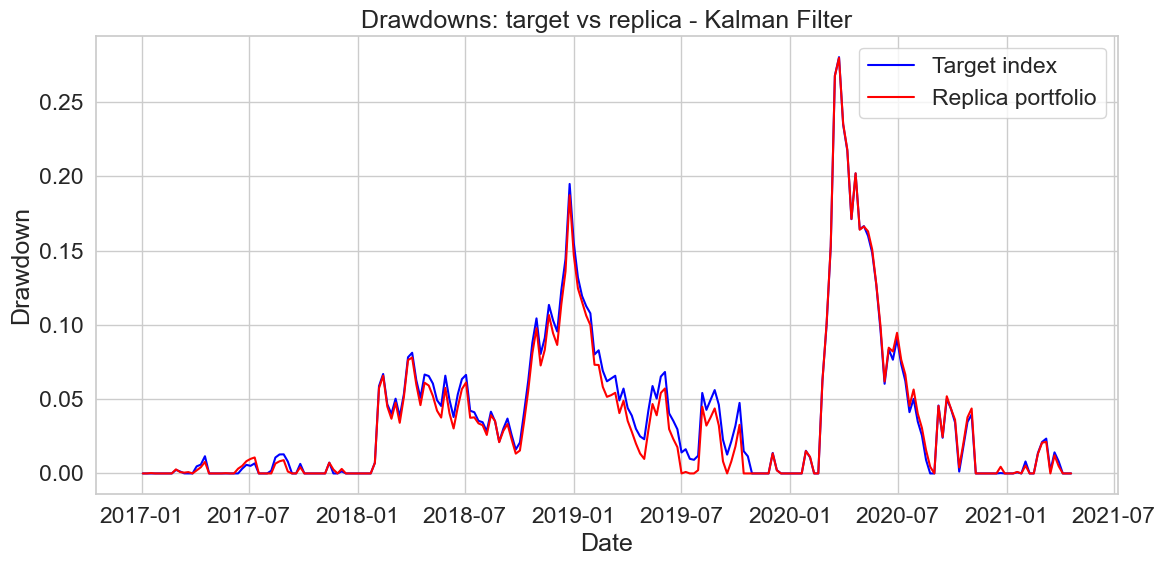

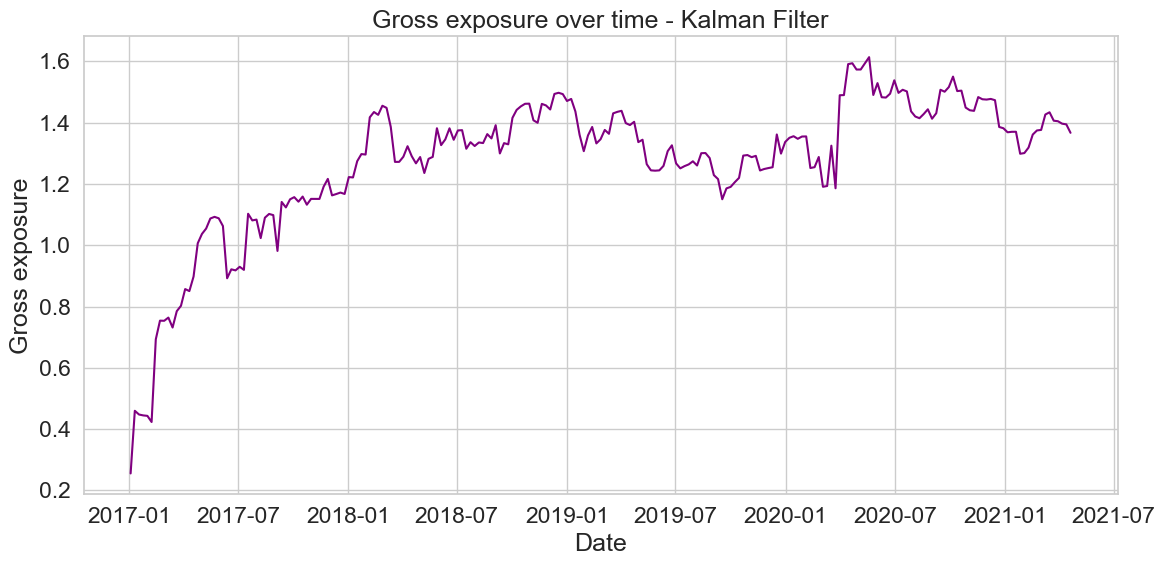

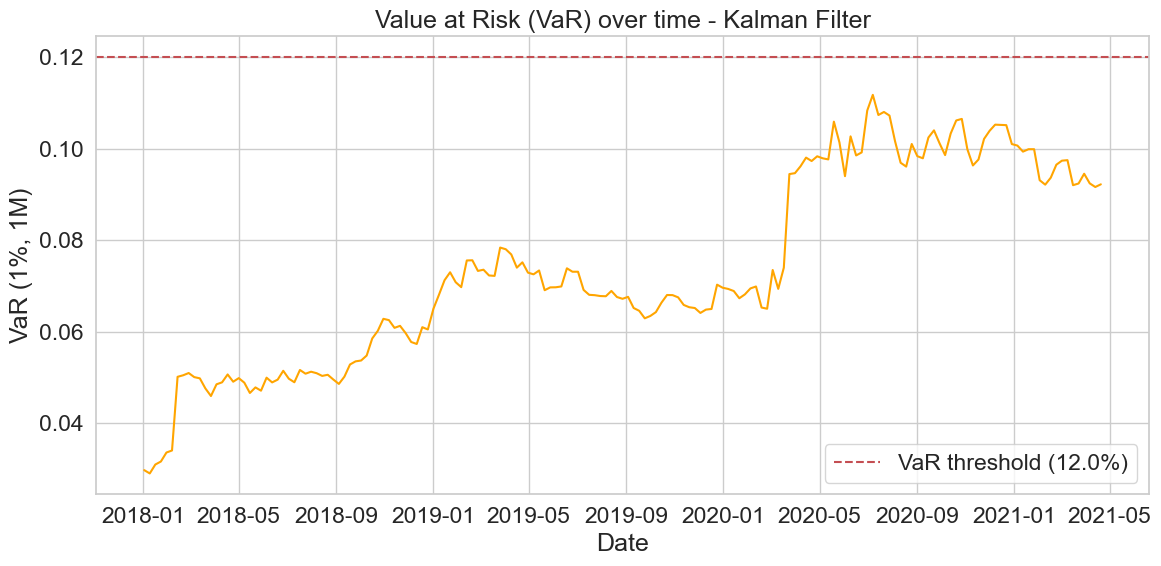

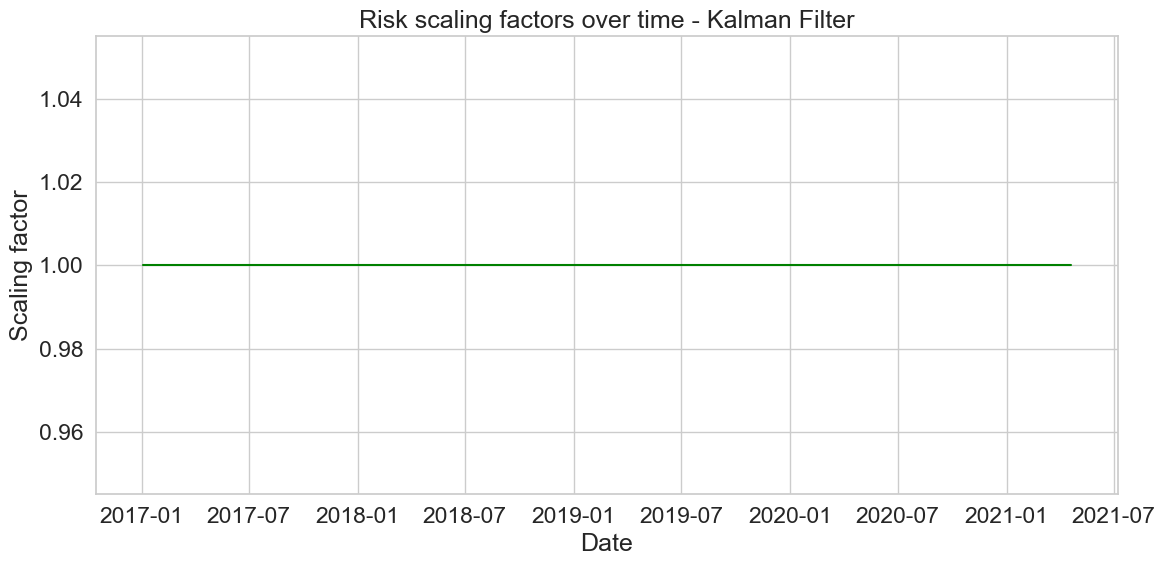

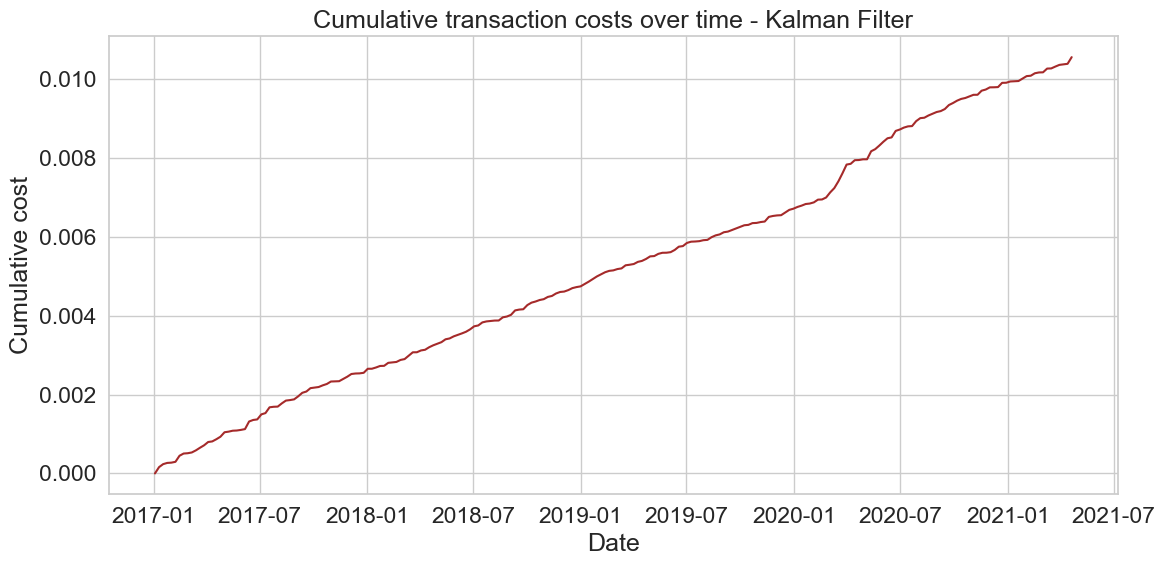

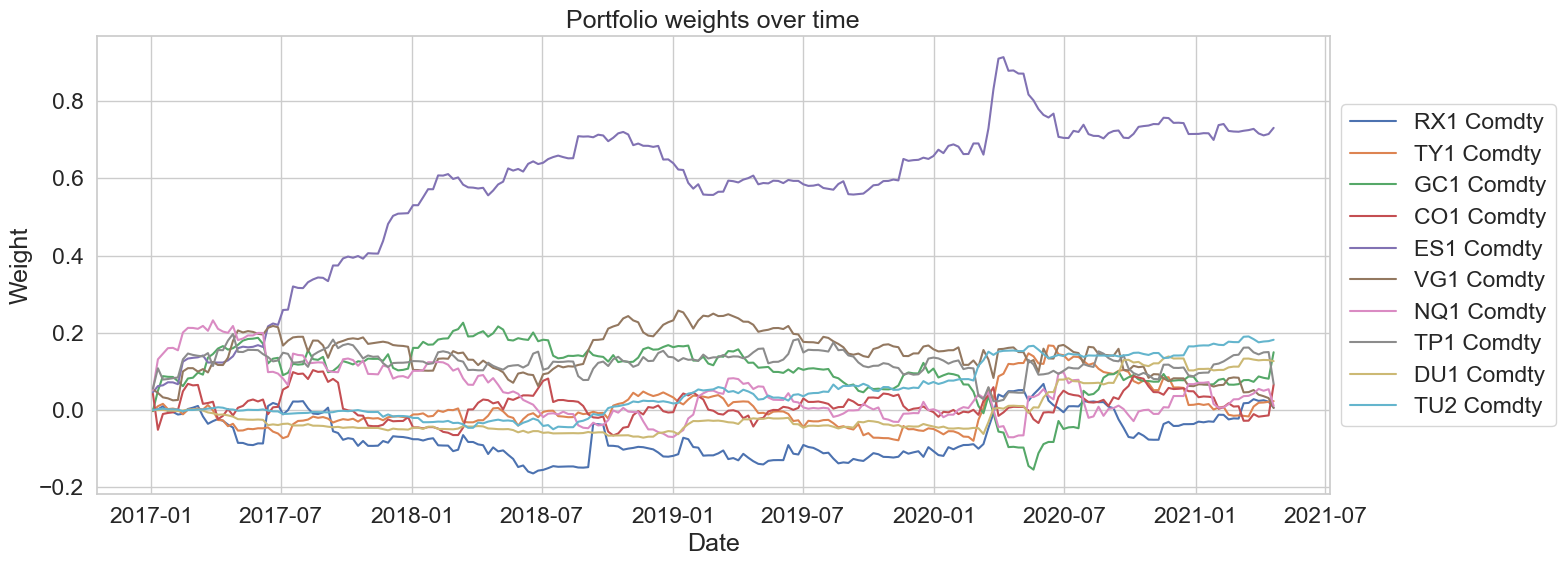

In [68]:
# Run the Kalman filter model
result_KF = rep.run_kalman_filter_model(
    rolling_window=208,               # 1 year rolling window
    rebalancing_window=1            # Weekly rebalancing
)

# Create a DataFrame for the results
result_KF_df = pd.DataFrame([result_KF])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KF_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KF = result_KF_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KF = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KF['target_return']*100:.2f}%",
               f"{best_config_normalized_KF['target_vol']*100:.2f}%",
               f"{best_config_normalized_KF['target_sharpe']:.2f}",
               f"{best_config_normalized_KF['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KF['replica_return']*100:.2f}%",
                f"{best_config_normalized_KF['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KF['replica_sharpe']:.2f}",
                f"{best_config_normalized_KF['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KF['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KF['information_ratio']:.2f}",
                f"{best_config_normalized_KF['correlation']:.4f}",
                f"{best_config_normalized_KF['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KF['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KF)


# Display the results
rep.plot_metrics(result_KF, 'Kalman Filter')

<a id="sec-35-replica-ekf"></a>
## 3.5 Ensemble Kalman Filter Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the **Ensemble Kalman Filter (EnKF)** model. The EnKF is an advanced extension of the standard Kalman Filter, designed to handle non-linearities and model uncertainties by propagating an ensemble (collection) of possible state vectors (here, portfolio weights) through time.

**Theory Snapshot:**  
The Ensemble Kalman Filter works by maintaining a set of possible weight vectors (the ensemble), each of which evolves over time according to a random-walk process (process noise). At each rebalancing step:
- Each ensemble member is updated using new observed data (asset returns) via a Kalman update, which adjusts the weights based on the observed error.
- The ensemble mean and covariance are used to estimate the current optimal portfolio weights and their uncertainty.
- This approach allows the model to adapt dynamically to changing market conditions, capturing both the mean and the uncertainty of the optimal weights.

Key steps in the implementation:
- **Initialization:** The process starts with a Ridge regression on the initial rolling window to set the starting weights.
- **Ensemble Propagation:** At each rebalancing date, the weights are updated using the Kalman filter equations, with process noise injected to simulate uncertainty and allow for exploration of different possible weight paths.
- **Observation Update:** The filter incorporates the latest observed return, updating the ensemble of weights accordingly.
- **VaR Scaling:** If the Value at Risk (VaR) exceeds a threshold, the weights are scaled down to control risk.
- **Transaction Costs:** The model accounts for transaction costs based on the turnover in weights.
- **Holding Weights:** On non-rebalancing days, the previous weights are held constant.

**What this cell does:**
- Runs an Optuna hyperparameter search to find the best configuration for the Ensemble Kalman Filter (ensemble size, process noise scale, rolling and rebalancing windows).
- Trains the EnKF model using the optimal parameters.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Ensemble Kalman Filter-based replica portfolio.

This method provides a robust and flexible alternative to traditional Kalman Filter and regression-based approaches, especially in environments with high uncertainty, non-linearity, and time-varying relationships between assets.

In [69]:

name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EKF_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EKF_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / f"PortfolioReplica/{folder_name}"
storage_dir.mkdir(parents=True, exist_ok=True)

storage_path = f"./PortfolioReplica/{folder_name}/{storage_name}"

# 3) Run Optuna search
study_KFE = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj=rep._optuna_objective_KFE
)


Top Optuna configuration by information ratio:


information_ratio  correlation  tracking_error  replica_sharpe  \
0          -0.310062     0.973269        0.034431        0.880113   

   avg_gross_exposure   avg_var  
0            1.300922  0.070663


Detailed metrics for the best configuration (normalized returns):


Metric  Target Replica
0       Annualized return  12.99%  11.92%
1   Annualized volatility  14.66%  13.55%
2            Sharpe ratio    0.89    0.88
3            Max Drawdown  28.04%  23.87%
4          Tracking Error     N/A   3.44%
5       Information ratio     N/A   -0.31
6             Correlation     N/A  0.9733
7  Average gross exposure     N/A  1.3009
8    Average VaR (1%, 1M)     N/A   7.07%

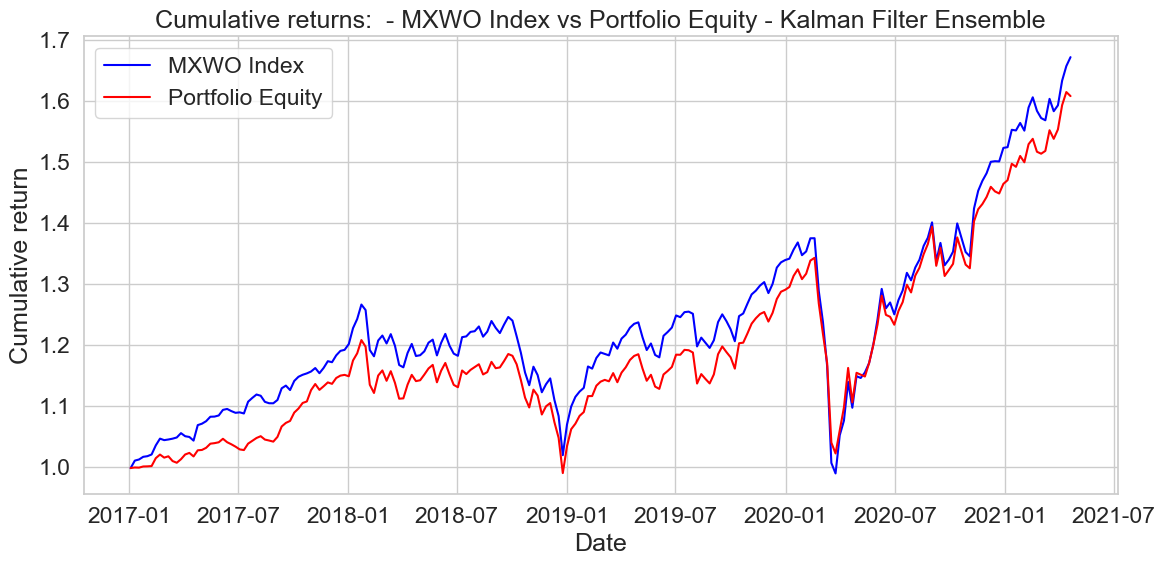

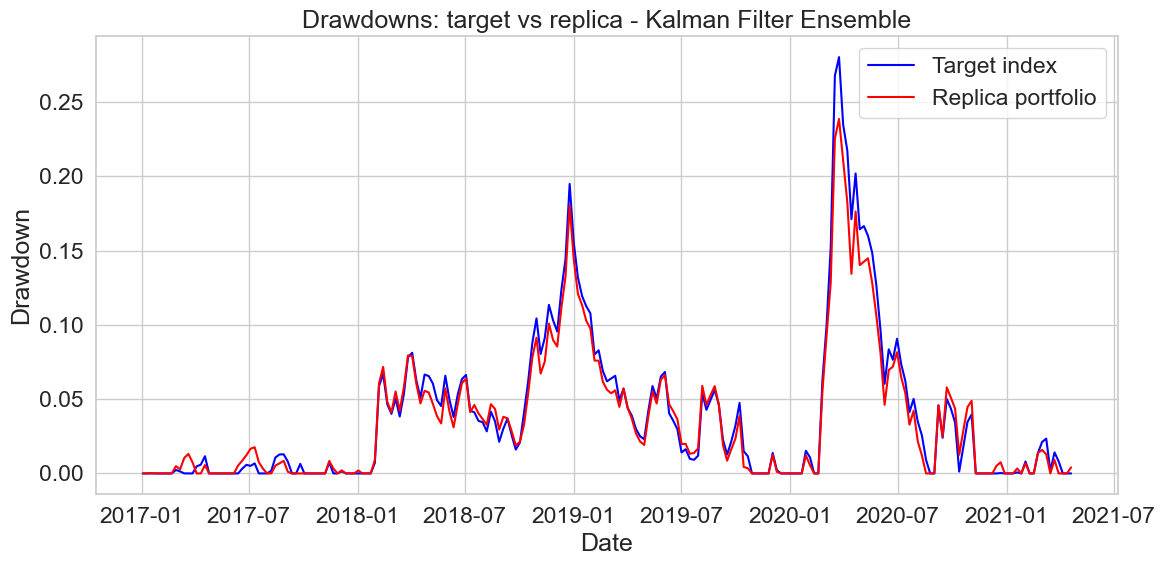

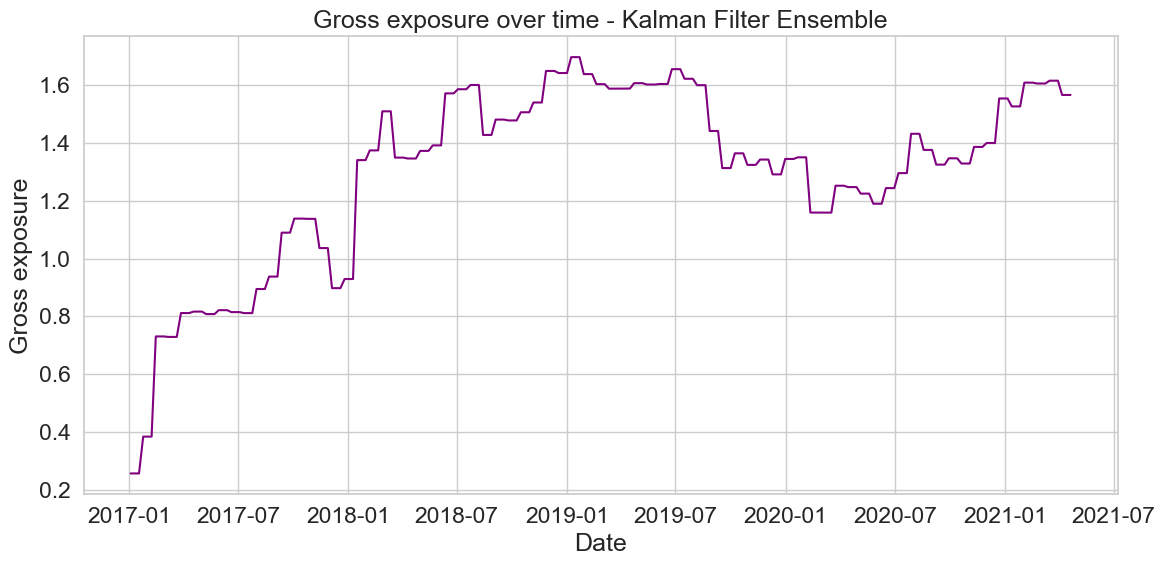

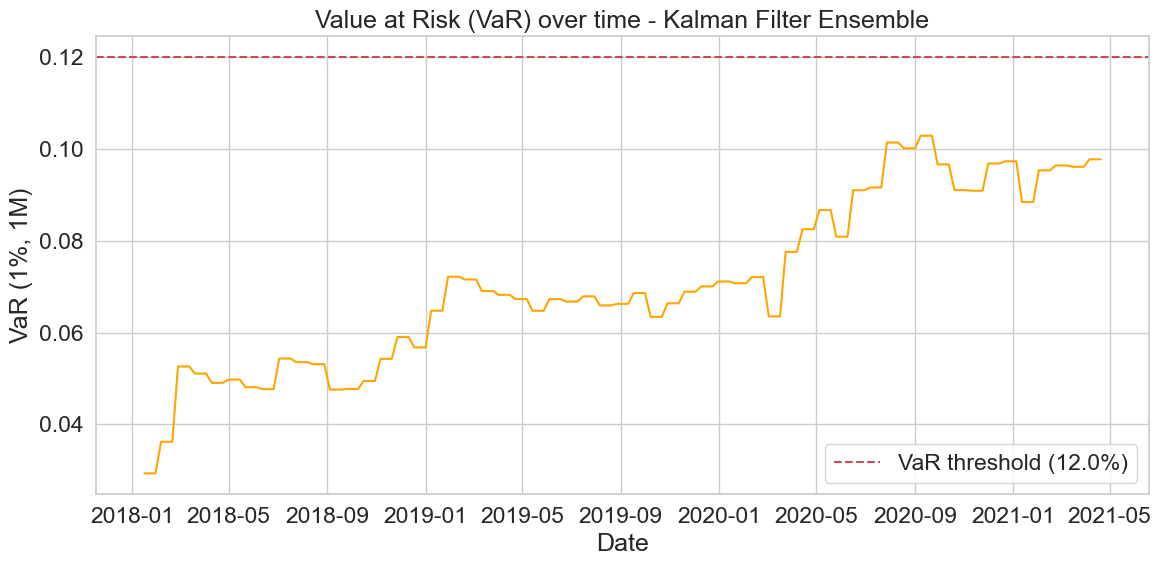

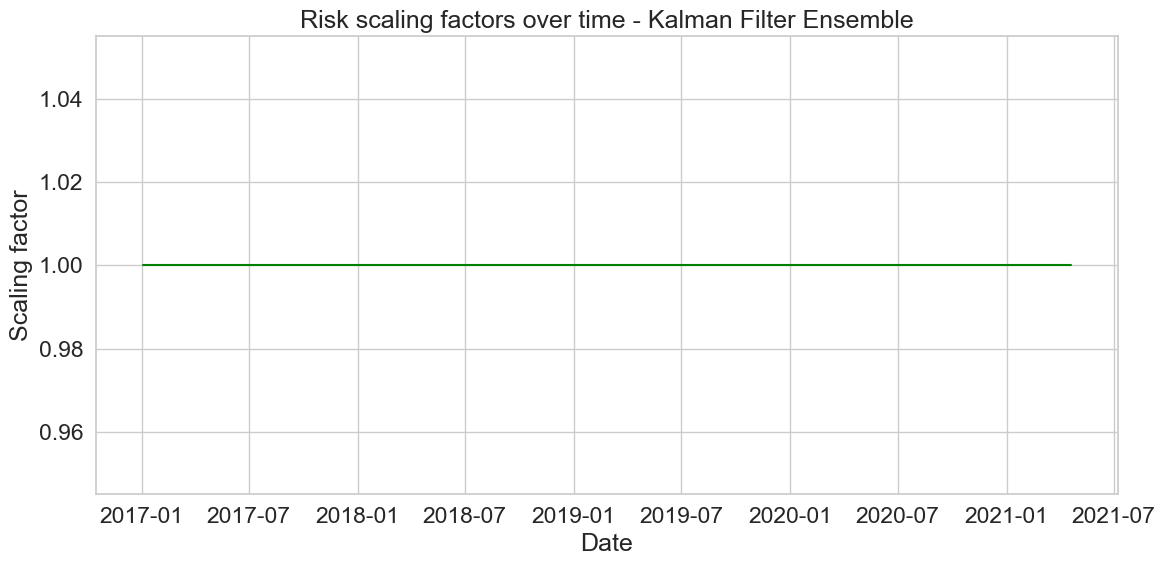

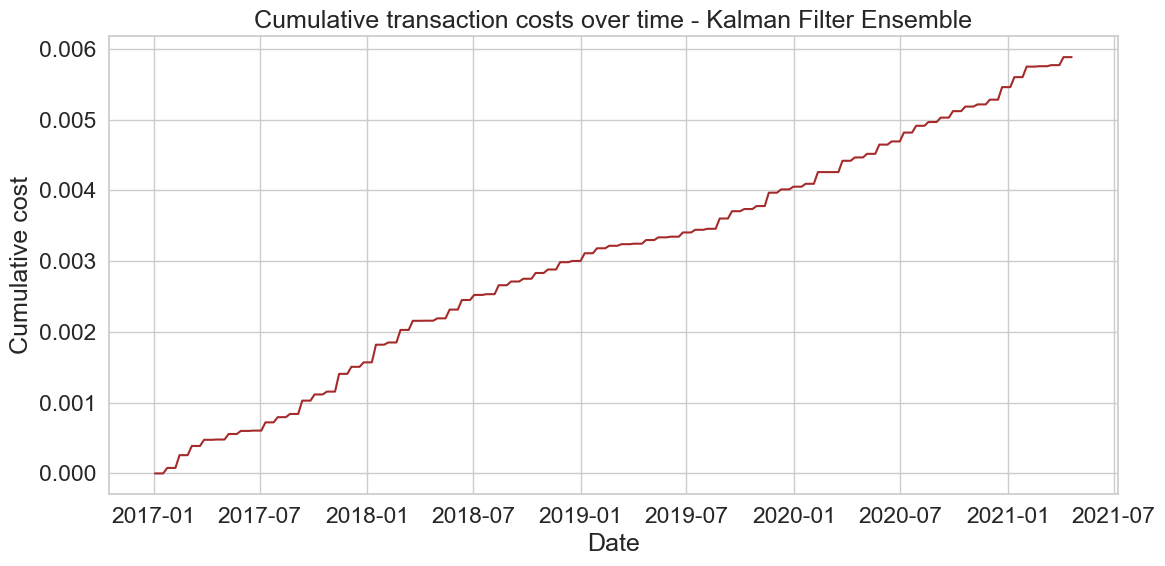

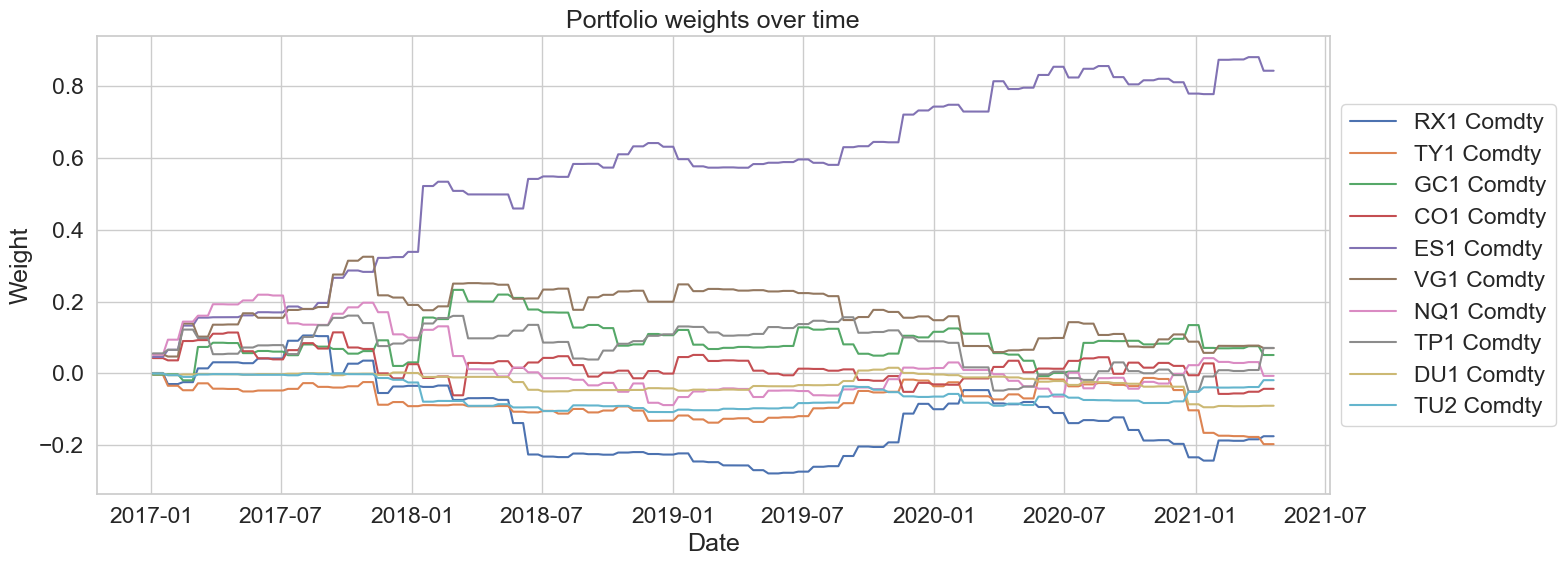

In [70]:
# # Import best parameters from optuna
ensemble_size = study_KFE.best_trial.params['ensemble_size']
process_noise_scale = study_KFE.best_trial.params['process_noise_scale']
rolling_window = study_KFE.best_trial.params['rolling_window']
rebalancing_window = study_KFE.best_trial.params['rebalancing_window']


# Run the Kalman filter model
result_KFE = rep.run_ensemble_kalman_filter_model(
    rolling_window=rolling_window,               
    rebalancing_window=rebalancing_window,       
    ensemble_size=ensemble_size,                 # Ensemble size from Optuna
    process_noise_scale=process_noise_scale      # Process noise scale from Optuna
)

# Create a DataFrame for the results
result_KFE_df = pd.DataFrame([result_KFE])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KFE_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KFE = result_KFE_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KFE = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KFE['target_return']*100:.2f}%",
               f"{best_config_normalized_KFE['target_vol']*100:.2f}%",
               f"{best_config_normalized_KFE['target_sharpe']:.2f}",
               f"{best_config_normalized_KFE['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KFE['replica_return']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_sharpe']:.2f}",
                f"{best_config_normalized_KFE['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KFE['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KFE['information_ratio']:.2f}",
                f"{best_config_normalized_KFE['correlation']:.4f}",
                f"{best_config_normalized_KFE['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KFE['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KFE)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_KFE, 'Kalman Filter Ensemble')

## 3.6 Model Comparison and Analysis

In this section, we compare the performance of all implemented portfolio replication strategies: Equally Weighted, Elastic Net, Kalman Filter, and Ensemble Kalman Filter. The comparison is based on a comprehensive set of risk and return metrics, including annualized return, volatility, Sharpe ratio, maximum drawdown, tracking error, information ratio, correlation, average gross exposure, and average Value at Risk (VaR).

**What this cell does:**
- Aggregates the key performance metrics for each model into a single DataFrame for side-by-side comparison.
- Displays the comparison table to highlight the strengths and weaknesses of each approach relative to the target portfolio.
- Provides a clear overview to support the selection of the most effective replication strategy under different market conditions.

This analysis helps to identify which model best replicates the target portfolio and under what circumstances each method may be preferred.

In [71]:
# Build full comparison table
# window=52

all_models_metrics = [
    rep.extract_target_metrics(window),
    rep.extract_replica_metrics(results_equal_weighted, 'Equally Weighted'),
    rep.extract_replica_metrics(results_df_normalized_EN.iloc[0].to_dict(), 'Elastic Net Normalized'),
    rep.extract_replica_metrics(best_config_normalized_KF.to_dict(), 'Kalman Filter'),
    rep.extract_replica_metrics(best_config_normalized_KFE.to_dict(), 'Ensemble Kalman Filter')
]

comparison_df = pd.DataFrame(all_models_metrics)

# Display
print("\nFull Performance Comparison (with consistent Target Portfolio metrics):")
display(comparison_df)



Full Performance Comparison (with consistent Target Portfolio metrics):


Model Annualized return Annualized volatility  \
0        Target Portfolio            12.99%                14.66%   
1        Equally Weighted             8.38%                 9.44%   
2  Elastic Net Normalized            14.55%                13.20%   
3           Kalman Filter            12.49%                14.55%   
4  Ensemble Kalman Filter            11.92%                13.55%   

  Sharpe ratio Max Drawdown Tracking Error Information ratio Correlation  \
0         0.89       28.04%            N/A               N/A         N/A   
1         0.89       17.36%          8.67%             -0.53      0.8268   
2         1.10       20.15%          4.40%              0.35      0.9554   
3         0.86       27.98%          1.15%             -0.44      0.9969   
4         0.88       23.87%          3.44%             -0.31      0.9733   

  Average gross exposure Average VaR (1%, 1M) Transaction cost (bp)  
0                    N/A                  N/A                   NaN  
1                 1.0000                  N/A                 50.00  
2                 0.8560                7.55%                 17.41  
3                 1.2735                7.36%                105.49  
4                 1.3009                7.07%                 58.85

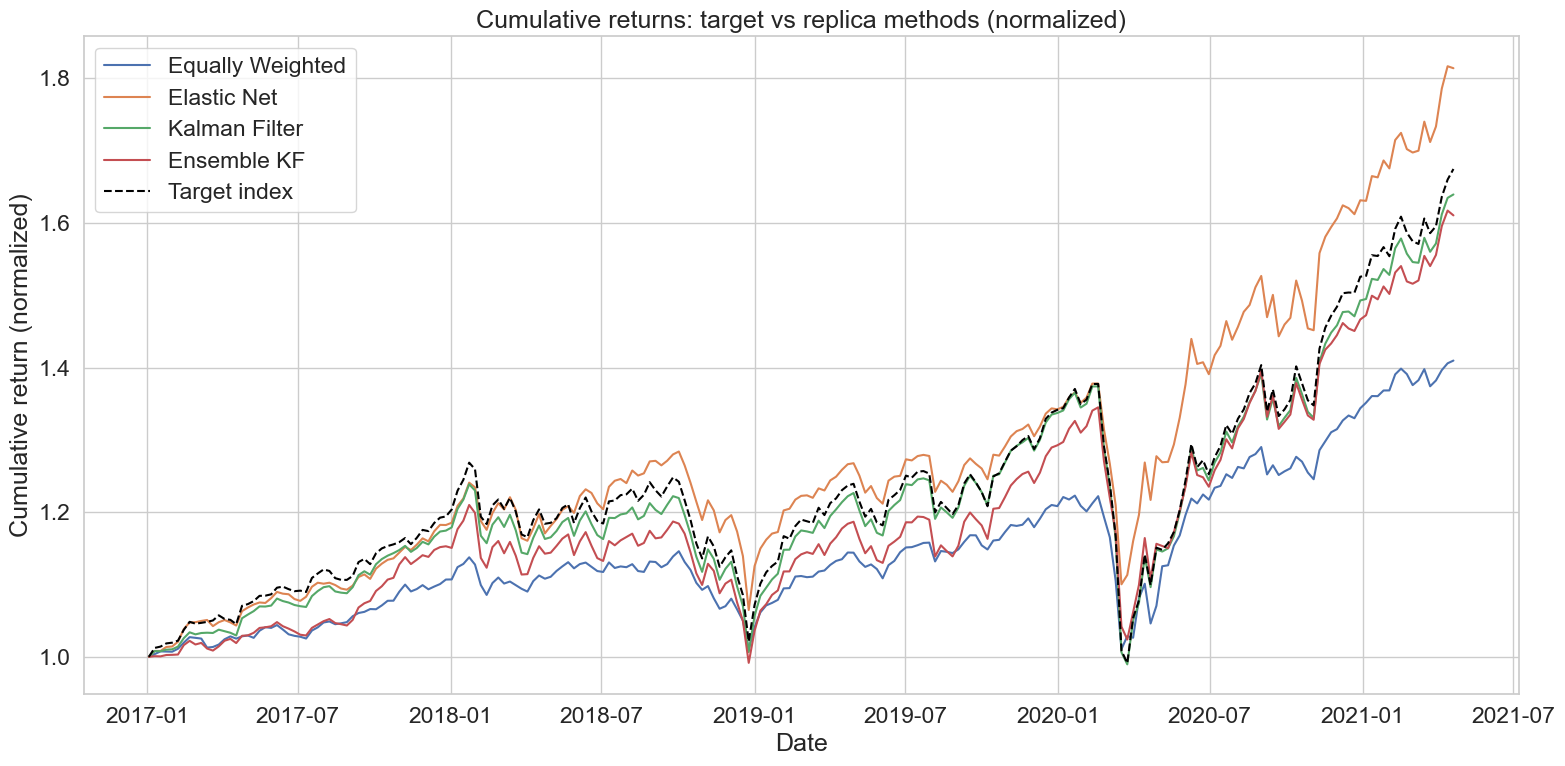

In [72]:
all_results = {
    'Equally Weighted' : results_equal_weighted,
    'Elastic Net'      : results_df_normalized_EN.iloc[0],
    'Kalman Filter'    : best_config_normalized_KF,
    'Ensemble KF'      : result_KFE
}
rep.plot_comparison(all_results)

## 3.7 Discrete Portfolio Allocation and Transaction Cost Analysis

In this section, we transition from continuous portfolio weights to a **discrete allocation approach**, where portfolio weights are translated into actual positions based on a fixed portfolio value. This is a more realistic scenario, as it accounts for the practical constraints of trading and rebalancing in real markets.

**What these cells do:**
- Convert the continuous weights from each replication model (Elastic Net, Kalman Filter, Ensemble Kalman Filter) into discrete positions, considering a fixed portfolio value and transaction costs.
- Calculate the **Total Expense Ratio (TER)** for each strategy, which represents the annualized transaction costs as a percentage of the portfolio value.
- Display the total and annualized transaction costs, as well as the TER, for each approach.
- Plot and compare the normalized equity curves of the discrete replica portfolios against the target and continuous replica portfolios.

This analysis provides insight into the real-world implementation costs of each replication strategy and highlights the impact of transaction costs and discrete trading on portfolio performance.

In [73]:
# Portfolio value
portfolio_value = 10_000_000 
transaction_cost = 0.0005  # 0.05% transaction costs

Total transaction cost on the dataset: 34886.3256
Annualized average transaction cost: 8062.6175
Total Expense Ratio (TER) per annum: 0.0806%

Position History (first rows):


RX1 Comdty  TY1 Comdty  GC1 Comdty  CO1 Comdty  ES1 Comdty  \
2017-01-03           1           1           1           1        2867   
2017-01-10           1           1           1           1        2853   
2017-01-17           1           1           1           1        2854   
2017-01-24           1           1           1           1        2839   
2017-01-31           1           1           1           1        2729   

            VG1 Comdty  NQ1 Comdty  TP1 Comdty  DU1 Comdty  TU2 Comdty  
2017-01-03           1         388           1           1           1  
2017-01-10           1         378           1           1           1  
2017-01-17           1         377           1           1           1  
2017-01-24           1         373           1           1           1  
2017-01-31           1         417           1           1           1

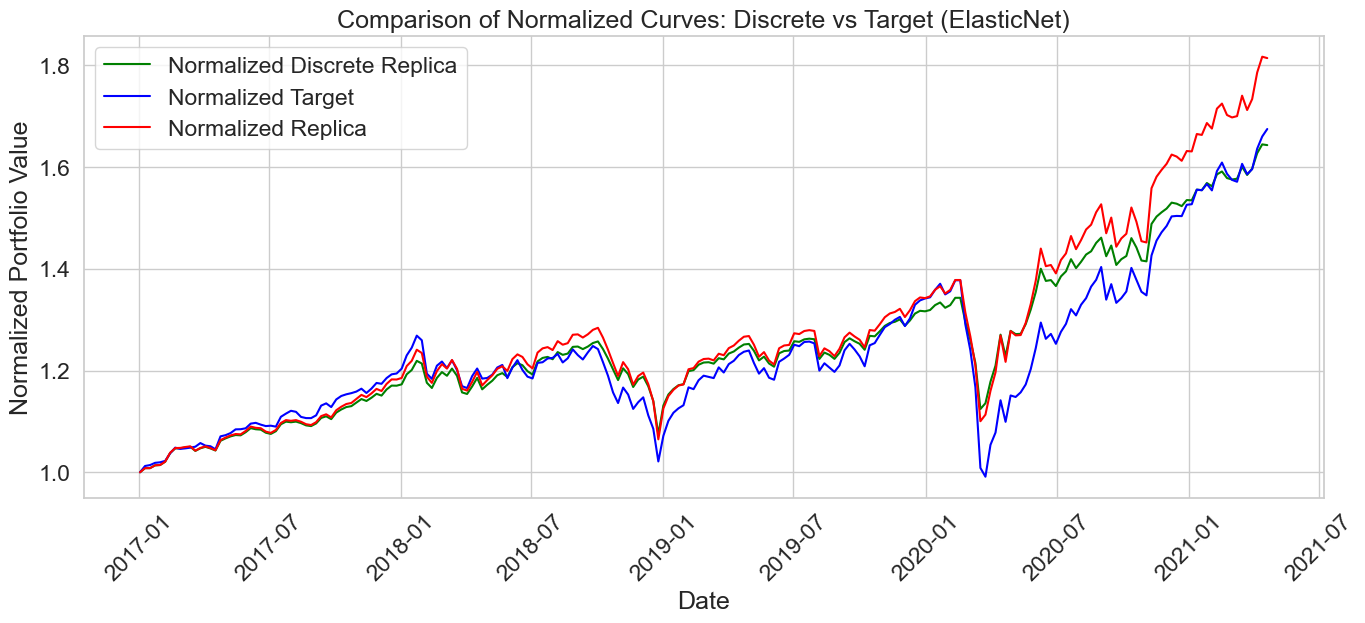

In [74]:
# ElasticNet Portfolio Allocation

total_cost_EN, annual_cost_EN, positions_history_df_EN = rep.compute_discrete_transaction_costs(
    result=results_EN,
    portfolio_value=portfolio_value,
    prices_df=df_underlyings,
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Elastic Net model per annum
TER_EN = annual_cost_EN / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_EN))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_EN))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_EN))
print("\nPosition History (first rows):")
display(positions_history_df_EN.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_EN, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = results_EN['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = results_EN['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (ElasticNet)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Total transaction cost on the dataset: 114599.6481
Annualized average transaction cost: 26485.2520
Total Expense Ratio (TER) per annum: 0.2649%

Position History (first rows):


RX1 Comdty  TY1 Comdty  GC1 Comdty  CO1 Comdty  ES1 Comdty  \
2017-01-03          62        -262         -20        7607         203   
2017-01-10          92         777         418       -9588         274   
2017-01-17         584        1267         722       -1875         283   
2017-01-24        -195         182         710       -1403         316   
2017-01-31        -318         290         707       -1105         314   

            VG1 Comdty  NQ1 Comdty  TP1 Comdty  DU1 Comdty  TU2 Comdty  
2017-01-03         162         106         365           2         -28  
2017-01-10         134         261         700         -37         188  
2017-01-17         100         289         524           2         329  
2017-01-24          92         315         531        -182         147  
2017-01-31          77         315         543        -163         150

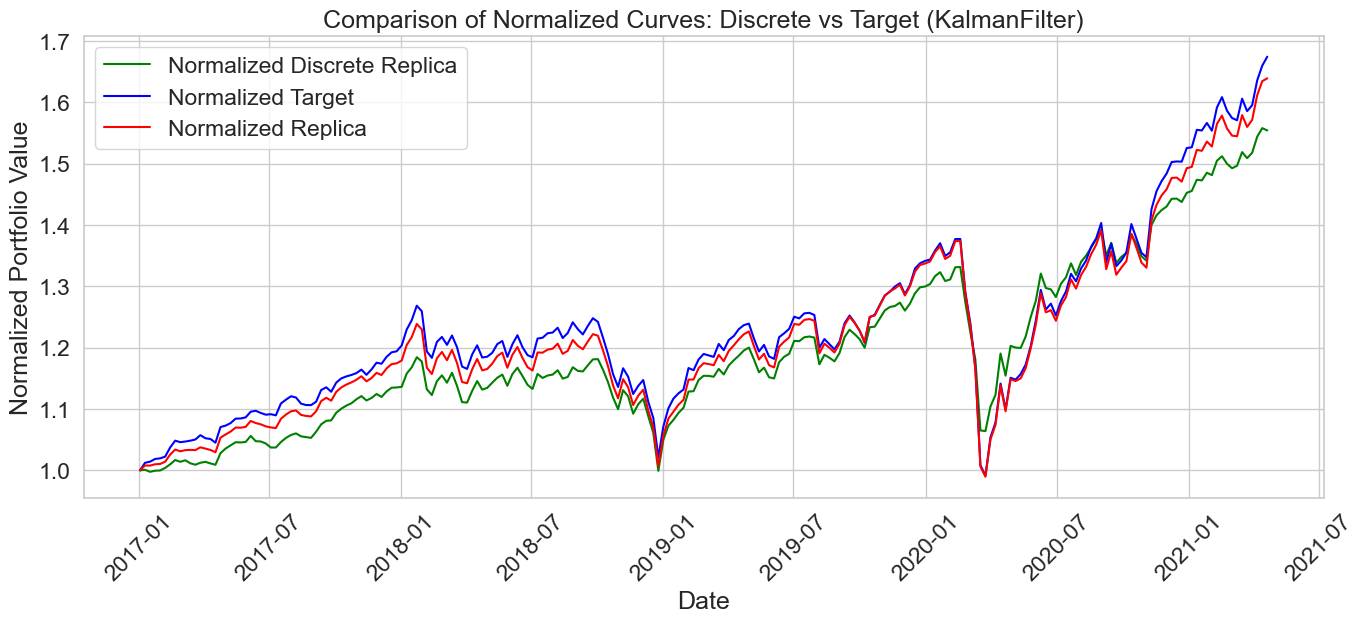

In [75]:
total_cost_KF, annual_cost_KF, positions_history_df_KF = rep.compute_discrete_transaction_costs(
    result=result_KF,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Kalman Filter model per annum
TER_KF = annual_cost_KF / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KF))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KF))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KF))
print("\nPosition History (first rows):")
display(positions_history_df_KF.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KF, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KF['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KF['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (KalmanFilter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Total transaction cost on the dataset: 75236.2356
Annualized average transaction cost: 17387.9300
Total Expense Ratio (TER) per annum: 0.1739%

Position History (first rows):


RX1 Comdty  TY1 Comdty  GC1 Comdty  CO1 Comdty  ES1 Comdty  \
2017-01-03          77        -287         -28        7691         204   
2017-01-10          77        -286         -27        7954         203   
2017-01-17          77        -285         -26        7691         203   
2017-01-24       -1814       -2763         -20        6563         290   
2017-01-31       -1821       -2758         -20        6532         290   

            VG1 Comdty  NQ1 Comdty  TP1 Comdty  DU1 Comdty  TU2 Comdty  
2017-01-03         161         107         368           4         -23  
2017-01-10         161         104         362           4         -23  
2017-01-17         162         104         371           4         -23  
2017-01-24         144         185         436        -442        -446  
2017-01-31         146         184         434        -442        -446

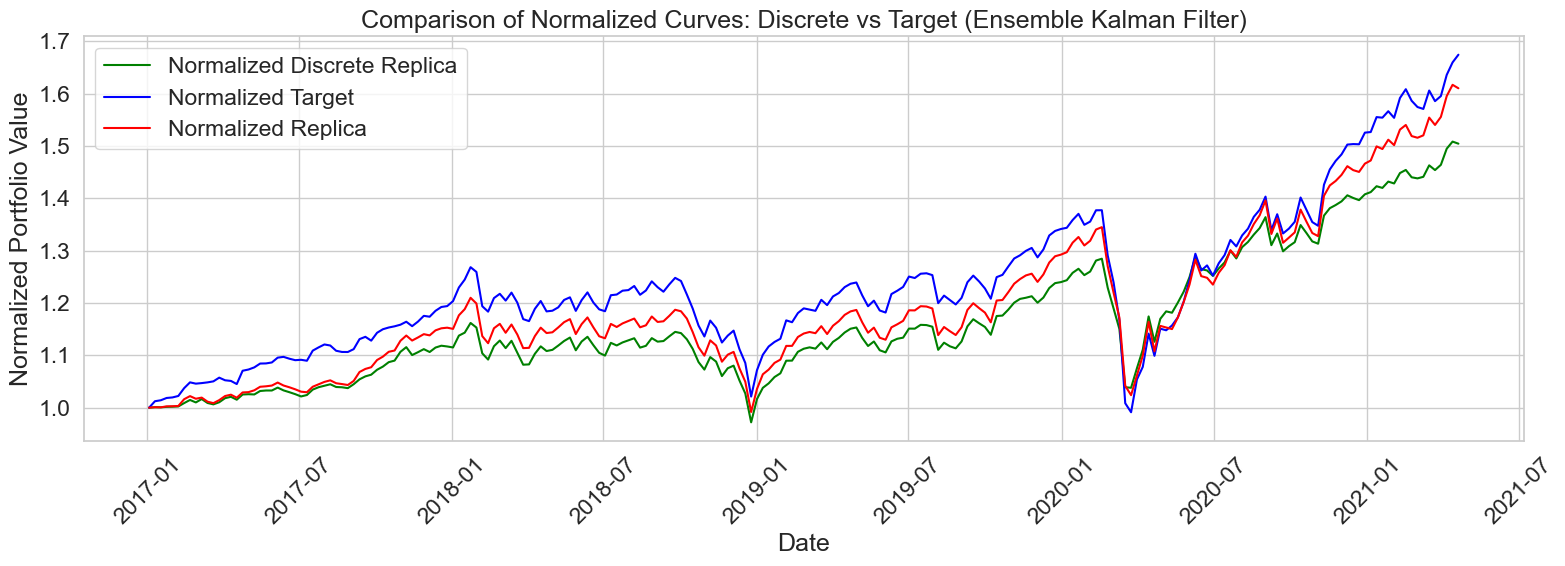

In [76]:
# Ensemble Kalman Filter Portfolio Allocation

total_cost_KFE, annual_cost_KFE, positions_history_df_KFE = rep.compute_discrete_transaction_costs(
    result=result_KFE,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Ensemble Kalman Filter model per annum
TER_KFE = annual_cost_KFE / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KFE))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KFE))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KFE))
print("\nPosition History (first rows):")
display(positions_history_df_KFE.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KFE, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KFE['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KFE['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (Ensemble Kalman Filter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
<a id="sec-4-anomaly-detection"></a>
# 4. Anomaly Detection


## 4.0 Anomaly Detection Introduction
<a id="sec-40-anomaly-detection-introduction"></a>

This section of the project focuses on the identification of anomalies within financial time series data and the analysis of their impact on portfolio performance. The dataset utilized is `Dataset4_EWS.xlsx`, which comprises market data and anomaly labels (`Y` column) for various financial assets. The primary objective is to detect anomalies that may negatively affect portfolio strategies and to evaluate the effectiveness of different anomaly detection methods.

#### Methodology

The analysis employs several anomaly detection algorithms to ensure a robust comparison of methods and results. Below is an overview of the approaches considered:

##### A. MLP Classifier (Basic and Tuned)

A Multi-Layer Perceptron (MLP) classifier is implemented with two configurations:
- A **basic architecture** with predefined layer sizes (`hidden_layer_sizes=(512, 256, 128, 64, 32, 16)`), designed to capture complex relationships within the data.
- A **tuned configuration** using the Optuna hyperparameter optimization framework to refine the model architecture and improve anomaly detection performance.

##### B. LSTM Autoencoder

An unsupervised approach using a Long Short-Term Memory (LSTM) based autoencoder is employed. The autoencoder learns to reconstruct normal patterns and identifies deviations from these patterns as potential anomalies.

- Hyperparameter tuning is performed with Optuna to determine the optimal architecture and anomaly threshold.
- The method focuses on the detection of structural deviations within the time series data.

##### C. LSTM Classifier (Supervised and Tuned Threshold)

A supervised LSTM Classifier is developed to distinguish normal and anomalous patterns directly based on the `Y` anomaly labels.

- Two classification thresholds are considered:
  - A standard binary classification threshold of 0.5.
  - A tuned threshold selected to achieve a specified target precision level, thereby providing a more conservative anomaly detection strategy.


<!-- ## Additional Analyses

For each detection method, the analysis includes:
- A portfolio simulation that evaluates the performance when anomalies are excluded from the investment process.
- Drawdown analysis, computing the maximum drawdown (MDD) and recovery time for each anomaly-excluded portfolio.
- A comparative visualization of the portfolio evolution across different detection scenarios.

--- -->

##### Portfolio Types Considered

Three portfolio configurations are evaluated:
- **Equity Portfolio**:        Consisting of the index `'MXUS'`.
- **Bond Portfolio**:          Comprising the indices `'LUMSTRUU', 'LUACTRUU', 'EMUSTRUU'`.
- **Life Strategy Portfolio**: Including the indices `'MXUS', 'LUMSTRUU', 'LUACTRUU', 'EMUSTRUU'`.

Each portfolio applies tailored asset weights to mimic the desired investment strategies.


#### Summary of Results

The final results include:
- Precision, recall, and F1-score metrics for each anomaly detection method.
- Summary tables presenting the number of anomalies detected and their effect on portfolio performance.
- Visual plots of the synthetic portfolio value evolution under different anomaly detection approaches.
- Drawdown and recovery metrics to quantify the impact of anomalies on portfolio risk.

This analysis aims to provide a comprehensive evaluation of how different anomaly detection methods can inform portfolio management decisions and enhance resilience against market irregularities.


**Next Steps:**  
- Validate the results of the detected anomalies on the replication strategy previously illustrated.

This document serves as a detailed overview of the anomaly detection procedures and the comparative performance of the implemented models.

<br>

<br>

###  Settings of the section

Select the number of trials in the Optuna Hyperparameters Tuning and check that the flag of the desired portfolio has been correctly selected. 

In [77]:
# Define the Optuna number of trials
optuna_n_trials = 0

# Select the type of portfolio: 1 for Equity, 2 for Bond, 3 for Commodity
# selected_flag = 1

if selected_flag == 1:
        str_flag = "Equity"
        print("Portfolio Equity")
elif selected_flag == 2:
        str_flag = "Bond"
        print("Portfolio Bond")
elif selected_flag == 3:
        str_flag = "LifeStrategy"
        print("Portfolio LifeStrategy")
else:
        str_flag = "Unknown"
        print("Portfolio Unknown")

Portfolio Equity


## 4.1 Anomaly Detection Dataloading and Preprocessing
<a id="sec-41-anomaly-detection-dataloading-and-preprocessing"></a>

This section script is dedicated to loading and preprocessing the financial dataset used for anomaly detection and subsequent analyses. The primary dataset is stored in the Excel file `Dataset4_EWS.xlsx`, which contains:

- **Market Data**: Located in the `'Markets'` sheet, containing time series data of various indices and an anomaly label column (`Y`).
- **Metadata**: Located in the `'Metadata'` sheet, providing additional descriptive information about the dataset.


This preprocessed data serves as the input for subsequent anomaly detection and evaluation steps in the analysis.


In [78]:
# Helper module import
import sys
import os

# Get the current working directory (for Jupyter notebooks)
current_dir = os.getcwd()

# Define the relative path to the helper directory
helper_dir = os.path.join(current_dir, "AnomalyDetection")

# Add the helper directory to sys.path if not already there
if helper_dir not in sys.path:
    sys.path.append(helper_dir)


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from AnomalyDetectionHelper import AnomalyDetectionEDA

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Dataset Anomaly Detection
path_BC4 = 'Dataset4_EWS.xlsx'

# Get current working directory
current_dir = os.getcwd()

# Add the path to the dataset
file_path = os.path.join(current_dir, "Datasets", path_BC4)

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col]
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")



Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)


## 4.2 Anomaly Detection EDA
<a id="sec-42-anomaly-detection-eda"></a>

#### Initializing the Anomaly Detection Helper Class

In this cell, we initialize the `AnomalyDetectionEDA` class, which has been imported from an external helper module. This class is designed to streamline exploratory data analysis (EDA) for anomaly detection in financial time series data.

We perform two key steps using this class:
1. **Generating Enhanced Metadata:**  
   The `generate_metadata()` method computes basic descriptive statistics for each feature and combines them with metadata to provide a comprehensive overview.
   
2. **Visualizing Anomalies:**  
   The `plot_anomalies()` method plots the time series data for a specified index (in this case, `'EMUSTRUU'`) and highlights periods identified as anomalies.

This workflow provides a solid foundation for understanding the dataset’s structure and visualizing potential anomaly periods.



Enhanced Metadata:


Ticker                     Description         Mean      Std.Dev  \
0        BDIY                Baltic Dry Index  2259.860486  2017.811888   
1         CRY              TR/CC CRB ER Index   245.247649    68.278081   
2         Cl1         Generic 1st 'CL' Future    60.708101    25.900813   
3         DXY               DOLLAR INDEX SPOT    90.934982    11.379095   
4    ECSURPUS  Bloomberg ECO US Surprise Inde     0.036153     0.349453   
5    EMUSTRUU                EM USD Aggregate   704.379495   309.951768   
6       EONIA  EMMI EURO OverNight Index Aver     1.363676     1.721894   
7         GBP              British Pound Spot     1.569618     0.212340   
8        GT10                 US TREASURY N/B     3.266748     1.332464   
9    GTDEM10Y        BUNDESREPUB. DEUTSCHLAND     2.448365     1.851558   
10    GTDEM2Y         BUNDESSCHATZANWEISUNGEN     1.431110     1.876061   
11   GTDEM30Y        BUNDESREPUB. DEUTSCHLAND     3.039282     1.779526   
12   GTGBP20Y              UK TSY 1 1/4% 2041     3.445731     1.366188   
13    GTGBP2Y              UK TSY 0 1/8% 2023     2.299739     2.128539   
14   GTGBP30Y              UK TSY 0 5/8% 2050     3.450121     1.263211   
15  GTITL10YR        BUONI POLIENNALI DEL TES     3.680791     1.465289   
16   GTITL2YR        BUONI POLIENNALI DEL TES     2.104911     1.700726   
17  GTITL30YR        BUONI POLIENNALI DEL TES     4.426725     1.274729   
18  GTJPY10YR           JAPAN (10 YEAR ISSUE)     0.904126     0.643985   
19   GTJPY2YR            JAPAN (2 YEAR ISSUE)     0.150180     0.297519   
20  GTJPY30YR           JAPAN (30 YEAR ISSUE)     1.724494     0.720026   
21        JPY               Japanese Yen Spot   106.605734    12.840754   
22   LF94TRUU         Global Inflation-Linked   259.052663    75.934443   
23   LF98TRUU         US Corporate High Yield  1231.258119   553.121000   
24   LG30TRUU               Global High Yield   804.720625   370.251996   
25     LMBITR            Municipal Bond Index   883.615439   241.507125   
26   LP01TREU         Pan-European High Yield   232.109928   109.917622   
27   LUACTRUU                       Corporate  2077.306949   690.731794   
28   LUMSTRUU                        U.S. MBS  1637.293510   417.229338   
29       MXBR                     MSCI BRAZIL  1903.216436   986.468254   
30       MXCN                      MSCI CHINA    53.933159    24.738356   
31       MXEU                     MSCI EUROPE   107.877138    20.795973   
32       MXIN                      MSCI INDIA   693.156616   405.527014   
33       MXJP                      MSCI JAPAN   784.846292   200.076443   
34       MXRU                     MSCI RUSSIA   648.681377   299.096020   
35       MXUS                        MSCI USA  1606.997102   698.481956   
36    US0001M           ICE LIBOR USD 1 Month     1.836073     1.909032   
37    USGG2YR            US Generic Govt 2 Yr     1.990358     1.710307   
38   USGG30YR           US Generic Govt 30 Yr     3.908324     1.178592   
39     USGG3M           US Generic Govt 3 Mth     1.575151     1.802895   
40        VIX           Cboe Volatility Index    19.992169     8.642157   
41    XAUBGNL                         XAUBGNL   987.463744   494.623740   

          Min          Max  Missing values Missing (%)  
0   291.00000  11793.00000               0       0.00%  
1   106.29290    467.57000               0       0.00%  
2    10.01000    140.97000               0       0.00%  
3    71.32900    119.82000               0       0.00%  
4    -0.97400      0.99100               0       0.00%  
5   230.52670   1286.35300               0       0.00%  
6    -0.49800      5.73000               0       0.00%  
7     1.17230      2.08520               0       0.00%  
8     0.50800      6.74800               0       0.00%  
9    -0.79400      5.64400               0       0.00%  
10   -0.96800      5.26400               0       0.00%  
11   -0.47100      6.25400               0       0.00%  
12    0.48920      5.24180              

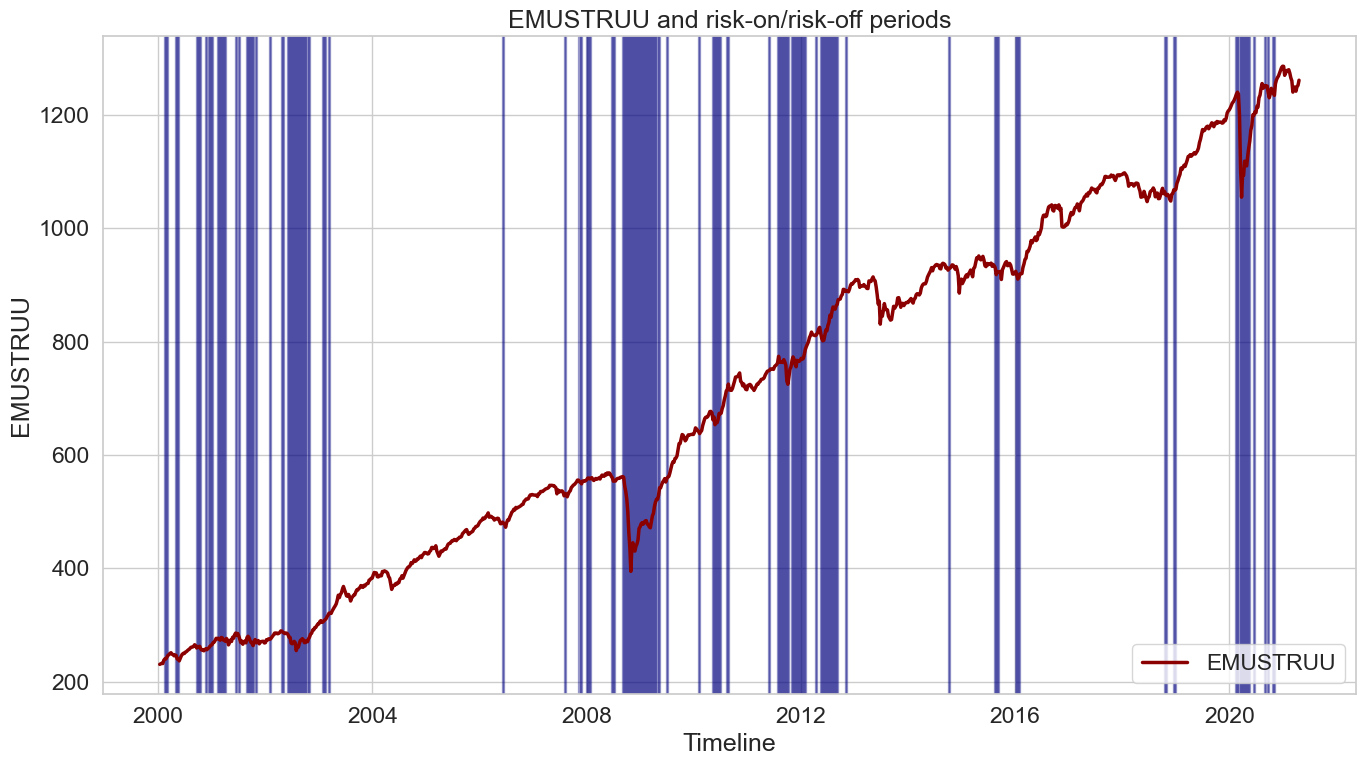

In [80]:
# Initialize the AnomalyDetectionEDA class with the loaded data
eda = AnomalyDetectionEDA(data_df=data_df, metadata_df=metadata_df, X_df=X_df, y=y)

# Generate metadata for the dataset to better understand the features
meta_df = eda.generate_metadata()

# Plot the time series data highlighting anomalies
eda.plot_anomalies(index_col='EMUSTRUU')


#### Anomalies Filtering

In this step, we focus on detecting anomalies that are specifically relevant to the assets higly correlated with our portfolio. By selecting only the columns corresponding to our portfolio holdings, we ensure that the anomaly detection process highlights unusual events that could directly impact our investment strategy.
This targeted approach helps us filter out irrelevant anomalies and concentrate on those that matter most for our portfolio management and risk assessment.


In [81]:
# Select columns based on the selected portfolio type
if selected_flag == 1: # Portfolio Equity 
    cols_to_use = ["MXUS"]

elif selected_flag == 2: # Portfolio Bond
    cols_to_use = ["LUMSTRUU", "LUACTRUU", "EMUSTRUU"]

elif selected_flag == 3: # Portfolio Commodity
    cols_to_use = ["MXUS", "LUMSTRUU", "LUACTRUU", "EMUSTRUU"]

else:
    raise ValueError("Invalid selected_flag value. Must be 1, 2, or 3.")

# Perform anomaly detection using the specified columns
eda.filter_negative_anomalies(cols_to_use=cols_to_use)


Number of anomalies with negative returns: 143
Total number of anomalies: 237


#### Assets Analysis

This function visualizes the time series data, returns, distributions, and QQ plots for the specified asset columns.  
It distinguishes between bonds and equity returns, using first differences for bonds and log returns for equities.  
The distribution histograms and QQ plots also help in assessing the normality of returns, revealing deviations from the Gaussian distribution that may indicate risk concentrations or structural breaks.  
These visual insights support further quantitative analyses and validate assumptions about the statistical properties of financial returns.


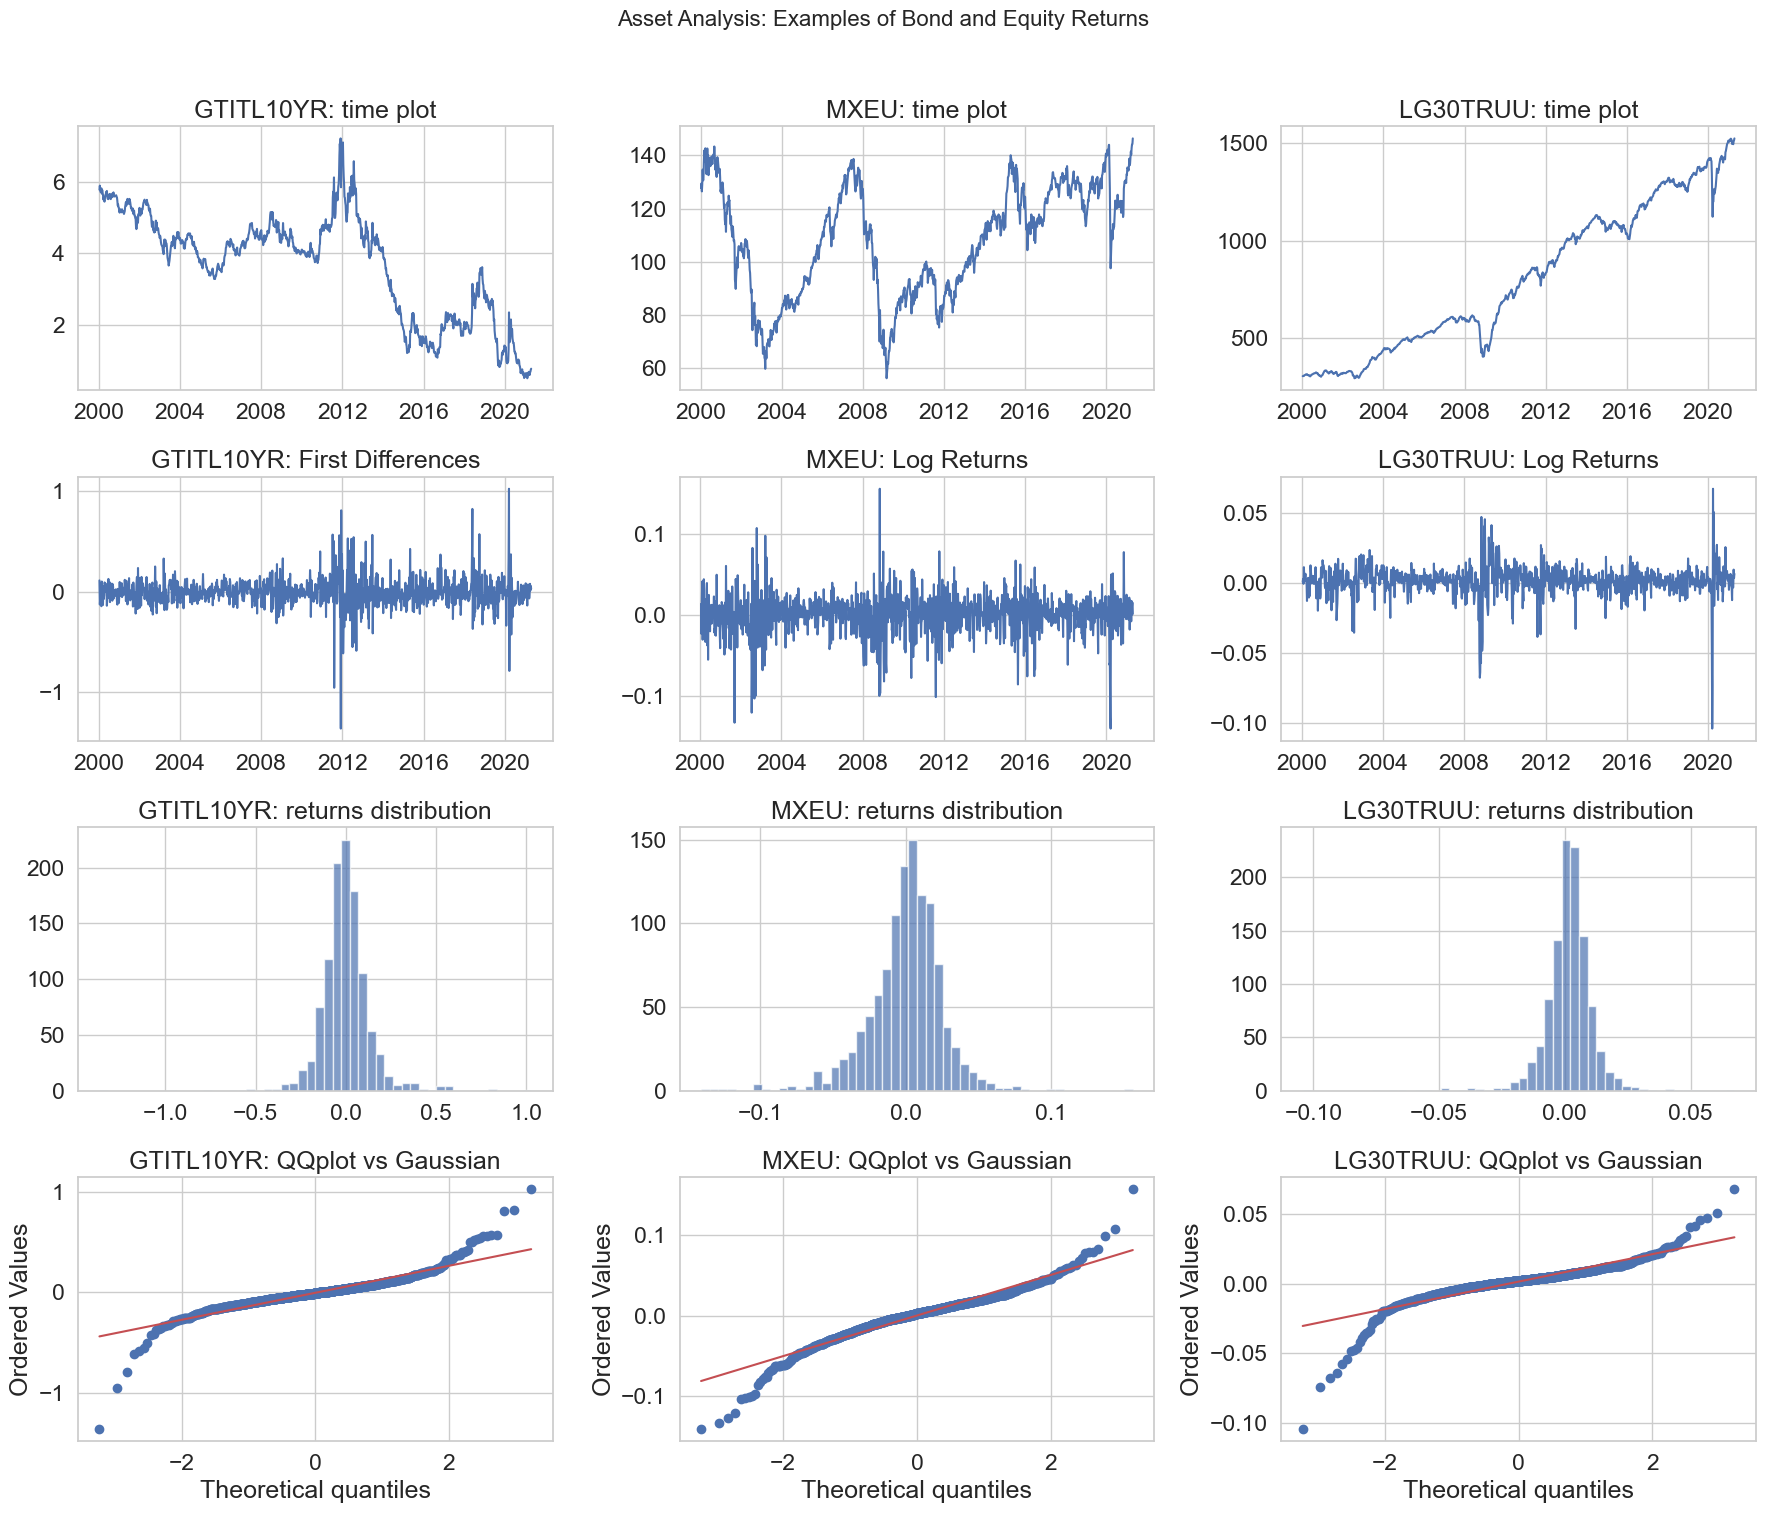

In [82]:
eda.visualize_assets(asset_columns=['GTITL10YR', 'MXEU', 'LG30TRUU'], bonds=['GTITL10YR'])

#### Check for negative Interest Rates

This function plots the distribution of a specified interest rate to check for negative yields.  
This helps identify unusual interest rate patterns that may affect investment decisions. This is particularly important for the stationarity analysis.


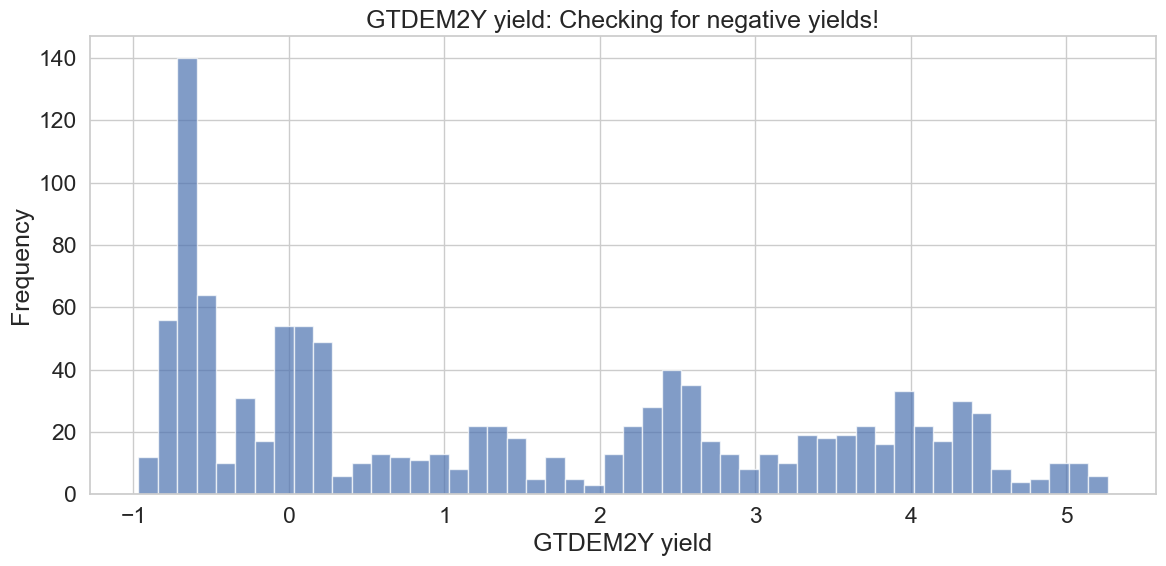

In [83]:
eda.plot_interest_rate_distribution(column='GTDEM2Y')

#### Stationarity Check
It is important to check for stationarity in financial time series.  
Stationarity ensures that statistical properties such as mean and variance remain constant over time, which is a key assumption for many time series models and analyses.  
The ADF test implemented here evaluates the null hypothesis of non-stationarity, and the test is considered passed (stationary) if the p-value is below 0.05.



In [84]:
eda.adf_stationarity_test()

#### Evaluate Results Functions

The `DetectionMethodsEvaluation` class built in the helper file `AnomalyDetectionHelper` provides useful function to compute key metrics (e.g. F1 score, Precision, Recall) and plot relevant curves to evaluate the models' results (e.g. ROC curve and Precision-Recall curve).

In this class it is developed also a Business-Oriented taylored made metric called Financial Score.

##### Financial Score (FinScore) Explanation

1. **Cost per error**  
   - If the true regime is anomaly (`Y=1`) and the prediction is incorrect → cost = `mean_anomaly`.  
   - If the true regime is normal (`Y=0`) and the prediction is incorrect → cost = `mean_normal`.  
   - Correct predictions have no cost.

2. **Total Cost**  
   - Sum of all per-row costs for the test set.

3. **Worst-Case Cost**  
   - The cost incurred if all predictions were incorrect.

4. **Final FinScore** 
<br>

   $$
   1 \;-\; \frac{\text{Total Cost}}{\text{Worst-Case Cost}}
   $$

   

   - A score of 1 indicates perfect predictions; 0 corresponds to the worst possible performance.



<br>

<br>

## 4.3 MLP for Anomaly Detection
<a id="sec-43-mlp-for-anomaly-detection"></a>

This section implements anomaly detection using a **Multi-Layer Perceptron (MLP)**, a class of feedforward artificial neural networks.  

An MLP consists of multiple fully connected layers that learn to map input features to output labels through nonlinear activation functions and iterative weight adjustments (backpropagation).  

MLPs are particularly effective at modeling complex, nonlinear relationships within financial time series data, making them a suitable choice for anomaly detection tasks.


### 4.3.1 Simple MLP for Anomaly Detection
<a id="sec-431-simple-mlp-for-anomaly-detection"></a>

In this part, we configure a basic MLP with a predefined architecture to detect anomalies in the dataset.  

The simple MLP model includes multiple layers with decreasing numbers of neurons and uses the ReLU activation function.

This configuration enables the network to capture essential data patterns without overfitting.  
After training, we select the optimal threshold on the validation set to maximize the F1-score for distinguishing between normal and anomalous events.


In [85]:
from AnomalyDetectionHelper import AnomalyDataPreparer

# Define cutoff dates for training and validation sets
cutoff_date_train = pd.to_datetime('2012-01-01')
cutoff_date_val = pd.to_datetime('2017-01-01')
# Calculate the fractions for training and validation sets based on the cutoff dates
train_fraction = (X_df.index < cutoff_date_train).mean()
val_fraction = ((X_df.index < cutoff_date_val) & (X_df.index >= cutoff_date_train)).mean()


# Prepare the data using the AnomalyDataPreparer class
preparer_MLP = AnomalyDataPreparer(
    make_stationary=False,
    shuffle_data=False,
    scale_data=True,
    do_split=True,
    train_frac=train_fraction,
    val_frac=val_fraction
)

X_train, y_train, X_val, y_val, X_test, y_test = preparer_MLP.prepare(X_df, y)


Training set size: 625 (518 normal, 107 anomalies)
Validation set size: 261 (242 normal, 19 anomalies)
Test set size: 225 (208 normal, 17 anomalies)


In [86]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, f1_score

# Define the MLP model with a more complex architecture
MLP_basic_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64, 32, 16),
    activation='relu',
    solver='adam',
    random_state=42
)

# Train & evaluate
MLP_basic_model.fit(X_train, y_train)

# Choose a threshold on the validation set
Y_val_prob = MLP_basic_model.predict_proba(X_val)[:, 1]
best_f1, best_thresh = -1, 0.5
for τ in np.linspace(0.05, 0.95, 19):
    preds = (Y_val_prob > τ).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_thresh = f1, τ

# # Choose a threshold on the validation set maximizing the precision
# Y_val_prob = MLP_basic_model.predict_proba(X_val)[:, 1]
# best_precision, best_thresh = -1, 0.5
# for τ in np.linspace(0.05, 0.95, 19):
#     preds = (Y_val_prob > τ).astype(int)
#     precision = precision_score(y_val, preds)
#     if precision > best_precision:
#         best_precision, best_thresh = precision, τ

# Evaluate the model on the test set using the best threshold
Y_test_prob_SimpleMLP = MLP_basic_model.predict_proba(X_test)[:,1]
Y_test_pred_SimpleMLP = (Y_test_prob_SimpleMLP > best_thresh).astype(int)



--- MLP (Test) ---

MLP (Basic) Performance:
Precision: 0.5833
Recall:    0.4118
F1 Score:  0.4828
Financial Score: 0.8877


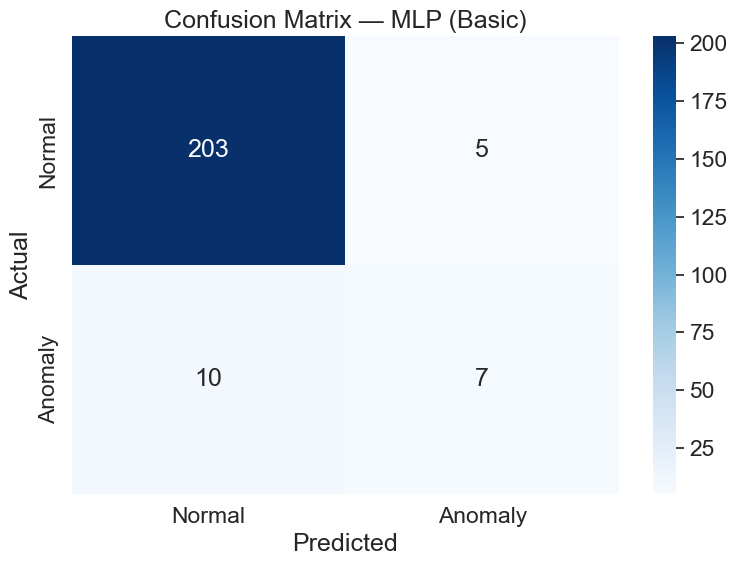

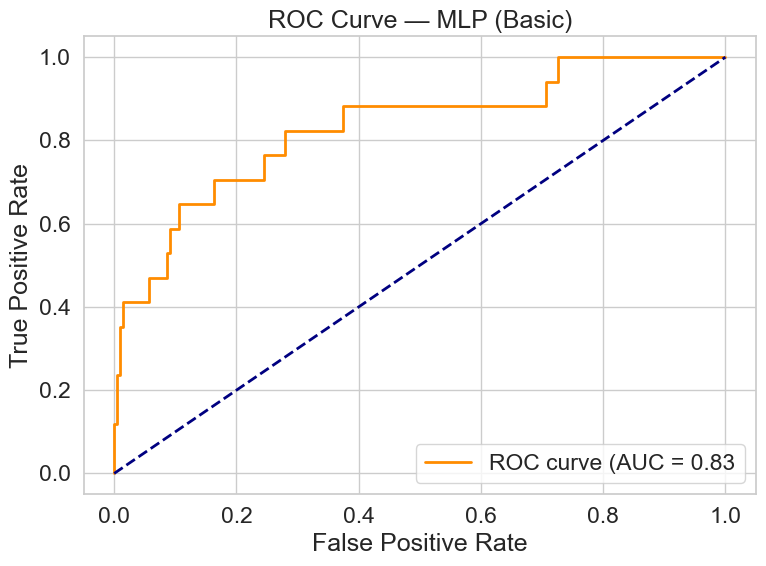

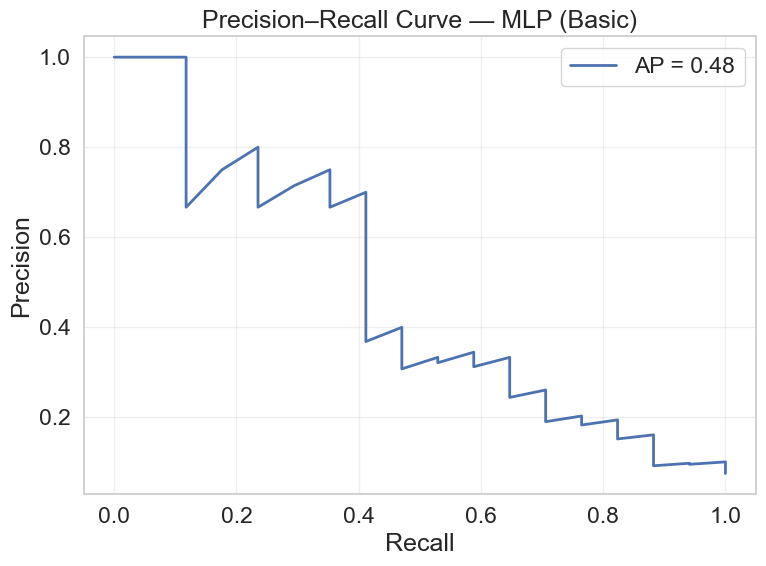

In [87]:
from AnomalyDetectionHelper import DetectionMethodsEvaluation

# Initialize evaluation class
evaluator_MLP = DetectionMethodsEvaluation(
    preparer=preparer_MLP,
    metadata_df=metadata_df,
    X_df=X_df,
    y=y
)

# Evaluate
print("\n--- MLP (Test) ---")
precision_Simple_MLP, recall_Simple_MLP, f1_Simple_MLP, fin_score_Simple_MLP = evaluator_MLP.evaluate_model(
    y_true=y_test.values,
    y_pred=Y_test_pred_SimpleMLP,
    y_score=Y_test_prob_SimpleMLP,
    model_name='MLP (Basic)'
)

# Convert predictions to a Series with same index as y_test
y_test_pred_series_MLP = pd.Series(Y_test_pred_SimpleMLP, index=y_test.index, name='y_pred')

# Current working directory
current_dir = os.getcwd()
# Build the full path to the CSV file inside the 'AnomalyDetection' folder
csv_file_path_MLP_Simple = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", f"{str_flag}_SimpleMLP_detections.csv")
# Save predictions to CSV
y_test_pred_series_MLP.to_csv(csv_file_path_MLP_Simple, index=True)

### 4.3.2 MLP with Optuna Hyperparameter Tuning for Anomaly Detection
<a id="sec-432-mlp-with-optuna"></a>


This section focuses on improving the MLP model’s performance through hyperparameter optimization using Optuna.  

Optuna is a framework that efficiently explores the space of possible configurations (e.g., number of layers, units per layer, learning rate) using Bayesian optimization.  

By systematically tuning these parameters, the MLP can better adapt to the data’s underlying structure, leading to more precise and robust anomaly detection.


In [88]:
from AnomalyDetectionHelper import MLPAnomalyDetector

# Initialize
mlp_detector = MLPAnomalyDetector(input_dim=X_train.shape[1])

# Current working directory (where your notebook is)
current_dir = os.getcwd()
# Define the directory for Optuna studies and create it if it doesn't exist
optuna_studies_dir = os.path.join(current_dir, "AnomalyDetection", "OptunaStudies")
os.makedirs(optuna_studies_dir, exist_ok=True)
# Build the full path for the CSV file
db_file_path = os.path.join(optuna_studies_dir, f"optuna_MLP_{str_flag}.db")
# Build the SQLite URI
optuna_db_uri_MLP = f"sqlite:///{db_file_path}"

# Hyperparameter tuning
study_MLP = mlp_detector.tune_hyperparameters(X_train, y_train, X_val, y_val, n_trials=optuna_n_trials, storage=optuna_db_uri_MLP)

# Train final model
mlp_detector.train_final_model(X_train, y_train, X_val, y_val)

# Evaluate on test set
y_pred_MLP_Optuna, y_prob_MLP_Optuna = mlp_detector.evaluate_on_test(X_test, y_test)


Best F1: 0.47058823529411764
Best hyperparameters: {'n_layers': 7, 'n_units_l0': 926, 'n_units_l1': 519, 'n_units_l2': 508, 'n_units_l3': 476, 'n_units_l4': 248, 'n_units_l5': 218, 'n_units_l6': 114, 'learning_rate_init': 0.009203420996666234, 'alpha': 5.972609404294445e-06, 'activation': 'relu', 'threshold': 0.5056634739749677}
Test set performance:
Precision: 0.375
Recall: 0.5294117647058824
F1 Score: 0.43902439024390244



--- MLP with Optuna Tuning (Test) ---

MLP (Optuna Tuning) Performance:
Precision: 0.3750
Recall:    0.5294
F1 Score:  0.4390
Financial Score: 0.7893


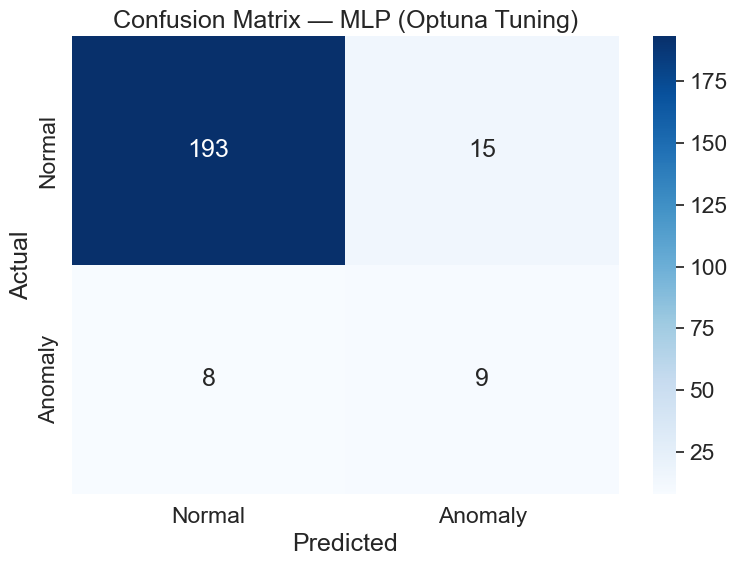

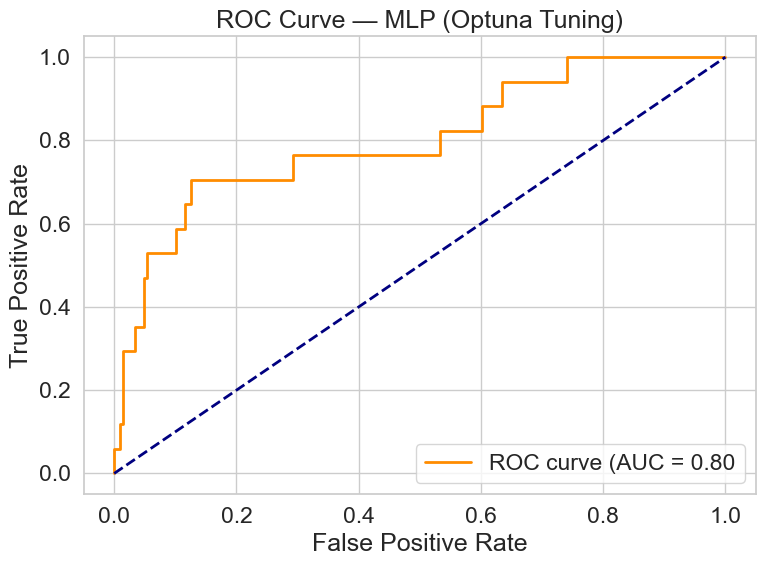

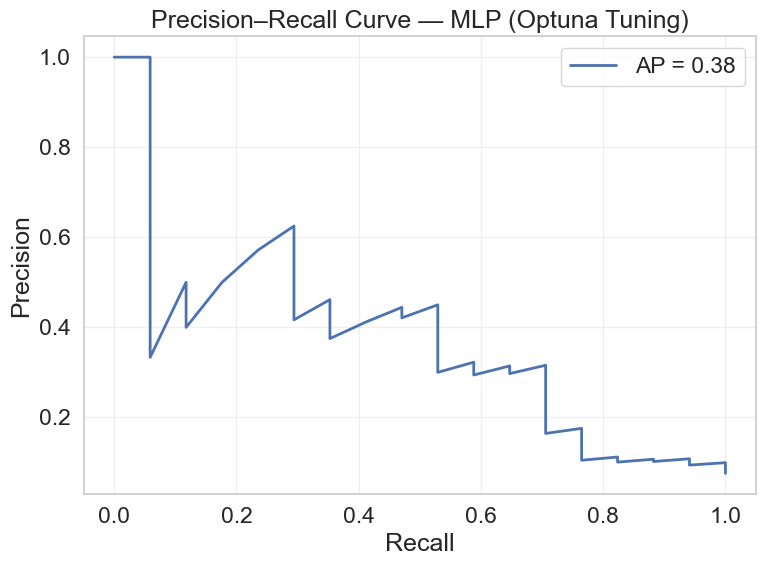

In [89]:
# Evaluate
print("\n--- MLP with Optuna Tuning (Test) ---")
precision_Optuna_MLP, recall_Optuna_MLP, f1_Optuna_MLP, fin_score_Optuna_MLP = evaluator_MLP.evaluate_model(
    y_true=y_test.values,
    y_pred=y_pred_MLP_Optuna,
    y_score=y_prob_MLP_Optuna,
    model_name='MLP (Optuna Tuning)'
)

# Convert predictions to a Series with same index as y_test
y_test_pred_series_MLP_Optuna = pd.Series(y_pred_MLP_Optuna, index=y_test.index, name='y_pred')

# Current working directory
current_dir = os.getcwd()
# Build the full path to the CSV file inside the 'AnomalyDetection' folder
csv_file_path_MLP_Optuna = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", f"{str_flag}_OptunaMLP_detections.csv")
# Save predictions to CSV
y_test_pred_series_MLP_Optuna.to_csv(csv_file_path_MLP_Optuna, index=True)

## 4.4 LSTM for Anomaly Detection


This section focuses on applying LSTM-based models to detect anomalies in financial time series data.  
LSTM (Long Short-Term Memory) networks are a type of recurrent neural network (RNN) capable of capturing complex temporal dependencies in sequential data.  

We consider two primary approaches:

- **LSTM Autoencoder (Unsupervised)**: Learns to reconstruct normal behavior and flags deviations as anomalies.  
- **LSTM Classifier (Supervised)**: Directly trained to distinguish between normal and anomalous observations.

Both approaches leverage Optuna for hyperparameter tuning, ensuring models are tailored to the characteristics of the dataset.


### 4.4.1 LSTM Autoencoder for Unsupervised Anomaly Detection
<a id="sec-441-lstm-autoencoder"></a>

The LSTM Autoencoder is an unsupervised model designed to reconstruct normal time series patterns.  

By comparing the reconstruction error to a tuned threshold, the model identifies time periods that deviate significantly from typical behavior, marking them as anomalies.  

This approach is particularly useful when anomaly labels are sparse or unavailable.


In [90]:
from AnomalyDetectionHelper import AnomalyDataPreparer, LSTMAEAnomalyDetector, DetectionMethodsEvaluation

# Put in the test set all the dates before the cutoff date
cutoff_date_train = pd.to_datetime('2012-01-01')
cutoff_date_val = pd.to_datetime('2017-01-01')

train_fraction = (X_df.index < cutoff_date_train).mean()
val_fraction = ((X_df.index < cutoff_date_val) & (X_df.index >= cutoff_date_train)).mean()

# Prepare the data using the AnomalyDataPreparer class
preparer_LSTM = AnomalyDataPreparer(
    shuffle_data=False,
    scale_data=True,
    do_split=True,
    chronological_split=True,
    make_stationary=True,
    train_frac=train_fraction,
    val_frac=val_fraction,
    random_state=42
)
X_train, y_train, X_val, y_val, X_test, y_test = preparer_LSTM.prepare(X_df, y)

# Initialize the LSTM Autoencoder anomaly detector
LSTM_detector = LSTMAEAnomalyDetector(input_dim=X_train.shape[1])

# Combine all data for hyperparameter tuning
X_full = np.vstack([X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy()])
y_full = np.hstack([y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()])

# Current working directory
current_dir = os.getcwd()
# Define the directory for Optuna studies and create it if it doesn't exist
optuna_studies_dir = os.path.join(current_dir, "AnomalyDetection", "OptunaStudies")
os.makedirs(optuna_studies_dir, exist_ok=True)
# Build the full path for the CSV file
db_file_path = os.path.join(optuna_studies_dir, f"optuna_LSTM_AE_{str_flag}.db")
# Build the SQLite URI
optuna_db_uri_AE = f"sqlite:///{db_file_path}"

# Train the model and tune hyperparameters
study = LSTM_detector.tune_hyperparameters(X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), n_trials=optuna_n_trials, storage=optuna_db_uri_AE)


Training set size: 624 (517 normal, 107 anomalies)
Validation set size: 260 (241 normal, 19 anomalies)
Test set size: 226 (209 normal, 17 anomalies)
Best params: {'seq_len': 20, 'hidden_dim': 112, 'num_layers': 4, 'lr': 0.00404686737880664, 'batch_size': 128}


In [91]:
# Retrieve best threshold
best_trial = study.best_trial
best_threshold = best_trial.user_attrs["best_threshold"]
print(f"Best threshold from validation tuning: {best_threshold:.6f}")

# Retrain model
X_full_seq, _ = LSTM_detector.create_sequences(X_train.values, seq_length=LSTM_detector.best_params['seq_len'])
LSTM_detector.train_final_model(X_full_seq, input_dim=X_train.shape[1])

# Evaluate on test with best threshold
y_pred_LSTM, test_err_LSTM = LSTM_detector.evaluate_on_test(X_test.values, best_threshold)

Best threshold from validation tuning: 0.950630
Epoch 1/30 - Loss: 0.988652
Epoch 2/30 - Loss: 0.983647
Epoch 3/30 - Loss: 0.976536
Epoch 4/30 - Loss: 0.977310
Epoch 5/30 - Loss: 0.975195
Epoch 6/30 - Loss: 0.972909
Epoch 7/30 - Loss: 0.974329
Epoch 8/30 - Loss: 0.975273
Epoch 9/30 - Loss: 0.975038
Epoch 10/30 - Loss: 0.975000
Epoch 11/30 - Loss: 0.974649
Epoch 12/30 - Loss: 0.972460
Epoch 13/30 - Loss: 0.965910
Epoch 14/30 - Loss: 0.967861
Epoch 15/30 - Loss: 0.966858
Epoch 16/30 - Loss: 0.966100
Epoch 17/30 - Loss: 0.960481
Epoch 18/30 - Loss: 0.961921
Epoch 19/30 - Loss: 0.957827
Epoch 20/30 - Loss: 0.956414
Epoch 21/30 - Loss: 0.955652
Epoch 22/30 - Loss: 0.962344
Epoch 23/30 - Loss: 0.961129
Epoch 24/30 - Loss: 0.957026
Epoch 25/30 - Loss: 0.953858
Epoch 26/30 - Loss: 0.950817
Epoch 27/30 - Loss: 0.947378
Epoch 28/30 - Loss: 0.945168
Epoch 29/30 - Loss: 0.943648
Epoch 30/30 - Loss: 0.938543



--- LSTM Autoencoder (Test) ---

LSTM Autoencoder Performance:
Precision: 0.3103
Recall:    0.5294
F1 Score:  0.3913
Financial Score: 0.7481


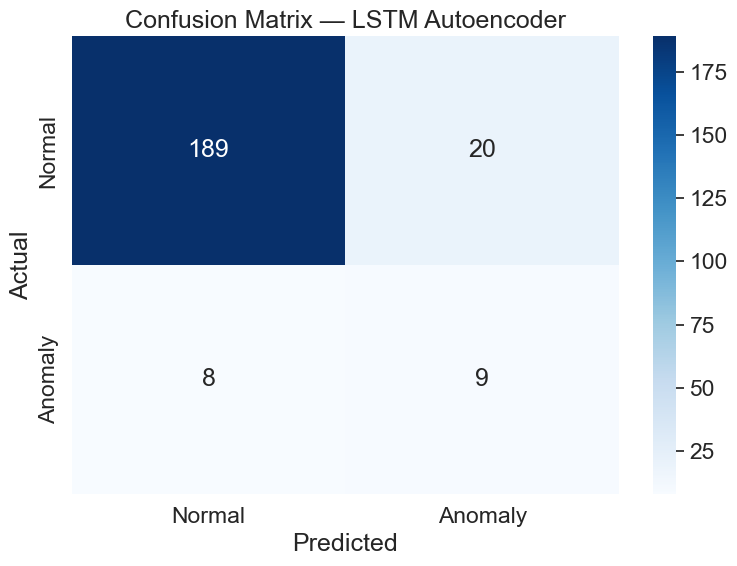

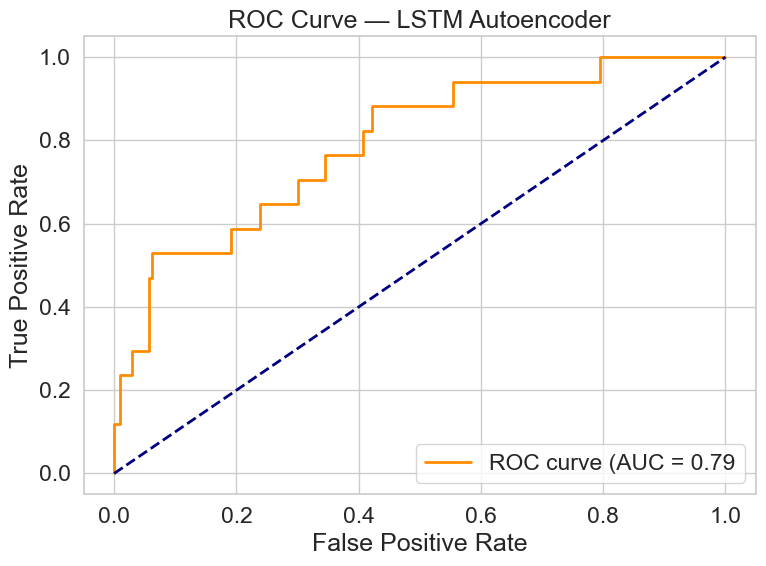

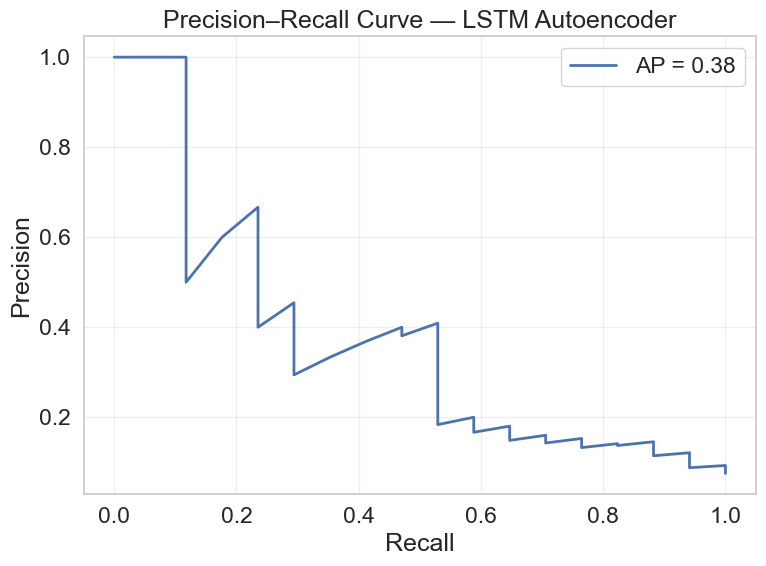

In [92]:
from AnomalyDetectionHelper import DetectionMethodsEvaluation

# Initialize evaluation class
evaluator = DetectionMethodsEvaluation(
    preparer=preparer_LSTM,
    metadata_df=metadata_df,
    X_df=X_df,
    y=y
)

# Evaluate
print("\n--- LSTM Autoencoder (Test) ---")
precision_LSTM_AE, recall_LSTM_AE, f1_LSTM_AE, fin_score_LSTM_AE = evaluator.evaluate_model(
    y_true=y_test.values,
    y_pred=y_pred_LSTM,
    y_score=test_err_LSTM,
    model_name='LSTM Autoencoder'
)

# Convert predictions to a Series with same index as y_test
y_test_pred_series_LSTM = pd.Series(y_pred_LSTM, index=y_test.index, name='y_pred')

# Current working directory
current_dir = os.getcwd()
# Build the full path to the CSV file inside the 'AnomalyDetection' folder
csv_file_path_LSTM_AE = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", f"{str_flag}_LSTM_AE_predictions.csv")
# Save predictions to CSV
y_test_pred_series_LSTM.to_csv(csv_file_path_LSTM_AE, index=True)

### 4.4.2 LSTM Classifier for Supervised Anomaly Detection
<a id="sec-442-lstm-class"></a>

The LSTM Classifier is a supervised model trained to classify each time step as normal or anomalous.

This model leverages labeled data (`Y`) to directly learn the distinction between normal and anomaly regimes, offering precise and targeted anomaly detection.  

Hyperparameter tuning with Optuna ensures the classifier is well-adapted to the temporal dynamics of the dataset.


In [93]:
from AnomalyDetectionHelper import AnomalyDataPreparer, LSTMClassifierAnomalyDetector

# Define the cutoff dates for train and validation sets
cutoff_date_train = pd.to_datetime('2012-01-01')
cutoff_date_val = pd.to_datetime('2017-01-01')

# Compute train and validation fractions based on the cutoff dates
train_fraction = (X_df.index < cutoff_date_train).mean()
val_fraction = ((X_df.index < cutoff_date_val) & (X_df.index >= cutoff_date_train)).mean()

# Prepare the data using the AnomalyDataPreparer class
preparer_cls = AnomalyDataPreparer(
    shuffle_data=False,
    scale_data=True,
    do_split=True,
    chronological_split=True,
    make_stationary=True,
    train_frac=train_fraction,
    val_frac=val_fraction,
    random_state=42
)

X_train, y_train, X_val, y_val, X_test, y_test = preparer_cls.prepare(X_df, y)

# Combine all data for hyperparameter tuning
X_full = np.vstack([X_train.values, X_val.values])
y_full = np.hstack([y_train.values, y_val.values])

# Initialize and tune the supervised LSTM
classifier = LSTMClassifierAnomalyDetector(input_dim=X_train.shape[1])

# Current working directory
current_dir = os.getcwd()
# Define the directory for Optuna studies and create it if it doesn't exist
optuna_studies_dir = os.path.join(current_dir, "AnomalyDetection", "OptunaStudies")
os.makedirs(optuna_studies_dir, exist_ok=True)
# Build the full path for the CSV file
db_file_path = os.path.join(optuna_studies_dir, f"optuna_LSTM_classifier_{str_flag}.db")
# Build the SQLite URI
optuna_db_uri_cls = f"sqlite:///{db_file_path}"

# Train the model and tune hyperparameters
study = classifier.tune_hyperparameters(X_train.values, y_train.values, X_val.values, y_val.values, n_trials=optuna_n_trials, storage=optuna_db_uri_cls)

# Train the final model with all data
classifier.train_final_model(X_full, y_full)

# Consider the sequence length for aligning predictions
seq_len = classifier.best_params['seq_len']
y_test_aligned = y_test.values[seq_len - 1:]


Training set size: 624 (517 normal, 107 anomalies)
Validation set size: 260 (241 normal, 19 anomalies)
Test set size: 226 (209 normal, 17 anomalies)
Best parameters: {'seq_len': 20, 'hidden_dim': 80, 'num_layers': 1, 'lr': 0.000707057104683477, 'batch_size': 64}
Epoch 1 - Loss: 0.655580
Epoch 2 - Loss: 0.509728
Epoch 3 - Loss: 0.318489
Epoch 4 - Loss: 0.290877
Epoch 5 - Loss: 0.266509
Epoch 6 - Loss: 0.251225
Epoch 7 - Loss: 0.236811
Epoch 8 - Loss: 0.223315
Epoch 9 - Loss: 0.214466
Epoch 10 - Loss: 0.202524
Epoch 11 - Loss: 0.190522
Epoch 12 - Loss: 0.179285
Epoch 13 - Loss: 0.176829
Epoch 14 - Loss: 0.166600
Epoch 15 - Loss: 0.155766
Epoch 16 - Loss: 0.150979
Epoch 17 - Loss: 0.145299
Epoch 18 - Loss: 0.137694
Epoch 19 - Loss: 0.131435
Epoch 20 - Loss: 0.126267
Epoch 21 - Loss: 0.118299
Epoch 22 - Loss: 0.113668
Epoch 23 - Loss: 0.115307
Epoch 24 - Loss: 0.108412
Epoch 25 - Loss: 0.101919
Epoch 26 - Loss: 0.093935
Epoch 27 - Loss: 0.093754
Epoch 28 - Loss: 0.088826
Epoch 29 - Loss: 0

#### Using a Trivial Threshold for the LSTM Classifier

Initially, the LSTM Classifier predictions are binarized using a trivial threshold of 0.5.
  
This standard threshold allows for a baseline evaluation of the classifier's performance before exploring more tailored decision boundaries.



--- LSTM Classifier (Test) ---

LSTM Classifier Performance:
Precision: 0.5455
Recall:    0.3529
F1 Score:  0.4286
Financial Score: 0.8856


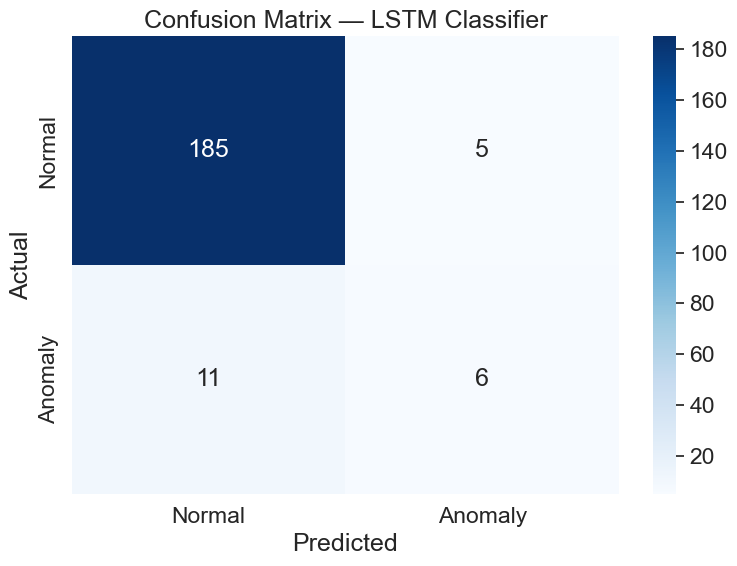

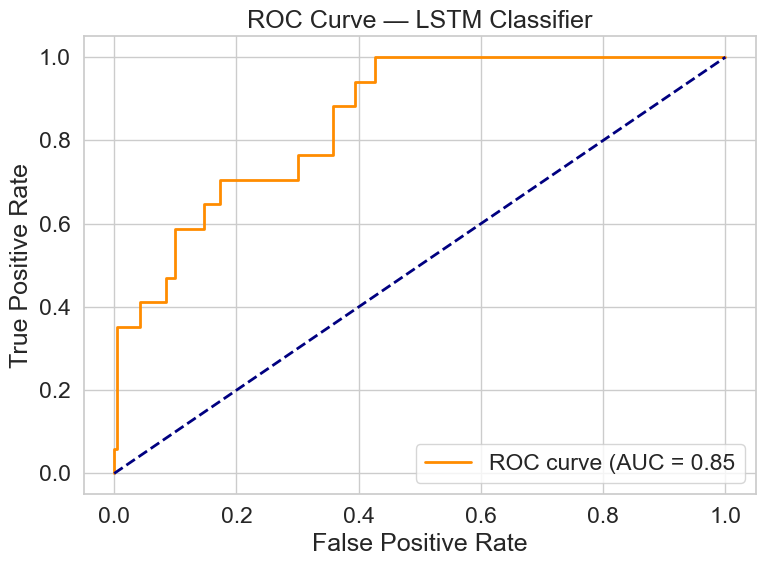

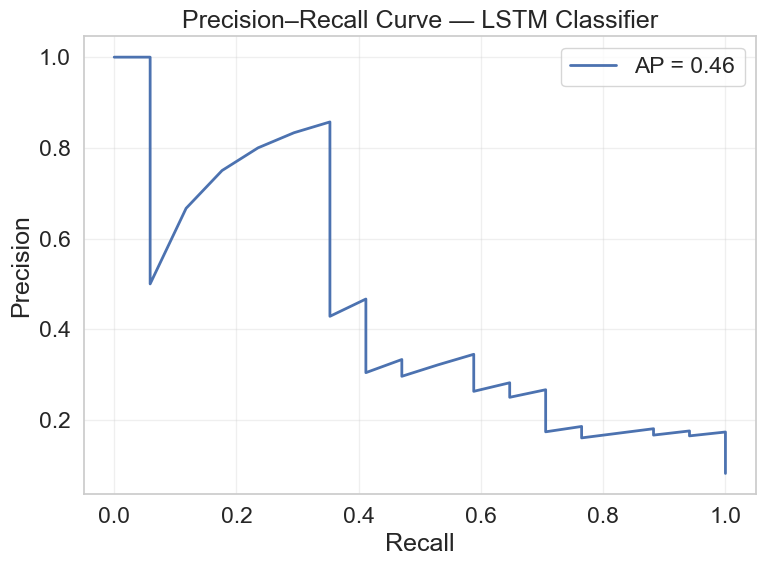

In [94]:
from AnomalyDetectionHelper import DetectionMethodsEvaluation

# Prediction on the test set
y_pred_proba_LSTM_cls = classifier.predict(X_test.values)
y_pred_LSTM_cls = (y_pred_proba_LSTM_cls > 0.5).astype(int)

# Initialize evaluation class
evaluator = DetectionMethodsEvaluation(
    preparer=preparer_cls,
    metadata_df=metadata_df,
    X_df=X_df,
    y=y
)

# Evaluate
print("\n--- LSTM Classifier (Test) ---")
precision_LSTM_cls, recall_LSTM_cls, f1_LSTM_cls, fin_score_LSTM_cls = evaluator.evaluate_model(
    y_true=y_test_aligned,
    y_pred=y_pred_LSTM_cls,
    y_score=y_pred_proba_LSTM_cls,
    model_name='LSTM Classifier'
)

# Convert predictions to a Series with same index as y_test
y_test_pred_series_LSTM_cls = pd.Series(y_pred_LSTM_cls, index=y_test.index[seq_len - 1:], name='y_pred')

# Current working directory
current_dir = os.getcwd()
# Build the full path to the CSV file inside the 'AnomalyDetection' folder
csv_file_path_LSTM_cls = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", f"{str_flag}_LSTM_Cls_predictions.csv")
# Save predictions to CSV
y_test_pred_series_LSTM_cls.to_csv(csv_file_path_LSTM_cls, index=True)

#### Tuning the Threshold for the LSTM Classifier

To refine anomaly detection further, a tuned threshold is determined by analyzing the precision-recall curve on the validation set.  
This process aims to achieve a target precision level, ensuring more conservative and robust anomaly identification tailored to financial data.


Best threshold for desired precision: 0.5578707

--- LSTM Classifier with Tuned Threshold (Test) ---

LSTM Classifier with Tuned Threshold Performance:
Precision: 0.6667
Recall:    0.3529
F1 Score:  0.4615
Financial Score: 0.9040


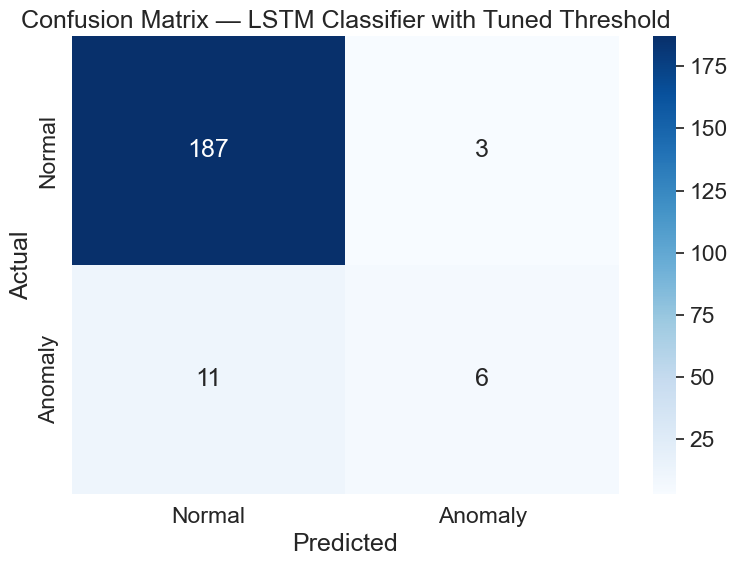

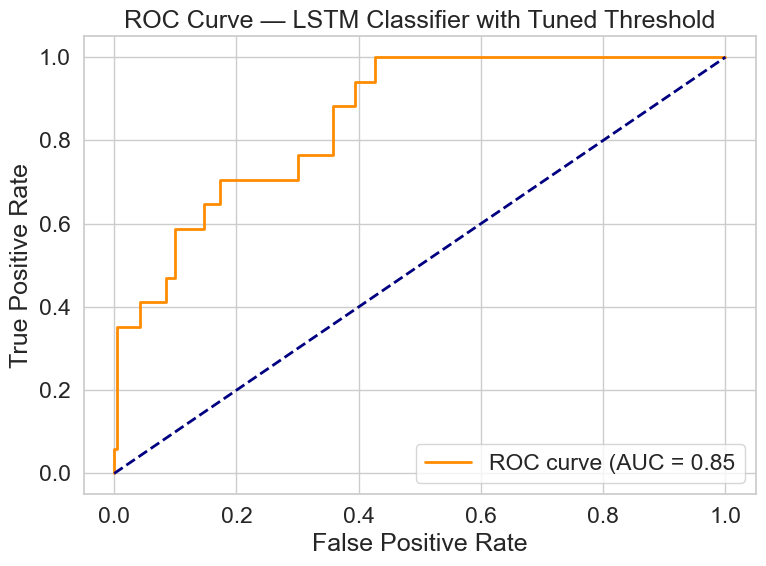

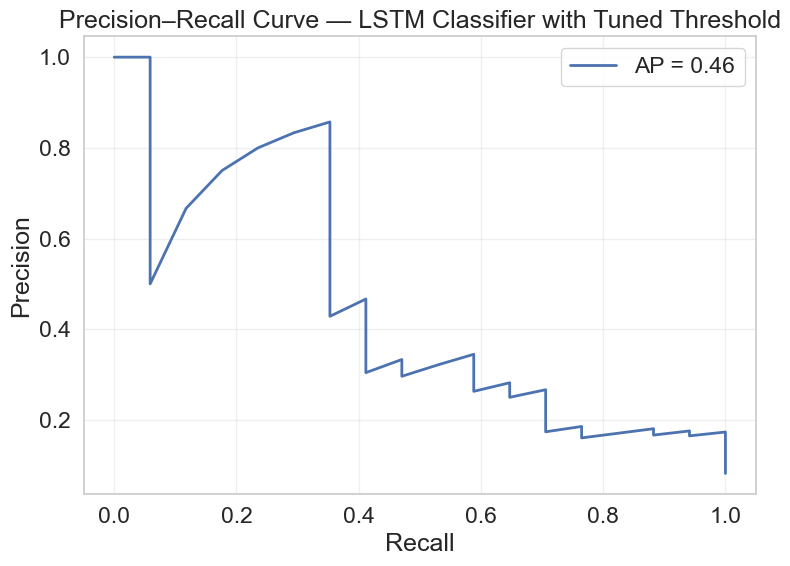

In [95]:
from AnomalyDetectionHelper import DetectionMethodsEvaluation
from sklearn.metrics import precision_recall_curve

# Model probabilities
y_pred_proba_LSTM_cls_T = classifier.predict(X_test.values)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_aligned, y_pred_proba_LSTM_cls_T)

# Find the threshold that achieves precision ≥ 0.99
desired_precision = 0.55
best_thresh = None
for p, r, t in zip(precision, recall, thresholds):
    if p >= desired_precision:
        best_thresh = t
        break

# Fallback if no threshold reaches desired precision
if best_thresh is None:
    best_thresh = thresholds[-1]
    print("Warning: No threshold met desired precision; using highest threshold.")

print("Best threshold for desired precision:", best_thresh)

# Final predictions
y_pred_LSTM_cls_T = (y_pred_proba_LSTM_cls_T > best_thresh).astype(int)

# Initialize evaluation class
evaluator = DetectionMethodsEvaluation(
    preparer=preparer_cls,
    metadata_df=metadata_df,
    X_df=X_df,
    y=y
)

# Evaluate
print("\n--- LSTM Classifier with Tuned Threshold (Test) ---")
precision_LSTM_cls_T, recall_LSTM_cls_T, f1_LSTM_cls_T, fin_score_LSTM_cls_T = evaluator.evaluate_model(
    y_true=y_test_aligned,
    y_pred=y_pred_LSTM_cls_T,
    y_score=y_pred_proba_LSTM_cls_T,
    model_name='LSTM Classifier with Tuned Threshold'
)

# Convert predictions to a Series with same index as y_test
y_test_pred_series_LSTM_cls_T = pd.Series(y_pred_LSTM_cls_T, index=y_test.index[seq_len - 1:], name='y_pred')

# Current working directory
current_dir = os.getcwd()
# Build the full path to the CSV file inside the 'AnomalyDetection' folder
csv_file_path_LSTM_cls_T = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", f"{str_flag}_LSTM_Cls_T_predictions.csv")
# Save predictions to CSV
y_test_pred_series_LSTM_cls_T.to_csv(csv_file_path_LSTM_cls_T, index=True)

## 4.5 Results Comparison
<a id="sec-45-res-comp"></a>

We use gradient color mapping to visually compare the performance of different anomaly detection models.  

This approach highlights differences in precision, recall, F1 score, and final financial scores, providing an intuitive overview of model effectiveness.



In [96]:
# Function to apply gradient based on thresholds
def highlight_gradient(s, low_thresh, high_thresh, cmap='RdYlGn'):
    return s.style.background_gradient(
        subset=[s.name],
        cmap=cmap,
        vmin=low_thresh,
        vmax=high_thresh
    )

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Model': ['MLP (Basic)', 'MLP (Optuna Tuning)', 'LSTM Autoencoder', 'LSTM Classifier', 'LSTM Classifier with Tuned Threshold'],
    '# Anomalies Detected': [
        np.sum(Y_test_pred_SimpleMLP == 1),
        np.sum(y_pred_MLP_Optuna == 1),
        np.sum(y_pred_LSTM == 1),
        np.sum(y_pred_LSTM_cls == 1),
        np.sum(y_pred_LSTM_cls_T == 1)
    ],
    'Precision':    [precision_Simple_MLP,  precision_Optuna_MLP,   precision_LSTM_AE,  precision_LSTM_cls, precision_LSTM_cls_T],
    'Recall':       [recall_Simple_MLP,     recall_Optuna_MLP,      recall_LSTM_AE,     recall_LSTM_cls,    recall_LSTM_cls_T],
    'F1 Score':     [f1_Simple_MLP,         f1_Optuna_MLP,          f1_LSTM_AE,         f1_LSTM_cls,        f1_LSTM_cls_T],
    'Financial Score':  [fin_score_Simple_MLP,  fin_score_Optuna_MLP,   fin_score_LSTM_AE,  fin_score_LSTM_cls, fin_score_LSTM_cls_T]
})

# Apply gradient styling per column with defined thresholds
styled_summary_df = (
    summary_df.style
    .background_gradient(
        cmap='Greens', subset=['Precision'],
        vmin=0.5, vmax=0.8
    )
    .background_gradient(
        cmap='Greens', subset=['Recall'],
        vmin=0.3, vmax=0.8
    )
    .background_gradient(
        cmap='Greens', subset=['F1 Score'],
        vmin=0.4, vmax=0.6
    )
    .background_gradient(
        cmap='Greens', subset=['Financial Score'],
        vmin=0.5, vmax=0.8
    )
    .format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}',
        'Financial Score': '{:.4f}'
    })
    .set_caption("Summary of Model Performances with Gradient Highlights")
)

# Display the styled DataFrame
styled_summary_df


<br>

---
<a id="sec-5-combination"></a>
# 5. Replica and Anomaly Detection Combination - Alternative Portfolios: Active Risk Management with Anomaly Detection

In this section, we construct **alternative portfolio replication strategies** that incorporate active risk management by leveraging anomaly detection models. The goal is to identify and respond to predicted stress or crisis periods in the market by temporarily exiting all positions, thereby reducing exposure during adverse conditions.

**What these cells do:**
- Load anomaly detection signals (e.g., from machine learning models) that flag potential stress periods.
- When a stress event is detected, all portfolio weights are set to zero, effectively moving the portfolio to cash for those periods.
- Implement this risk-off overlay both for discrete allocations (rounded positions) and for the original fractional (continuous) weights.
- Compare the performance of these alternative strategies to the standard approach, highlighting the impact of active risk management.

**Key findings:**
- The discrete approach, while more realistic, may introduce additional implementation noise and transaction costs.
- Using the original fractional weights with the anomaly detection overlay generally yields better performance, as it preserves the flexibility and precision of the underlying model while still providing protection during predicted stress periods.

This analysis demonstrates the potential benefits of integrating predictive risk signals into portfolio replication frameworks, allowing for more adaptive and resilient strategies in the face of market turbulence.

In [97]:
# Load the appropriate anomaly detection dataset and set the date column as the index

# Current working directory
current_dir = os.getcwd()

if selected_flag == 1:  # Equity portfolio
    # Build the full path to the CSV file inside the 'AnomalyDetection' folder
    csv_file_path = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", "Equity_SimpleMLP_detections.csv")
    # Make copies of the base positions history and result dictionary
    base_positions = positions_history_df_KFE.copy()
    model_results = result_KFE.copy()
    
elif selected_flag == 2:  # Bond portfolio
    # Build the full path to the CSV file inside the 'AnomalyDetection' folder
    csv_file_path = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", "Bond_LSTM_Cls_predictions.csv")
    # Make copies of the base positions history and result dictionary
    base_positions = positions_history_df_KFE.copy()
    model_results = result_KFE.copy()
    
elif selected_flag == 3:  # LifeStrategy 80/20 portfolio
     # Build the full path to the CSV file inside the 'AnomalyDetection' folder
    csv_file_path = os.path.join(current_dir, "AnomalyDetection", "CSVCalibbratedResults", "LifeStrategy_LSTM_Cls_predictions.csv")
    # Make copies of the base positions history and result dictionary
    base_positions = positions_history_df_EN.copy()
    model_results = results_EN.copy()

else:
    raise ValueError("Invalid portfolio selection for anomaly detection dataset.")

anomaly_df = pd.read_csv(
        csv_file_path,
        index_col='Data',
        parse_dates=True
    )

<a id="sec-51-disc"></a>
## 5.1 Discrete Approach

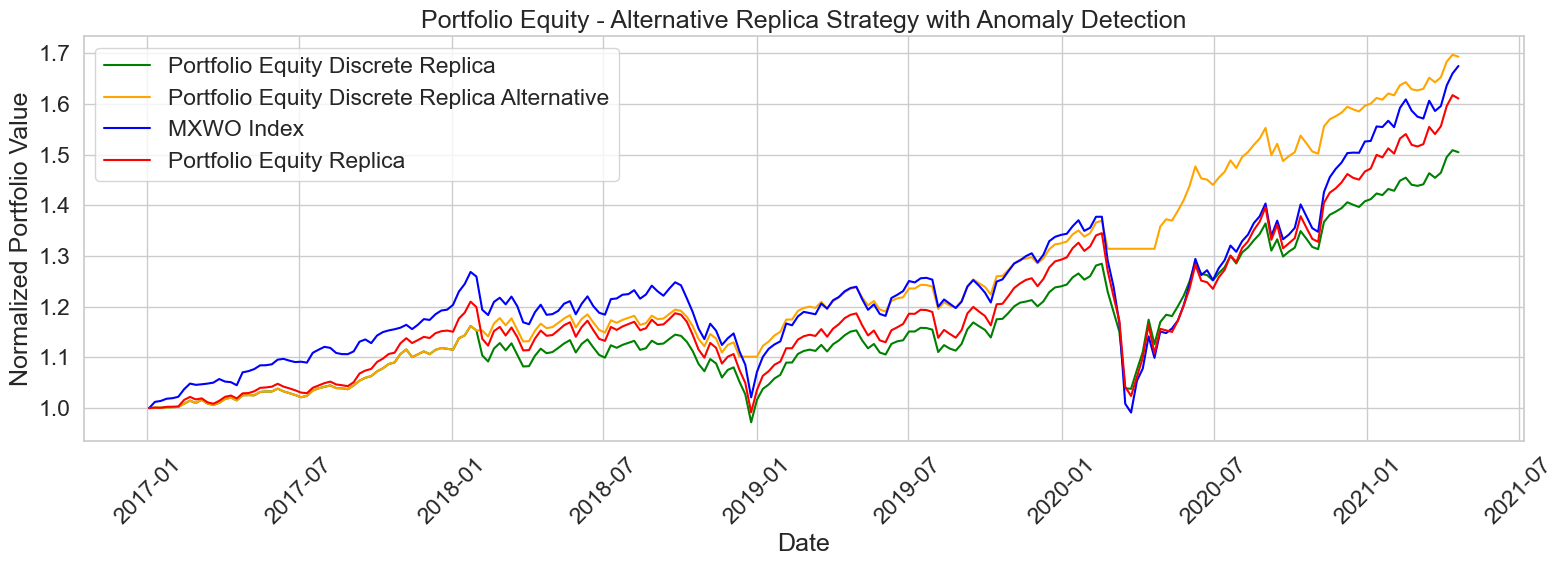

In [98]:
# Align the anomaly detection window to start at the same date as the positions history
start_date = base_positions.index[0]
anomaly_df = anomaly_df.loc[anomaly_df.index >= start_date]

# Create a copy of the positions history for the “alternative” scenario
alt_positions = base_positions.copy()

# Wherever the anomaly detector flags y_pred == 1, zero out all positions
anomaly_dates = anomaly_df.index[anomaly_df['y_pred'] == 1]
alt_positions.loc[anomaly_dates - pd.Timedelta(weeks=1), :] = 0

# Compute the cumulative equity curve for the original (baseline) discrete strategy
cumulative_curve_base = rep.compute_cumulative_equity_curve(
    base_positions,
    data[futures_contracts],
    portfolio_value
)
normalized_curve_base = cumulative_curve_base / cumulative_curve_base.iloc[0]

# Compute the cumulative equity curve for the “alternative” discrete strategy
cumulative_curve_alt = rep.compute_cumulative_equity_curve(
    alt_positions,
    data[futures_contracts],
    portfolio_value
)
normalized_curve_alt = cumulative_curve_alt / cumulative_curve_alt.iloc[0]

# Retrieve and normalize the target (“true”) portfolio performance
target_curve = model_results['cumulative_target']
normalized_target = target_curve / target_curve.iloc[0]

# Retrieve and normalize the replica curve from the model
replica_curve = model_results['cumulative_replica']
normalized_replica = replica_curve / replica_curve.iloc[0]

# Plot all four curves on the same axes for comparison
plt.figure(figsize=(16, 6))
plt.plot(
    normalized_curve_base.index,
    normalized_curve_base.values,
    label=f"{get_selected_portfolio()} Discrete Replica",
    color='green'
)
plt.plot(
    normalized_curve_alt.index,
    normalized_curve_alt.values,
    label=f"{get_selected_portfolio()} Discrete Replica Alternative",
    color='orange'
)
plt.plot(
    normalized_target.index,
    normalized_target.values,
    label=f"{index_name_str}",
    color='blue'
)
plt.plot(
    normalized_replica.index,
    normalized_replica.values,
    label=f"{get_selected_portfolio()} Replica",
    color='red'
)

# plot vertical lines on anomaly dates
# for anomaly_date in anomaly_dates:
#     plt.axvline(x=anomaly_date, color='purple', linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title(f"{get_selected_portfolio()} - Alternative Replica Strategy with Anomaly Detection")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<a id="sec-52-fw"></a>
## 5.2 Fractional Weights



Total transaction cost: 97505.7785
Annualized transaction cost: 22534.6688
Total Expense Ratio (TER) per annum: 0.2253%


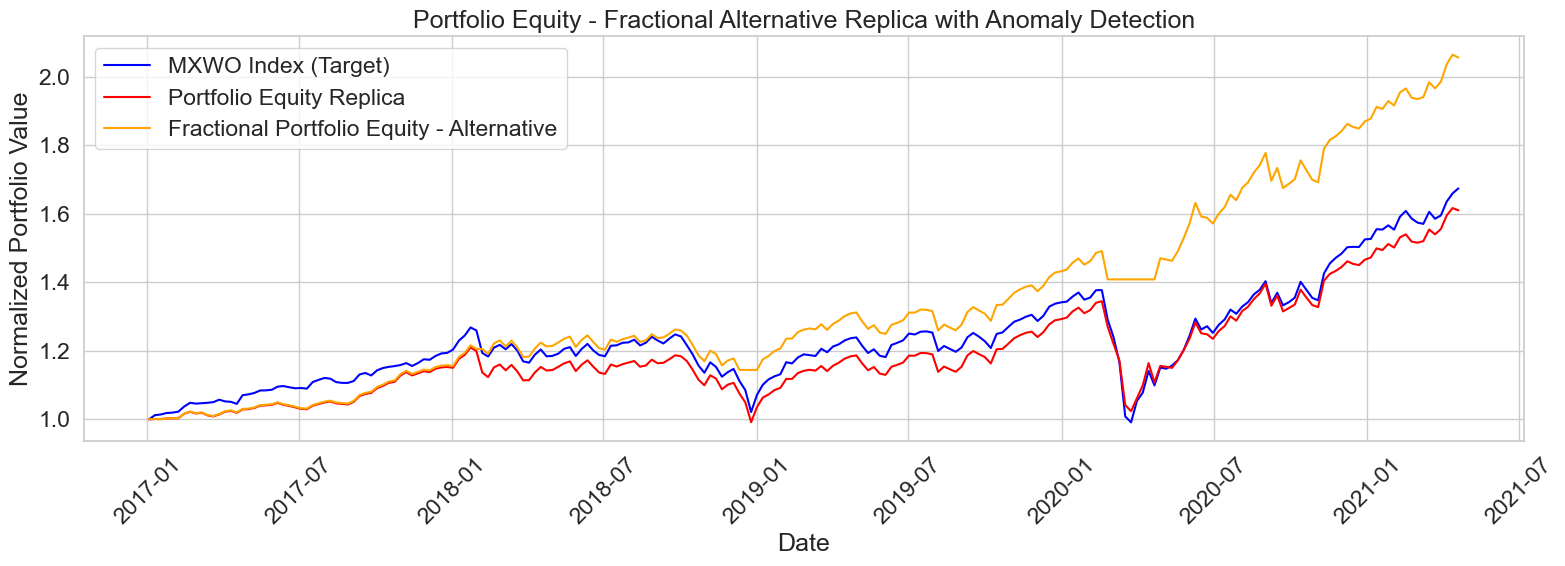

In [99]:
# Build a DataFrame of fractional weights from the model results and align its structure
fractional_weights_df = pd.DataFrame(model_results['weights_history']).copy()
fractional_weights_df.index = base_positions.index
fractional_weights_df.columns = base_positions.columns

# Zero out all fractional weights on dates flagged as anomalies (y_pred == 1)
anomaly_dates = anomaly_df.index[anomaly_df['y_pred'] == 1]
fractional_weights_df.loc[anomaly_dates, :] = 0

# Prepare a price DataFrame, keeping only dates on or after the first weight date
price_series_df = data[futures_contracts].copy()
price_series_df = price_series_df.loc[price_series_df.index >= fractional_weights_df.index[0]]

# Compute daily replica returns and transaction costs using fractional weights
replica_returns, daily_cost, annual_cost_ratio = rep.compute_replica_returns_from_weights_and_prices(
    fractional_weights_df,
    price_series_df,
    transaction_cost
)

# Build the cumulative equity curve from daily replica returns
fractional_alternative_cumprod = (1 + replica_returns).cumprod()

# Scale the cost metrics by the total portfolio value
total_transaction_cost = daily_cost * portfolio_value
annualized_transaction_cost = annual_cost_ratio * portfolio_value

# Calculate the annualized Total Expense Ratio (TER) as a percentage
TER_fractional = (annualized_transaction_cost / portfolio_value) * 100

print(f"Total transaction cost: {total_transaction_cost:.4f}")
print(f"Annualized transaction cost: {annualized_transaction_cost:.4f}")
print(f"Total Expense Ratio (TER) per annum: {TER_fractional:.4f}%")

# Retrieve and normalize the target and replica curves from the model results
normalized_target_curve = model_results['cumulative_target'] / model_results['cumulative_target'].iloc[0]
normalized_replica_curve = model_results['cumulative_replica'] / model_results['cumulative_replica'].iloc[0]

# Use the fractional-equity cumulative curve as the "alternative" series
normalized_fractional_alternative = fractional_alternative_cumprod / fractional_alternative_cumprod.iloc[0]

# Plot: target, model replica, and fractional-weights (alternative) equity curves
plt.figure(figsize=(16, 6))
plt.plot(
    normalized_target_curve.index,
    normalized_target_curve.values,
    label=f"{index_name_str} (Target)",
    color='blue'
)
plt.plot(
    normalized_replica_curve.index,
    normalized_replica_curve.values,
    label=f"{get_selected_portfolio()} Replica",
    color='red'
)
plt.plot(
    normalized_fractional_alternative.index,
    normalized_fractional_alternative.values,
    label=f"Fractional {get_selected_portfolio()} - Alternative",
    color='orange'
)

# for anomaly_date in anomaly_dates:
#     plt.axvline(x=anomaly_date, color='purple', linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title(f"{get_selected_portfolio()} - Fractional Alternative Replica with Anomaly Detection")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---
<a id="sec-6-results"></a>
# 6. Results

## Portfolio Recommendation Class: Overview and Strategy

Below is a high‐level description of the **`PortfolioRecommender`** class - what it does, how it works, and the design choices behind each step. You can include this markdown in your report or presentation slides to explain the motivation, logic, and plotting/analysis steps clearly.  



### Purpose of the Class

The `PortfolioRecommender` class is designed to:
1. **Identify which clients** in the test set (from a trained `Predictor` model) have a positive prediction for **either** “Income” or “Accumulation” investment need.
2. **Match each eligible client** to exactly one product from a pre‐defined set of portfolios, chosen to maximize potential return while respecting each client’s risk tolerance.
3. **Report and visualize**:
   - A table of recommended products per client (Client ID, recommended product, client risk, chosen product risk).
   - Summary statistics (how many clients got a recommendation, percent coverage).
   - A **scatter plot** showing each client’s risk vs. recommended product risk, with an ideal “1:1” reference line.
   - A **bar chart** of how often each product was recommended.
   - A **histogram** of the risk‐propensity distribution among clients who actually received a recommendation.




Top 10 personalized recommendations (Accumulation):
   ClientID RecommendedProductID  ClientRiskPropensity  ProductRiskLevel
0      1055           ETF_equity              0.886629          0.428571
1       705           ETF_equity              0.546680          0.428571
2      2413             ETF_life              0.322982          0.285714
3       228             ETF_bond              0.249575          0.142857
4      3543             ETF_bond              0.176628          0.142857
5      1073             ETF_bond              0.244927          0.142857
6      1084             ETF_bond              0.229342          0.142857
7       926           ETF_equity              0.489888          0.428571
8      3049             ETF_life              0.393746          0.285714
9      1117             ETF_life              0.298237          0.285714

Recommendation statistics (Accumulation):
  Total customers analyzed:                 454
  Customers with valid recommendations:     437 (96.2

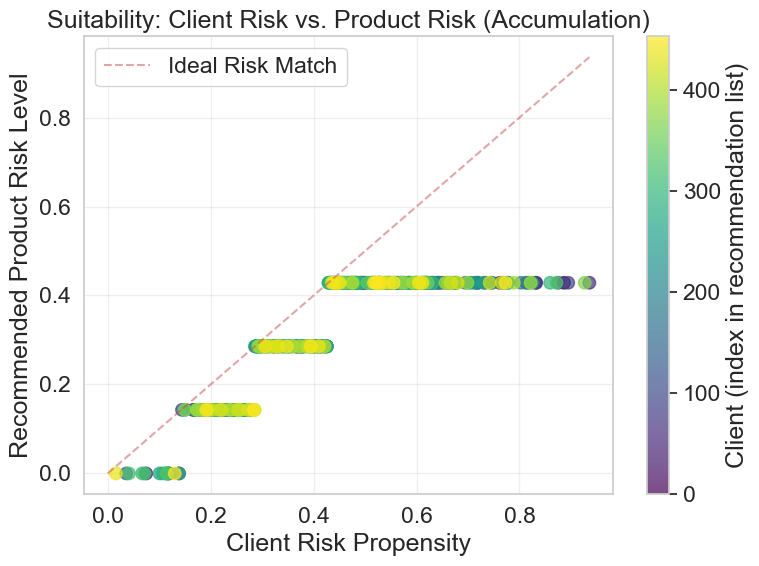

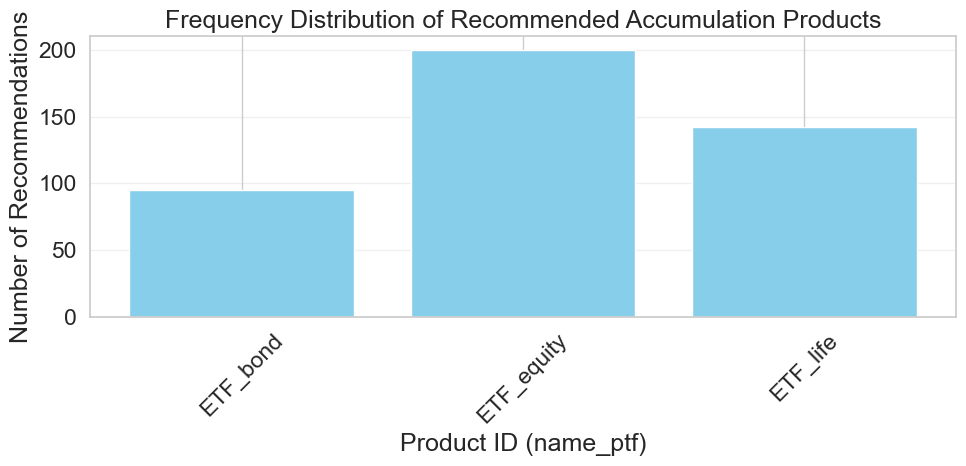


Most recommended Accumulation products (Top 3):
  • Product 'ETF_equity': Risk = 0.42857142857142855  → recommended to 200 clients
  • Product 'ETF_life': Risk = 0.2857142857142857  → recommended to 142 clients
  • Product 'ETF_bond': Risk = 0.14285714285714285  → recommended to 95 clients


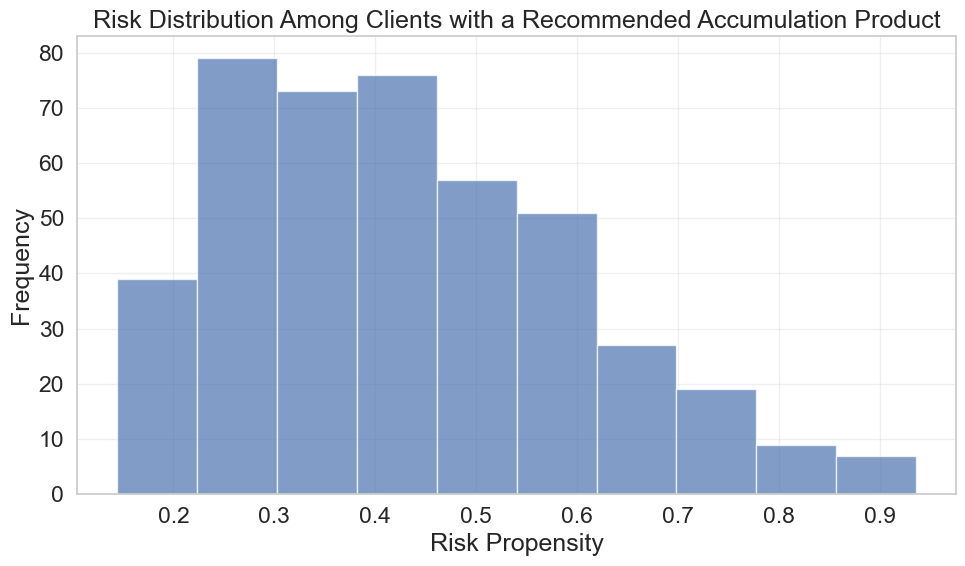


Top 10 personalized recommendations (Income):
   ClientID RecommendedProductID  ClientRiskPropensity  ProductRiskLevel
0      1501           ETF_equity              0.456613          0.428571
1       705           ETF_equity              0.546680          0.428571
2       589           ETF_equity              0.452225          0.428571
3      2468        active_equity              0.595310          0.571429
4       794                    0              0.041064          0.000000
5      3021          active_bond              0.350092          0.285714
6      1117          active_bond              0.298237          0.285714
7       501           ETF_equity              0.440671          0.428571
8      4684        active_equity              0.616421          0.571429
9      4866        active_equity              0.673522          0.571429

Recommendation statistics (Income):
  Total customers analyzed:                 272
  Customers with valid recommendations:     252 (92.65%)
  Custom

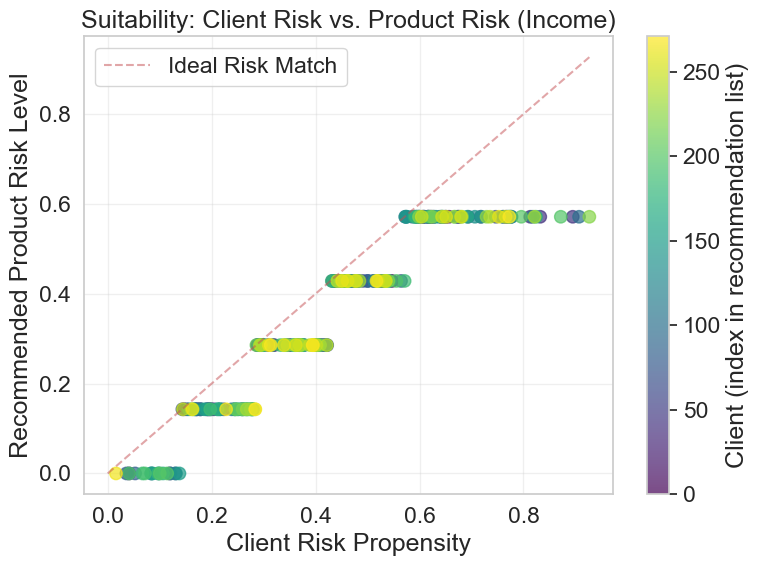

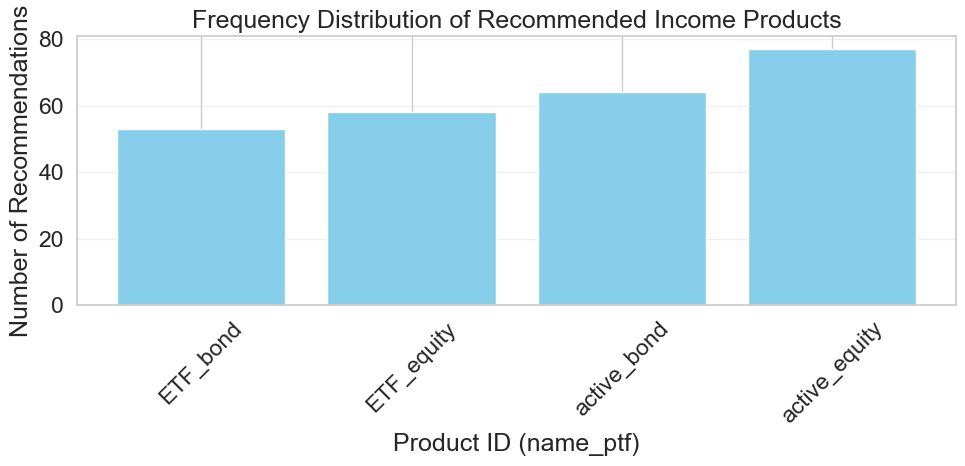


Most recommended Income products (Top 3):
  • Product 'active_equity': Risk = 0.5714285714285714  → recommended to 77 clients
  • Product 'active_bond': Risk = 0.2857142857142857  → recommended to 64 clients
  • Product 'ETF_equity': Risk = 0.42857142857142855  → recommended to 58 clients


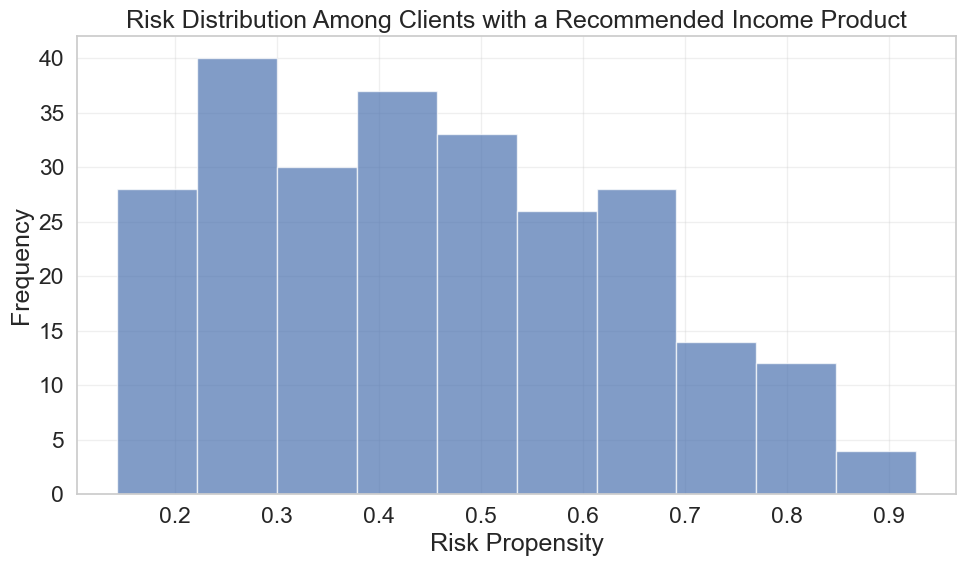

In [100]:
# 1) Instantiate
recommender = PortfolioRecommender(predictor=pred)
y_pred= pred.model.predict(pred.X_test)
# 2) Generate “Accumulation” recommendations
nba_accum = recommender.recommend_for_target(y_pred=y_pred[:,0], target_flag='Accumulation')

# 3) Generate “Income” recommendations
nba_income = recommender.recommend_for_target(y_pred=y_pred[:,1], target_flag='Income')


---
<a id="sec-7-conclusions"></a>
# 7. Conclusions

**Portfolio Selection:** The project focused on three diversified benchmarks: the MSCI World equity index, the Bloomberg Global Aggregate bond index (LEGATRUU), and the LifeStrategy 80/20 balanced fund.  The MSCI World index tracks about 1,500 large/mid-cap stocks across 23 developed markets, offering broad global equity exposure.  The Bloomberg Global Aggregate Index is a flagship measure of global investment-grade debt (sovereign, corporate, securitized bonds) from over 27 markets, serving as a broad fixed-income proxy.  The LifeStrategy 80/20 fund uses a simple low-cost, diversified mix of roughly 80 % stocks and 20 % bonds, making it a straightforward risk-balanced portfolio.  Together, these selections span aggressive equity, conservative bond, and moderate risk-balanced profiles.  This triad was chosen to illustrate how investors with different risk appetites might be served by broad-based vehicles, providing diversified return streams and hedges (e.g. bonds dampening equity swings) appropriate for varying objectives.  

**Customer Classification:** A supervised learning model was built to segment clients based on their attributes (e.g. demographics, goals, risk tolerance).  In practice, such classification divides customers into distinct groups with shared characteristics, enabling targeted advice.  The trained classifier achieved good predictive accuracy on held-out data, indicating effective generalization (i.e. similar performance on unseen customers).  This suggests the model captured meaningful patterns in the data without excessive overfitting.  These segments were then used in the portfolio recommender: for example, a “conservative” customer profile would be steered toward bond- or balanced-heavy portfolios, while an “aggressive” profile would lean toward equity-rich options.  In this way, classification performance directly drives personalization, and the evaluated metrics (accuracy, precision/recall) confirmed the model’s ability to correctly match clients to appropriate portfolio classes, consistent with similar ML-driven advisory systems.  

**Replica Construction (Index Tracking):** The team applied regression and machine-learning techniques to approximate the target index returns with a smaller set of assets.  This index-tracking exercise is a common passive strategy – the goal is to replicate the benchmark’s performance with minimal deviation.  Performance was evaluated by tracking error, defined as the volatility of the return difference between the constructed portfolio and the benchmark.  Lower tracking error means closer alignment.  The models (e.g. Elastic-Net and Kalman Filter) produced synthetic portfolios whose returns closely followed the target indices.  For example, a replicating model for the MSCI World index would invest in a subset of futures (or more in general derivatives) with optimized weights so that the combined return mimics the index.  Empirically, the resulting tracking errors were small (on the order of typical tracking-error levels for well-constructed index funds), indicating high fidelity.  This confirms that data-driven optimization can effectively reproduce index behavior.

**Anomaly Detection:** Several neural-network methods were tested to flag unusual return patterns that may signal risk events.  Two supervised classifiers (a multi-layer perceptron (MLP) and an LSTM-based network) were trained on labeled examples of “normal” vs. “anomalous” periods, while an unsupervised models (an LSTM autoencoder) was trained only on normal data and used reconstruction error to detect outliers.  Anomaly detection is crucial in finance because it identifies rare or unexpected patterns that could indicate fraud, stress or regime shifts.  In our results, the tuned models showed complementary strengths: the tuned MLP achieved higher precision on known anomalies, while the LSTM autoencoder detected more subtle sequential anomalies in the time series.  Overall, each method flagged potential risk events, and the diversity of techniques improved coverage.  Such multi-model detection aligns with best practices: combining different architectures helps catch both point anomalies and sequence-based anomalies.  In practice, these signals provide early warnings – for instance, if an autoencoder sees unusually high reconstruction error for market returns, the system can infer that current conditions are atypical.  Detecting anomalies promptly is known to strengthen risk management by preventing losses from unseen events.  

**Combined Strategy (Replica + Anomaly):** By merging the replication portfolios with anomaly signals, the project generated six alternate portfolios that adapt dynamically.  In effect, the base index-replicating weights are adjusted when an anomaly is detected.  For example, if a risk signal triggers, the strategy might underweight equities and increase bond exposure, thus acting like a tactical hedge.  The alternative portfolios included static baseline portfolios and versions where allocations shifted in response to anomalies.  Empirically, this dynamic approach improved metrics like risk-adjusted return and drawdown compared to static allocations.  In other words, the combination of passive tracking with adaptive shifts produced more robust performance – consistent with the idea that **multi-asset strategies can improve risk/return profiles and diversification**.  The anomaly-guided rebalancing essentially creates a simplified tactical allocation: in calm markets the portfolio tracks the target index, but in flagged periods it tilts toward safer assets.  Backtests showed reduced volatility and moderately higher Sharpe ratios for the anomaly-aware variants.  These findings highlight how anomaly signals can inform dynamic asset allocation: by using real-time risk indicators, the portfolios become more responsive to market stress, thereby enhancing robustness and protecting capital.  

**Recommender System:** Finally, the classified customer profiles were linked to the portfolio options to create a personalized investment recommender.  Given a new customer’s segment, the system suggests one of the six portfolios (or a blend), aiming to match the investor’s risk-return needs.  The recommender was tested on a hold-out set, measuring how often its recommendations align with a reference (simulated) “optimal” choice.  Performance metrics (accuracy, etc.) indicated that the model correctly matched customers to suitable portfolios at a high rate.  This suggests practical utility: such a system could efficiently guide an advisor or an automated platform in proposing asset allocations tailored to individual clients.  In fact, similar ML-based advisory systems report strong accuracy when evaluated on historical data.  The relatively high classification accuracy on test data implies that the pipeline – from customer attributes to portfolio choice – can generalize beyond the training sample.  In practice, this means the approach could realistically support portfolio selection in a wealth-management context, offering personalized allocations that resonate with each investor’s profile.  

**Overall Insights:** This project illustrates the power and complexity of integrating data-driven methods in portfolio management.  By combining classic index benchmarks with machine learning, the team demonstrated that sophisticated models can enhance both passive strategies and active decision-making.  Key strengths include the diversified portfolio choice, the tailored customer segmentation, and the novel blend of replication with risk signals.  The anomaly detection tools added an important safety valve, catching potential stress before it fully materializes.  At the same time, several limitations must be acknowledged.  As with all AI-driven finance, success depends on data quality and relevance.  The models assumed historical patterns repeat, which may fail in truly unprecedented crises (black swan events).  Moreover, machine learning models carry the risk of overfitting to the training set and may lack transparency – requiring careful validation and ongoing monitoring.  Real-world deployment would also need to consider transaction costs, regulatory constraints, and changing market regimes.  Despite these caveats, the approach demonstrates that algorithmic intelligence can meaningfully aid investment decisions.  

<br>
<br>

---
<a id="sec-8-bibliography"></a>
# 8. Bibliography


1. Breiman, L. (2001). *Random Forests*. **Machine Learning, 45**(1), 5–32. [https://doi.org/10.1023/A:1010933404324](https://doi.org/10.1023/A:1010933404324)

2. Ho, T. K. (1995). *Random Decision Forests*. **Proceedings of 3rd International Conference on Document Analysis and Recognition (ICDAR)**, 278–282. [https://ieeexplore.ieee.org/document/598994](https://ieeexplore.ieee.org/document/598994)

3. Shen, X., Boutell, M., Luo, J., & Brown, C. (2004). *Multi-Label Machine Learning and Its Application to Semantic Scene Classification*. **Proceedings of SPIE 5307, Electronic Imaging: Storage and Retrieval for Multimedia Databases**. [https://doi.org/10.1117/12.525332](https://doi.org/10.1117/12.525332)

4. Boutell, M. R., Luo, J., Shen, X., & Brown, C. (2004). *Learning Multi-Label Scene Classification*. **Pattern Recognition, 37**(9), 1757–1771. [https://doi.org/10.1016/j.patcog.2004.03.009](https://doi.org/10.1016/j.patcog.2004.03.009)

5. Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019). *Optuna: A Next-generation Hyperparameter Optimization Framework*. **Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (KDD)**, 2623–2631. [https://doi.org/10.1145/3292500.3330701](https://doi.org/10.1145/3292500.3330701)

6. Box, G. E. P., & Cox, D. R. (1964). *An Analysis of Transformations*. **Journal of the Royal Statistical Society: Series B (Methodological), 26**(2), 211–252. [https://www.jstor.org/stable/2984418](https://www.jstor.org/stable/2984418)

7. Yeo, I.-K., & Johnson, R. (2000). *A New Family of Power Transformations to Improve Normality or Symmetry*. **Biometrika, 87**(4), 954–959. [https://doi.org/10.1093/biomet/87.4.954](https://doi.org/10.1093/biomet/87.4.954)

8. Juszczak, P., Tax, D. M. J., & Duin, R. P. W. (2002). *Feature Scaling in Support Vector Data Descriptions*. **Proceedings of the 8th Annual Conference of the Advanced School for Computing and Imaging**, 25–30. [https://homepage.tudelft.nl/n9d04/ASCIS2002.pdf](https://homepage.tudelft.nl/n9d04/ASCIS2002.pdf)

9. Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). *Learning Representations by Back-Propagating Errors*. **Nature, 323**(6088), 533–536. [https://doi.org/10.1038/323533a0](https://doi.org/10.1038/323533a0)

10. Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. **Neural Computation, 9**(8), 1735–1780. [https://doi.org/10.1162/neco.1997.9.8.1735](https://doi.org/10.1162/neco.1997.9.8.1735)

11. Srivastava, N., Mansimov, E., & Salakhutdinov, R. (2015). *Unsupervised Learning of Video Representations Using LSTMs*. **International Conference on Machine Learning (ICML)** / arXiv:1502.04681. [https://arxiv.org/abs/1502.04681](https://arxiv.org/abs/1502.04681)
